## Google QUEST Q&A Labeling

Improving automated understanding of complex question answer content


In [1]:
# importing libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pickle
#from transformers import 
import numpy as np
from numpy import zeros
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm

from wordcloud import WordCloud, STOPWORDS 

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

import tensorflow
from tensorflow.keras.layers import Conv1D,AveragePooling1D,MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Input,concatenate,Activation,Dropout,BatchNormalization,LSTM
from tensorflow.keras import regularizers,Model
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import TensorBoard, Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler


from matplotlib_venn import venn2, venn2_unweighted
from matplotlib_venn import venn3, venn3_unweighted
%matplotlib inline

In [24]:
import dill
#dill.dump_session("session.db")

In [1]:
import dill
#dill.load_session("session_with_enodings_sw.db")

In C:\Users\JAYANY\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\JAYANY\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\JAYANY\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\JAYANY\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\JAYANY\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# reading train data from csv file

train = pd.read_csv("google-quest-challenge/train.csv")
print(train.shape)
train.head()

(6079, 41)


qa_id                                     question_title  \
0      0  What am I losing when using extension tubes in...   
1      1  What is the distinction between a city and a s...   
2      2  Maximum protusion length for through-hole comp...   
3      3              Can an affidavit be used in Beit Din?   
4      5       How do you make a binary image in Photoshop?   

                                       question_body question_user_name  \
0  After playing around with macro photography on...               ysap   
1  I am trying to understand what kinds of places...      russellpierce   
2  I'm working on a PCB that has through-hole com...          Joe Baker   
3  An affidavit, from what i understand, is basic...         Scimonster   
4  I am trying to make a binary image. I want mor...            leigero   

                                  question_user_page  \
0         https://photo.stackexchange.com/users/1024   
1           https://rpg.stackexchange.com/users/8774   
2  https://electronics.stackexchange.com/users/10157   
3       https://judaism.stackexchange.com/users/5151   
4  https://graphicdesign.stackexchange.com/users/...   

                                              answer answer_user_name  \
0  I just got extension tubes, so here's the skin...           rfusca   
1  It might be helpful to look into the definitio...     Erik Schmidt   
2  Do you even need grooves?  We make several pro...      Dwayne Reid   
3  Sending an "affidavit" it is a dispute between...    Y     e     z   
4  Check out Image Trace in Adobe Illustrator. \n...             q2ra   

                                    answer_user_page  \
0         https://photo.stackexchange.com/users/1917   
1           https://rpg.stackexchange.com/users/1871   
2  https://electronics.stackexchange.com/users/64754   
3       https://judaism.stackexchange.com/users/4794   
4  https://graphicdesign.stackexchange.com/users/...   

                                                 url   category  ...  \
0  http://photo.stackexchange.com/questions/9169/...  LIFE_ARTS  ...   
1  http://rpg.stackexchange.com/questions/47820/w...    CULTURE  ...   
2  http://electronics.stackexchange.com/questions...    SCIENCE  ...   
3  http://judaism.stackexchange.com/questions/551...    CULTURE  ...   
4  http://graphicdesign.stackexchange.com/questio...  LIFE_ARTS  ...   

  question_well_written  answer_helpful  answer_level_of_information  \
0              1.000000        1.000000                     0.666667   
1              0.888889        0.888889                     0.555556   
2              0.777778        0.777778                     0.555556   
3              0.888889        0.833333                     0.333333   
4              1.000000        1.000000                     0.666667   

   answer_plausible  answer_relevance  answer_satisfaction  \
0          1.000000          1.000000             0.800000   
1          0.888889          0.888889             0.666667   
2          1.000000          1.000000             0.666667   
3          0.833333          1.000000             0.800000   
4          1.000000          1.000000             0.800000   

   answer_type_instructions  answer_type_procedure  \
0                       1.0               0.000000   
1                       0.0               0.000000   
2                       0.0               0.333333   
3                       0.0               0.000000   
4                       1.0               0.000000   

   answer_type_reason_explanation  answer_well_written  
0                        0.000000             1.000000  
1                        0.666667             0.888889  
2                        1.000000             0.888889  
3                        1.000000             1.000000  
4                        1.000000             1.000000  

[5 rows x 41 columns]

In [3]:
train.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [4]:
# reading test data from csv file
test = pd.read_csv("google-quest-challenge/test.csv")
print(test.shape)
test.head()

(476, 11)


qa_id                                     question_title  \
0     39  Will leaving corpses lying around upset my pri...   
1     46         Url link to feature image in the portfolio   
2     70  Is accuracy, recoil or bullet spread affected ...   
3    132     Suddenly got an I/O error from my external HDD   
4    200  Passenger Name - Flight Booking Passenger only...   

                                       question_body question_user_name  \
0  I see questions/information online about how t...              Dylan   
1  I am new to Wordpress. i have issue with Featu...                Anu   
2  To experiment I started a bot game, toggled in...             Konsta   
3  I have used my Raspberry Pi as a torrent-serve...           robbannn   
4  I have bought Delhi-London return flights for ...               Amit   

                                  question_user_page  \
0       https://gaming.stackexchange.com/users/64471   
1    https://wordpress.stackexchange.com/users/72927   
2       https://gaming.stackexchange.com/users/37545   
3  https://raspberrypi.stackexchange.com/users/17341   
4       https://travel.stackexchange.com/users/29089   

                                              answer answer_user_name  \
0  There is no consequence for leaving corpses an...        Nelson868   
1  I think it is possible with custom fields.\n\n...            Irina   
2  You do not have armour in the screenshots. Thi...   Damon Smithies   
3  Your Western Digital hard drive is disappearin...      HeatfanJohn   
4  I called two persons who work for Saudia (tick...    Nean Der Thal   

                                   answer_user_page  \
0      https://gaming.stackexchange.com/users/97324   
1   https://wordpress.stackexchange.com/users/27233   
2      https://gaming.stackexchange.com/users/70641   
3  https://raspberrypi.stackexchange.com/users/1311   
4      https://travel.stackexchange.com/users/10051   

                                                 url    category  \
0  http://gaming.stackexchange.com/questions/1979...     CULTURE   
1  http://wordpress.stackexchange.com/questions/1...  TECHNOLOGY   
2  http://gaming.stackexchange.com/questions/2154...     CULTURE   
3  http://raspberrypi.stackexchange.com/questions...  TECHNOLOGY   
4  http://travel.stackexchange.com/questions/4704...     CULTURE   

                            host  
0       gaming.stackexchange.com  
1    wordpress.stackexchange.com  
2       gaming.stackexchange.com  
3  raspberrypi.stackexchange.com  
4       travel.stackexchange.com

In [5]:
sample = pd.read_csv("google-quest-challenge/sample_submission.csv")
class_labels = list(sample.columns)[1:]
print("Number of class labels = ",len(class_labels))
class_labels

Number of class labels =  30


['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

In [6]:
input_col = list(test.columns)
input_col.remove('qa_id')
input_col

['question_title',
 'question_body',
 'question_user_name',
 'question_user_page',
 'answer',
 'answer_user_name',
 'answer_user_page',
 'url',
 'category',
 'host']

In [7]:
# checking if there are any missing values
train.isna().sum()

qa_id                                    0
question_title                           0
question_body                            0
question_user_name                       0
question_user_page                       0
answer                                   0
answer_user_name                         0
answer_user_page                         0
url                                      0
category                                 0
host                                     0
question_asker_intent_understanding      0
question_body_critical                   0
question_conversational                  0
question_expect_short_answer             0
question_fact_seeking                    0
question_has_commonly_accepted_answer    0
question_interestingness_others          0
question_interestingness_self            0
question_multi_intent                    0
question_not_really_a_question           0
question_opinion_seeking                 0
question_type_choice                     0
question_ty

### EDA

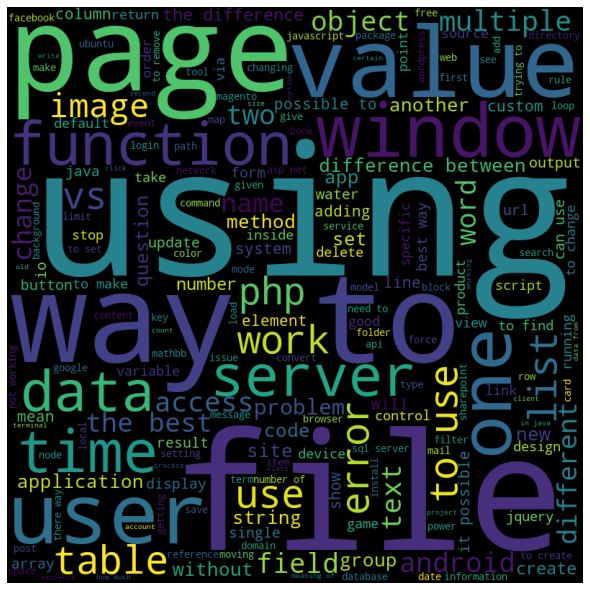

In [ ]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# plotting Wordcloud of question title

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the question title 
for val in train.question_title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

From the above Wordcloud, it can be said that most occuring words in Question title are `using, file, use, value, user, one, time, change, window, function, data`

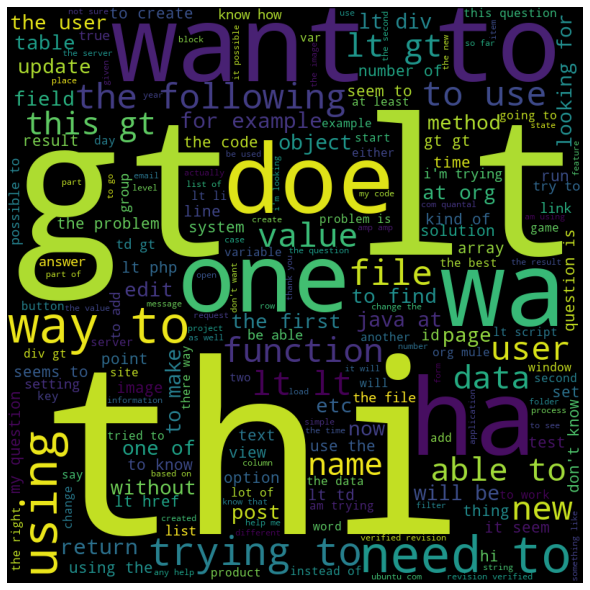

In [ ]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# plotting Wordcloud of question body

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the question body  
for val in train.question_body: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

From the above Wordcloud, it can be said that most occuring words in Question body are `gt, lt, one, will, using, use, example,know, question, new, work, value, problem`

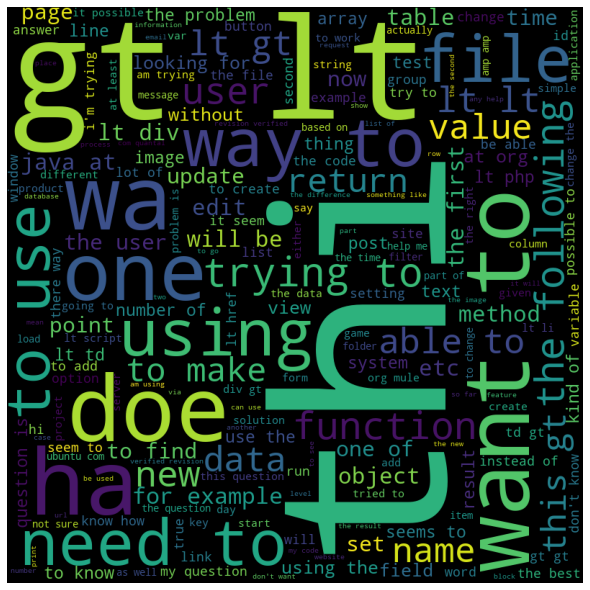

In [ ]:
# plotting Wordcloud of (question body + question title)

comment_words = '' 
stopwords = set(STOPWORDS) 

# iterate through the question title 
for val in train.question_title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

# iterate through the question body 
for val in train.question_body: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "


  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Some of the most occuring words in Question body and title combined are `gt, lt, one, will, use, file, want, example, know, question, using, new, work, problem`

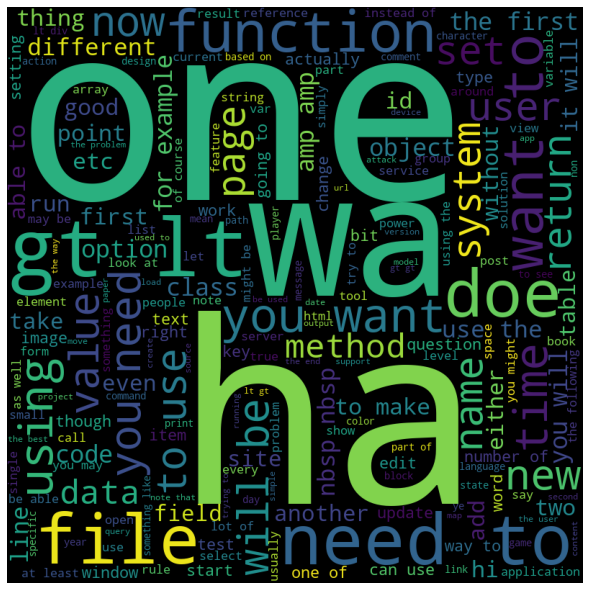

In [ ]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# plotting Wordcloud of answers

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in train.answer: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

From the above Wordcloud, it can be said that most occuring words in Question title are `use, one, will, need, gt, lt, using, file, time, gt, lt, way, make, example, see`

In [8]:
# taking set of all words in question title
q_title_set = set([word for question in train.question_title for word in question.split(' ')])

# taking set of all words in question body
q_body_set = set([word for question in train.question_body for word in question.split(' ')])

# taking set of all words in answer
answer_set = set([word for answer in train.answer for word in answer.split(' ')])

Text(0.5, 1.0, 'Venn diagram of (set of words in Question title) vs (set of words in Question body)')

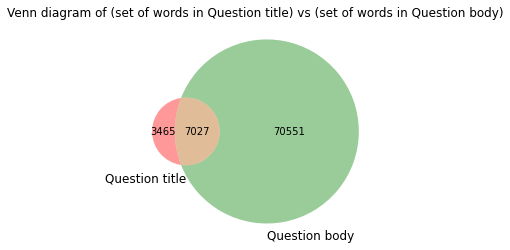

In [9]:
# https://pypi.org/project/matplotlib-venn/
# venn diagram of (set of words in Question title) vs (set of words in Question body)

venn2([q_title_set,q_body_set], set_labels=("Question title","Question body"))
plt.title("Venn diagram of (set of words in Question title) vs (set of words in Question body)")


##### There is a good overlap between Question title and Question body. Out of 10492 words in Question title, 7027 are common with Question body.

Text(0.5, 1.0, 'Venn diagram of (set of words in Answer) vs (set of words in Question body)')

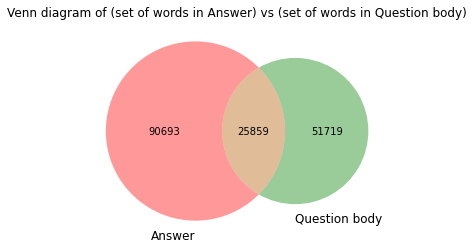

In [10]:
# venn diagram of (set of words in answer) vs (set of words in Question body)

h = venn2([answer_set,q_body_set], set_labels=("Answer","Question body"))
plt.title("Venn diagram of (set of words in Answer) vs (set of words in Question body)")


##### Out of 77578 words in Question body, 25859 words i.e. nearly 33% are common with answer.

Text(0.5, 1.0, 'Venn diagram of (set of words in Answer) vs (set of words in Question title)')

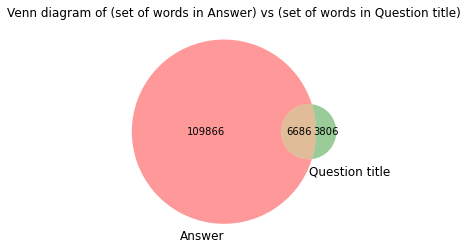

In [11]:
# venn diagram of (set of words in answer) vs (set of words in Question body)

h = venn2([answer_set,q_title_set], set_labels=("Answer","Question title"))
plt.title("Venn diagram of (set of words in Answer) vs (set of words in Question title)")


##### Answer and Question title also have a good overlap. Around 63% of the words in Question title are present in Answers.

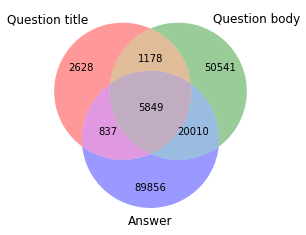

In [ ]:
# venn diagram of (set of words in Question title) vs (set of words in Question body) vs (set of words in answer)
venn3_unweighted([q_title_set,q_body_set,answer_set],('Question title', 'Question body', 'Answer'))

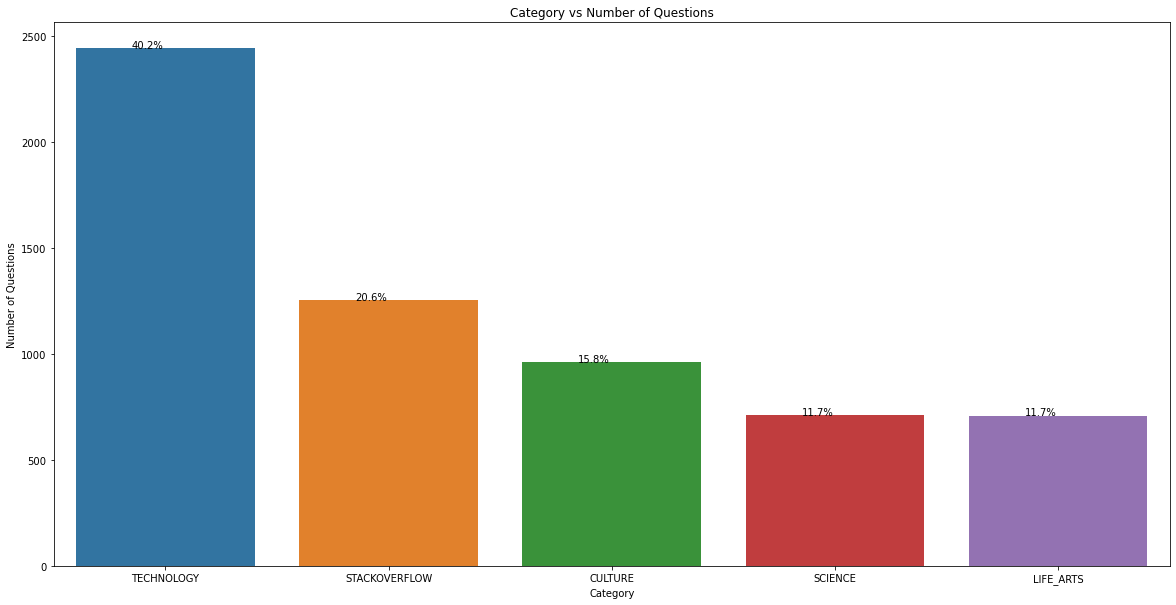

In [ ]:
#plot of category count 

plt.figure(figsize=(20,10))
ax = sns.countplot(train.category, order=train.category.value_counts().index)
plt.xlabel("Category")
plt.ylabel("Number of Questions")
plt.title("Category vs Number of Questions")

total = train.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

##### Maximum number of questions have category `TECHNOLOGY` which is 40.2% of total number of questions.
##### 20.6% of total questions are `STACKOVERFLOW`.
##### 15.6% questions falls under `CULTURE`.
##### `SCIENCE` and `LIFE_ARTS` are minimum with 11.7% each.

In [12]:
# preprocessing host name 

train['host'] = train['host'].apply(lambda x: x.split('.')[-2])

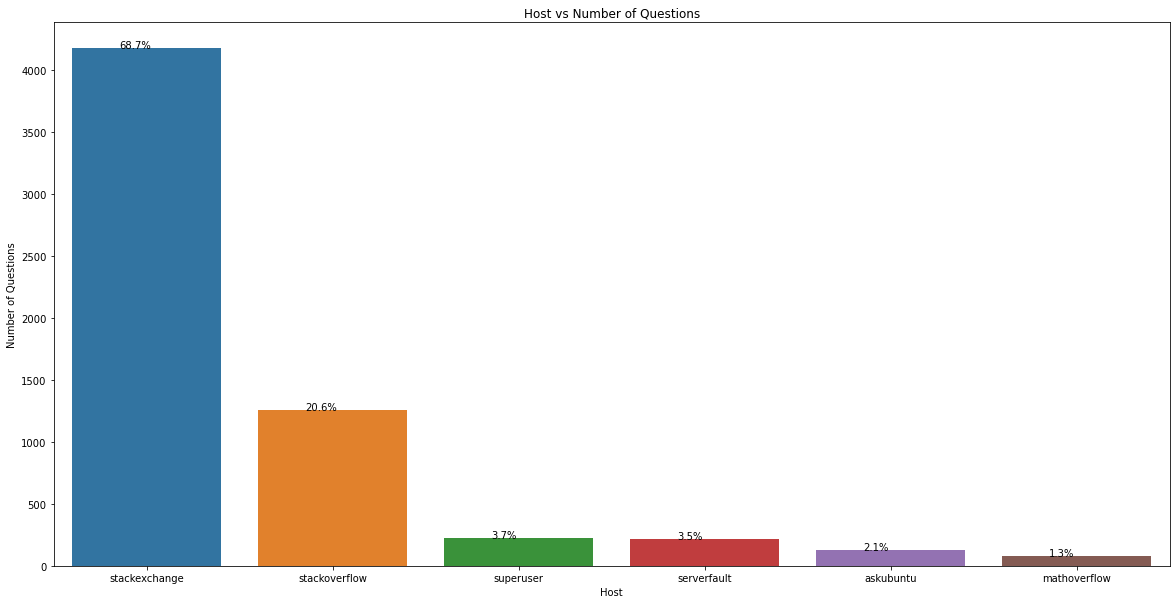

In [ ]:
#plot of host count 

plt.figure(figsize=(20,10))
ax = sns.countplot(train.host, order=train.host.value_counts().index)
plt.xlabel("Host")
plt.ylabel("Number of Questions")
plt.title("Host vs Number of Questions")

total = train.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

##### The above plot shows that `stackexchange` hosted maximum questions with 68.6% of total questions.
##### Host with 2nd highest number of questions is `stackoverflow`.
##### Other hosts are`superuser` with 3.7%, `serverfault` with 3.5%, `askubuntu` with 2.1% and `mathoverflow` 1.3%.

In [13]:
# taking length of question title, question body, answer
train['q_title_length'] = train['question_title'].apply(lambda x: len(x.split(' ')))
train['q_body_length'] = train['question_body'].apply(lambda x: len(x.split(' ')))
train['answer_length'] = train['answer'].apply(lambda x: len(x.split(' ')))
train.head()

qa_id                                     question_title  \
0      0  What am I losing when using extension tubes in...   
1      1  What is the distinction between a city and a s...   
2      2  Maximum protusion length for through-hole comp...   
3      3              Can an affidavit be used in Beit Din?   
4      5       How do you make a binary image in Photoshop?   

                                       question_body question_user_name  \
0  After playing around with macro photography on...               ysap   
1  I am trying to understand what kinds of places...      russellpierce   
2  I'm working on a PCB that has through-hole com...          Joe Baker   
3  An affidavit, from what i understand, is basic...         Scimonster   
4  I am trying to make a binary image. I want mor...            leigero   

                                  question_user_page  \
0         https://photo.stackexchange.com/users/1024   
1           https://rpg.stackexchange.com/users/8774   
2  https://electronics.stackexchange.com/users/10157   
3       https://judaism.stackexchange.com/users/5151   
4  https://graphicdesign.stackexchange.com/users/...   

                                              answer answer_user_name  \
0  I just got extension tubes, so here's the skin...           rfusca   
1  It might be helpful to look into the definitio...     Erik Schmidt   
2  Do you even need grooves?  We make several pro...      Dwayne Reid   
3  Sending an "affidavit" it is a dispute between...    Y     e     z   
4  Check out Image Trace in Adobe Illustrator. \n...             q2ra   

                                    answer_user_page  \
0         https://photo.stackexchange.com/users/1917   
1           https://rpg.stackexchange.com/users/1871   
2  https://electronics.stackexchange.com/users/64754   
3       https://judaism.stackexchange.com/users/4794   
4  https://graphicdesign.stackexchange.com/users/...   

                                                 url   category  ...  \
0  http://photo.stackexchange.com/questions/9169/...  LIFE_ARTS  ...   
1  http://rpg.stackexchange.com/questions/47820/w...    CULTURE  ...   
2  http://electronics.stackexchange.com/questions...    SCIENCE  ...   
3  http://judaism.stackexchange.com/questions/551...    CULTURE  ...   
4  http://graphicdesign.stackexchange.com/questio...  LIFE_ARTS  ...   

  answer_plausible  answer_relevance  answer_satisfaction  \
0         1.000000          1.000000             0.800000   
1         0.888889          0.888889             0.666667   
2         1.000000          1.000000             0.666667   
3         0.833333          1.000000             0.800000   
4         1.000000          1.000000             0.800000   

   answer_type_instructions  answer_type_procedure  \
0                       1.0               0.000000   
1                       0.0               0.000000   
2                       0.0               0.333333   
3                       0.0               0.000000   
4                       1.0               0.000000   

   answer_type_reason_explanation  answer_well_written  q_title_length  \
0                        0.000000             1.000000              13   
1                        0.666667             0.888889              16   
2                        1.000000             0.888889               7   
3                        1.000000             1.000000               8   
4                        1.000000             1.000000               9   

   q_body_length  answer_length  
0            139            149  
1            144             72  
2            117            188  
3             73            258  
4             80             24  

[5 rows x 44 columns]

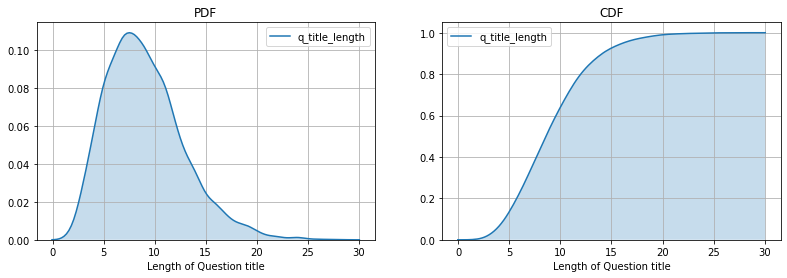

In [ ]:
# kde plot of length of question title
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_title_length'], shade=True, ax=ax1)
plt.xlabel('Length of Question title')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_title_length'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Length of Question title')
plt.title('CDF')
plt.grid()
plt.show()


##### In the PDF plot, it can be observed that maximum number of questions titles have length around 7 or 8.
##### CDF plot shows that 90% of questions have length less than 15

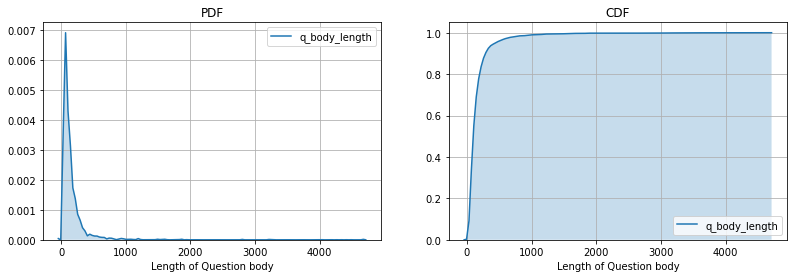

In [ ]:
# kde plot of length of question title
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_body_length'], shade=True, ax=ax1)
plt.xlabel('Length of Question body')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_body_length'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Length of Question body')
plt.grid()
plt.title('CDF')

plt.show()


##### In the PDF plot, it can be observed that almost all questions body have length less than 500. But there are few questions body with length around 1000.
##### CDF plot shows that more than 90% of questions have length less than 500

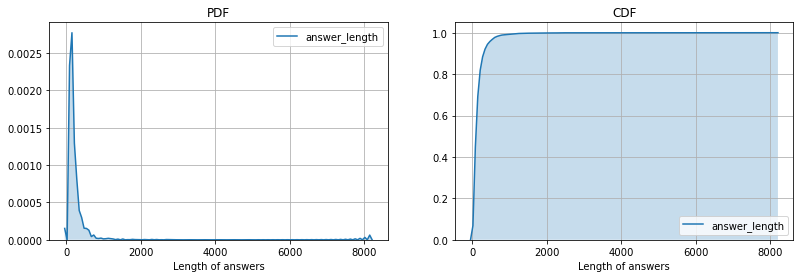

In [ ]:
# kde plot of length of question title
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['answer_length'], shade=True, ax=ax1)
plt.xlabel('Length of answers')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['answer_length'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Length of answers')
plt.grid()
plt.title('CDF')

plt.show()


##### In the PDF plot, it can be observed that almost all answersy have length less than 1000. But there are few questions body with length around 2000 and even 8000.
##### CDF plot shows that more than 90% of questions have length less than 1000.

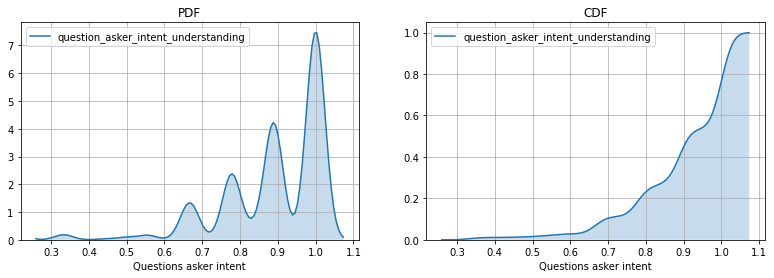

In [ ]:
# kde plot of question_asker_intent_understanding
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['question_asker_intent_understanding'], shade=True, ax=ax1)
plt.xlabel('Questions asker intent')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['question_asker_intent_understanding'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Questions asker intent')
plt.grid()
plt.title('CDF')

plt.show()


##### Around 25% of the questions have intent score less than 0.8 i.e. most of the question's intent are clear upto good extent.
##### Also maximum questions have intent score around 1 and 0.9

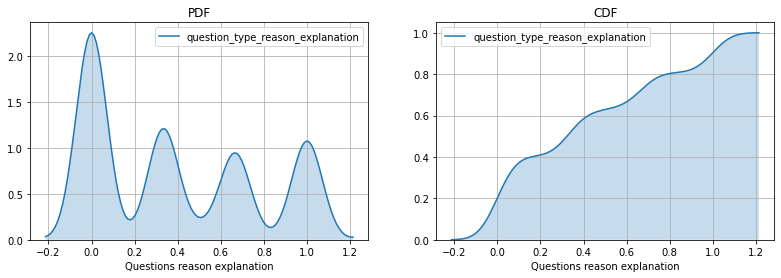

In [ ]:
# kde plot of question_type_reason_explanation
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['question_type_reason_explanation'], shade=True, ax=ax1)
plt.xlabel('Questions reason explanation')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['question_type_reason_explanation'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Questions reason explanation')
plt.grid()
plt.title('CDF')

plt.show()


##### Maximum questions type have reason explanation score 0.
##### 80% of the questions have reason explanation score less than 0.8

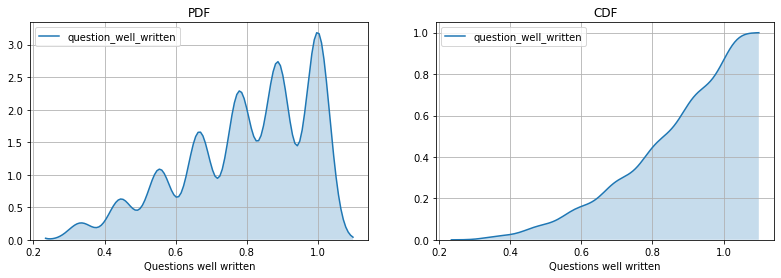

In [ ]:
# kde plot of question_well_written
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['question_well_written'], shade=True, ax=ax1)
plt.xlabel('Questions well written')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['question_well_written'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Questions well written')
plt.grid()
plt.title('CDF')

plt.show()


#### Plot shows that most of the questions are well written with score between 0.8 to 1

In [ ]:
# count of each score for "question_not_really_a_question"
train['question_not_really_a_question'].value_counts()

0.000000    6013
0.333333      48
0.500000      11
0.666667       4
1.000000       3
Name: question_not_really_a_question, dtype: int64

##### There are very few question who are not really a question. There are 3 questions having score 1

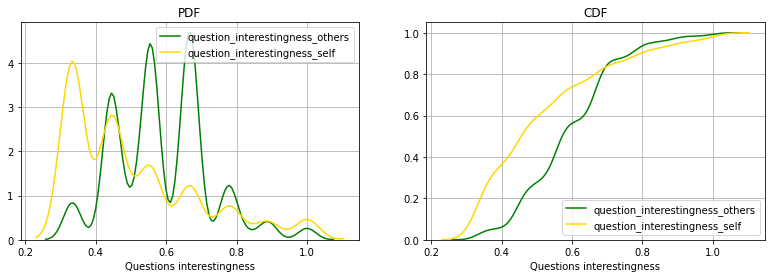

In [ ]:
# kde plot of question_interestingness_others
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['question_interestingness_others'],  ax=ax1, color='green')
sns.kdeplot(train['question_interestingness_self'], ax=ax1, color='gold')
plt.xlabel('Questions interestingness')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['question_interestingness_others'], cumulative=True, ax=ax2, color = 'green')
sns.kdeplot(train['question_interestingness_self'], cumulative=True, ax=ax2, color= 'gold')
plt.xlabel('Questions interestingness')
plt.grid()
plt.title('CDF')

plt.show()


##### Most of  the questions have high score for question_interestingness_others, than question_interestingness_self  scores. That means most of the questions are more interesting to others

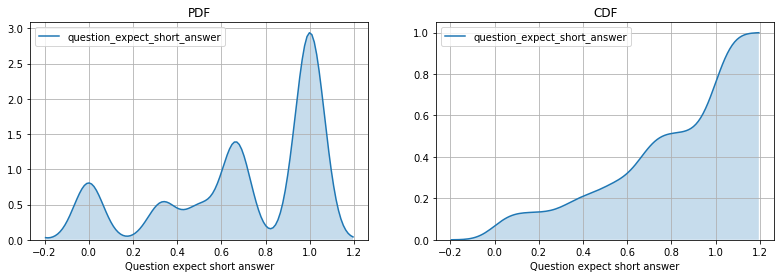

In [ ]:
# kde plot of Question expect short answer
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['question_expect_short_answer'], shade=True, ax=ax1)
plt.xlabel('Question expect short answer')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['question_expect_short_answer'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Question expect short answer')
plt.grid()
plt.title('CDF')

plt.show()


##### 50% of the question_asker_intent_understanding have value less than 0.8, but most of the questions have value 1. There are few questions with value 0.

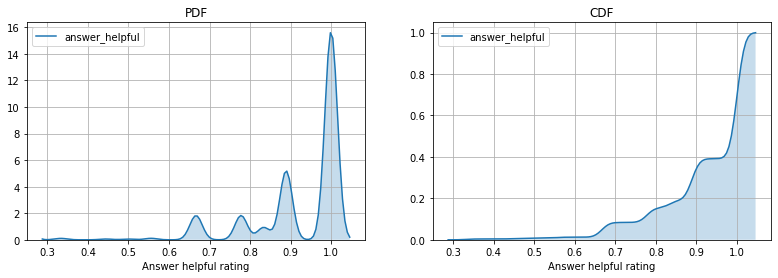

In [ ]:
# kde plot of answer_helpful
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['answer_helpful'], shade=True, ax=ax1)
plt.xlabel('Answer helpful rating')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['answer_helpful'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer helpful rating')
plt.grid()
plt.title('CDF')

plt.show()


##### From the above plots, it can be said that most of the answers have helpful score 1. 
##### Around 35% of the answers have answer_helpful score less than 0.9

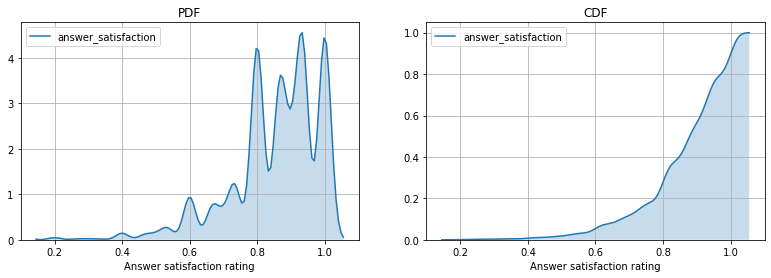

In [ ]:
# kde plot of answer_satisfaction
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['answer_satisfaction'], shade=True, ax=ax1)
plt.xlabel('Answer satisfaction rating')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['answer_satisfaction'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer satisfaction rating')
plt.grid()
plt.title('CDF')

plt.show()


##### Only 30% of the answers have answer_satisfaction score less than 0.8.  Most of the answers have score between 0.8 to 1. So maximum number of answers are satisfactory. 

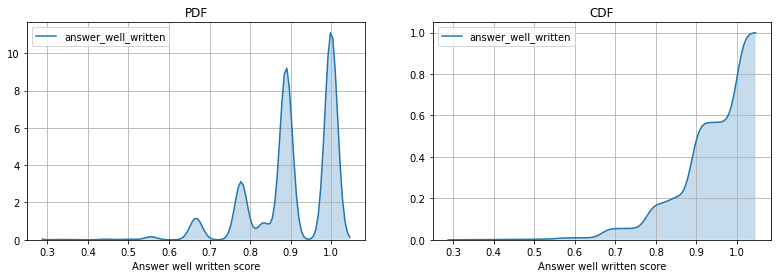

In [ ]:
# kde plot of answer_well_written
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['answer_well_written'], shade=True, ax=ax1)
plt.xlabel('Answer well written score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['answer_well_written'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer well written score')
plt.grid()
plt.title('CDF')

plt.show()


##### Most of the questions have well written score of 0.9 and 1.
##### Only around 18% of the questions have well written score less than 0.8

Text(0.5, 1.0, "Category vs Question asker's intent")

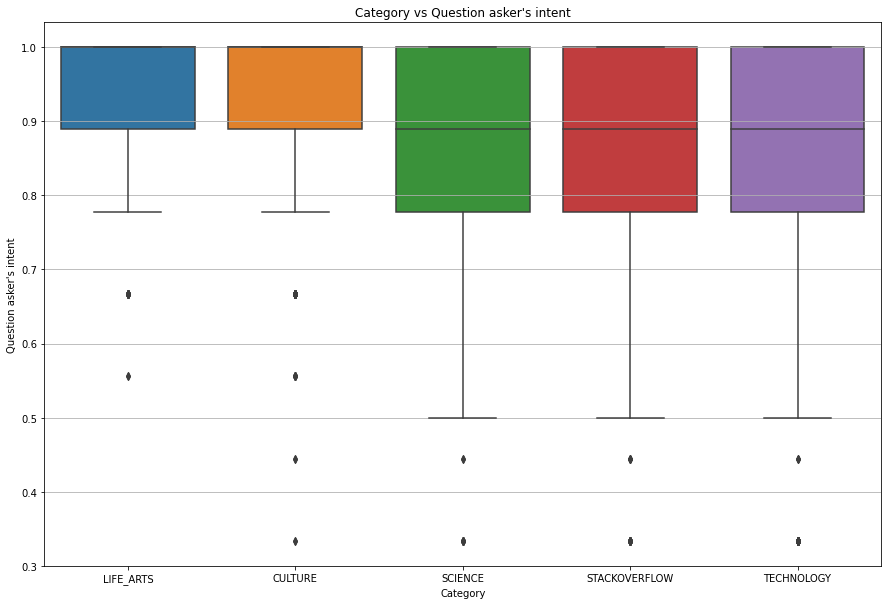

In [ ]:
# BoxPlot of question_asker_intent_understanding
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_asker_intent_understanding,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("Question asker's intent")
plt.title("Category vs Question asker's intent")

Most of the `life_arts` category questions have a good understanding of question asker's intent with a score between 0.8 to 1.

`culture` category questions also have the same scores as `life_arts`

Categories `science, stackoverflow, technology` have 75% of the questions asker's intent score between 0.78 to 1, but there are still 25% questions with score between 0.3 to 0.75.

Text(0.5, 1.0, 'Category vs Conversational Questions')

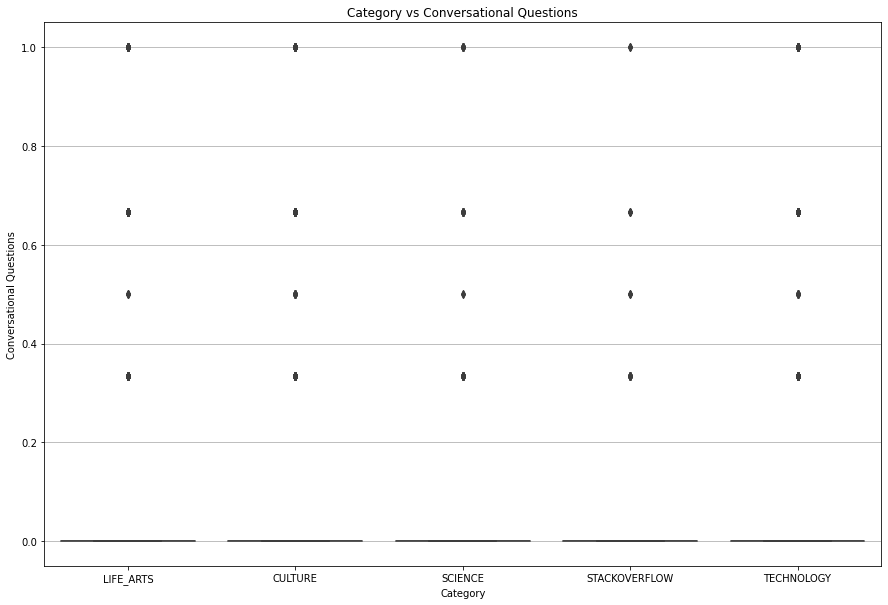

In [ ]:
# BoxPlot of question_body_critical
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_conversational,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("Conversational Questions")
plt.title("Category vs Conversational Questions")

##### Can't get enough info out of above plot

Text(0.5, 1.0, 'Category vs Questionsexpect short answers')

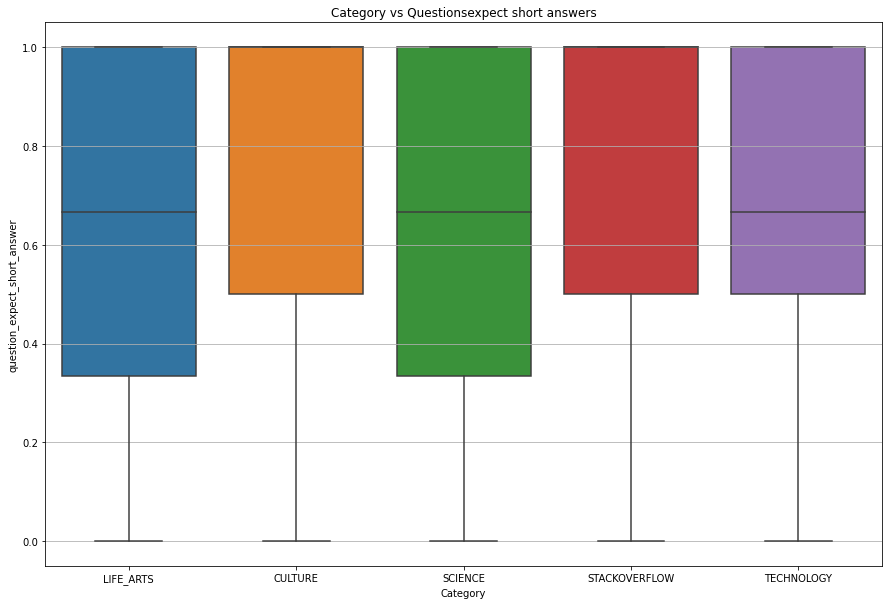

In [ ]:
# BoxPlot of question_expect_short_answer
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_expect_short_answer,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("question_expect_short_answer")
plt.title("Category vs Questionsexpect short answers")

##### From above plot, it can be said that mostly questions under categories `culture, stackoverflow, technology` expects short answers.

Text(0.5, 1.0, 'Category vs Questions interesting to others')

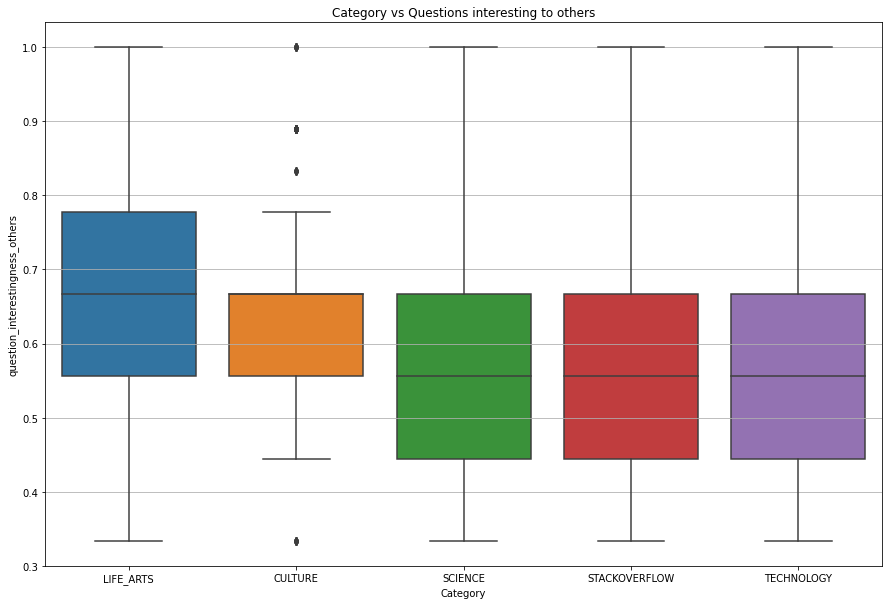

In [ ]:
# BoxPlot of question_interestingness_others
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_interestingness_others,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("question_interestingness_others")
plt.title("Category vs Questions interesting to others")

##### It seems `'life_arts` category questions are more interesting to others than other categories

Text(0.5, 1.0, 'Category vs question_interestingness_self')

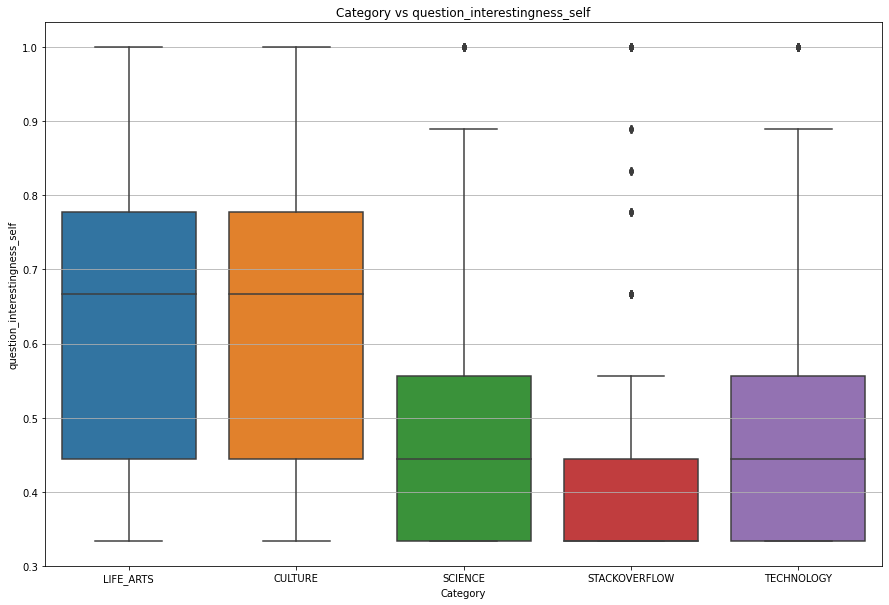

In [ ]:
# BoxPlot of question_interestingness_self
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_interestingness_self,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("question_interestingness_self")
plt.title("Category vs question_interestingness_self")

Categories `life_arts` and `culture` have higher score for `question_interestingness_self` than others.

`stackoverflow` have the lowest scores

Text(0.5, 1.0, 'Category vs question_well_written')

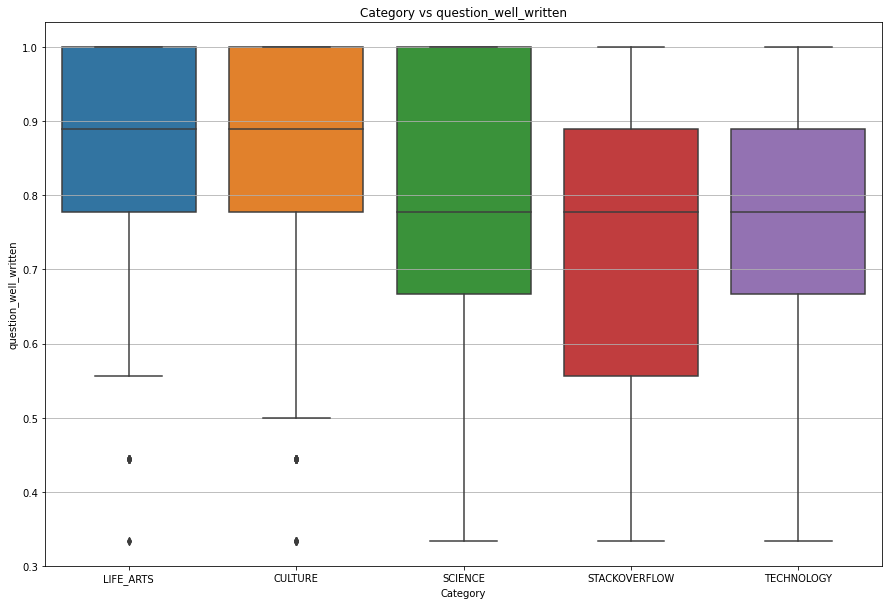

In [ ]:
# BoxPlot of question_well_written
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.question_well_written,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("question_well_written")
plt.title("Category vs question_well_written")

`life_arts` and `culture` have more well written questions  than other categories. 
`science` also has well written questions compared to `stackoverflow` and `technology`

Text(0.5, 1.0, 'Category vs answer_well_written')

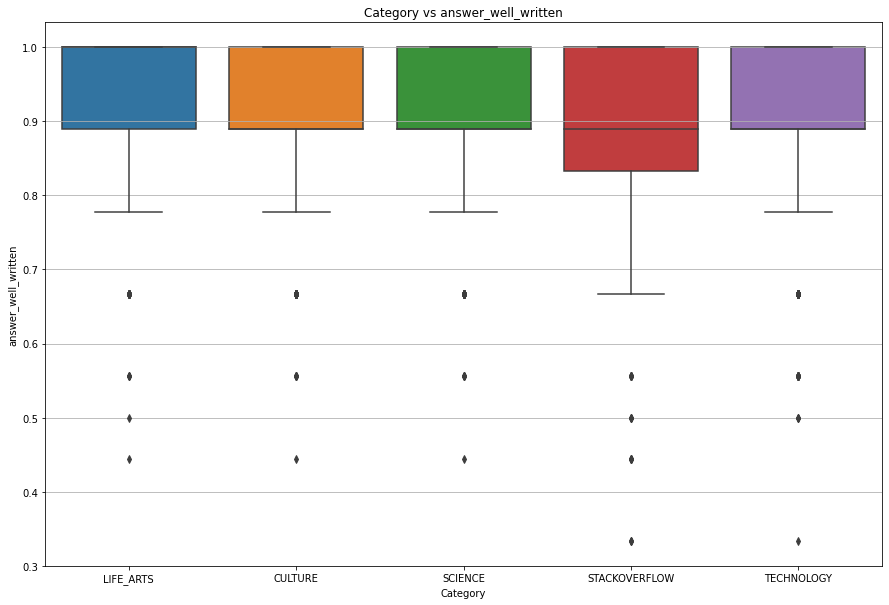

In [ ]:
# BoxPlot of answer_well_written
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.answer_well_written,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("answer_well_written")
plt.title("Category vs answer_well_written")

Answers of all categories are well written except for few outliers with value less than 0.5.
`stackoverflow` have some answers with well written score less compared to others 

Text(0.5, 1.0, 'Category vs answer_satisfaction')

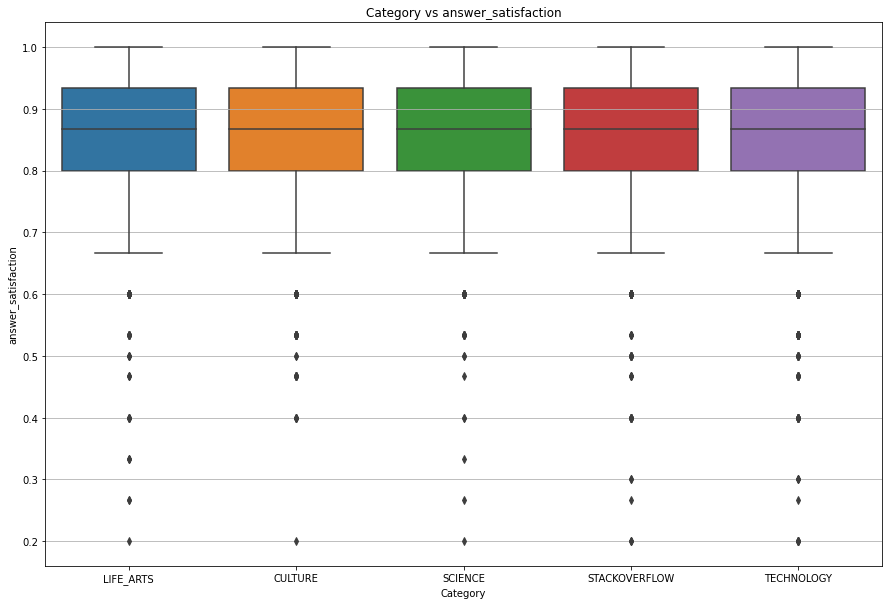

In [ ]:
# BoxPlot of answer_satisfaction
plt.figure(figsize=(15,10))
plt.grid()
sns.boxplot(y=train.answer_satisfaction,x=train.category, orient='v')
plt.xlabel("Category")
plt.ylabel("answer_satisfaction")
plt.title("Category vs answer_satisfaction")

So all the categories have more or less equal answer satisfaction scores.

In [8]:
# function to plot distribution of class-labels for each of 5 category
def dist_plot_category(class_labels,column_name):
    colours = ['r','g','b','m','y']
    fig = plt.figure(figsize=(35,35))
    for cat,color in zip(set(train[column_name]),colours):
        #plt.colorbar()
        
        i=1
        for col in class_labels:
            fig.add_subplot(6,5,i)
            sns.distplot(train[train['category']==cat][col],color=color,hist=False)
            
            i+=1
        

Text(0.5, 1.0, 'Distribution of each class label for each category')

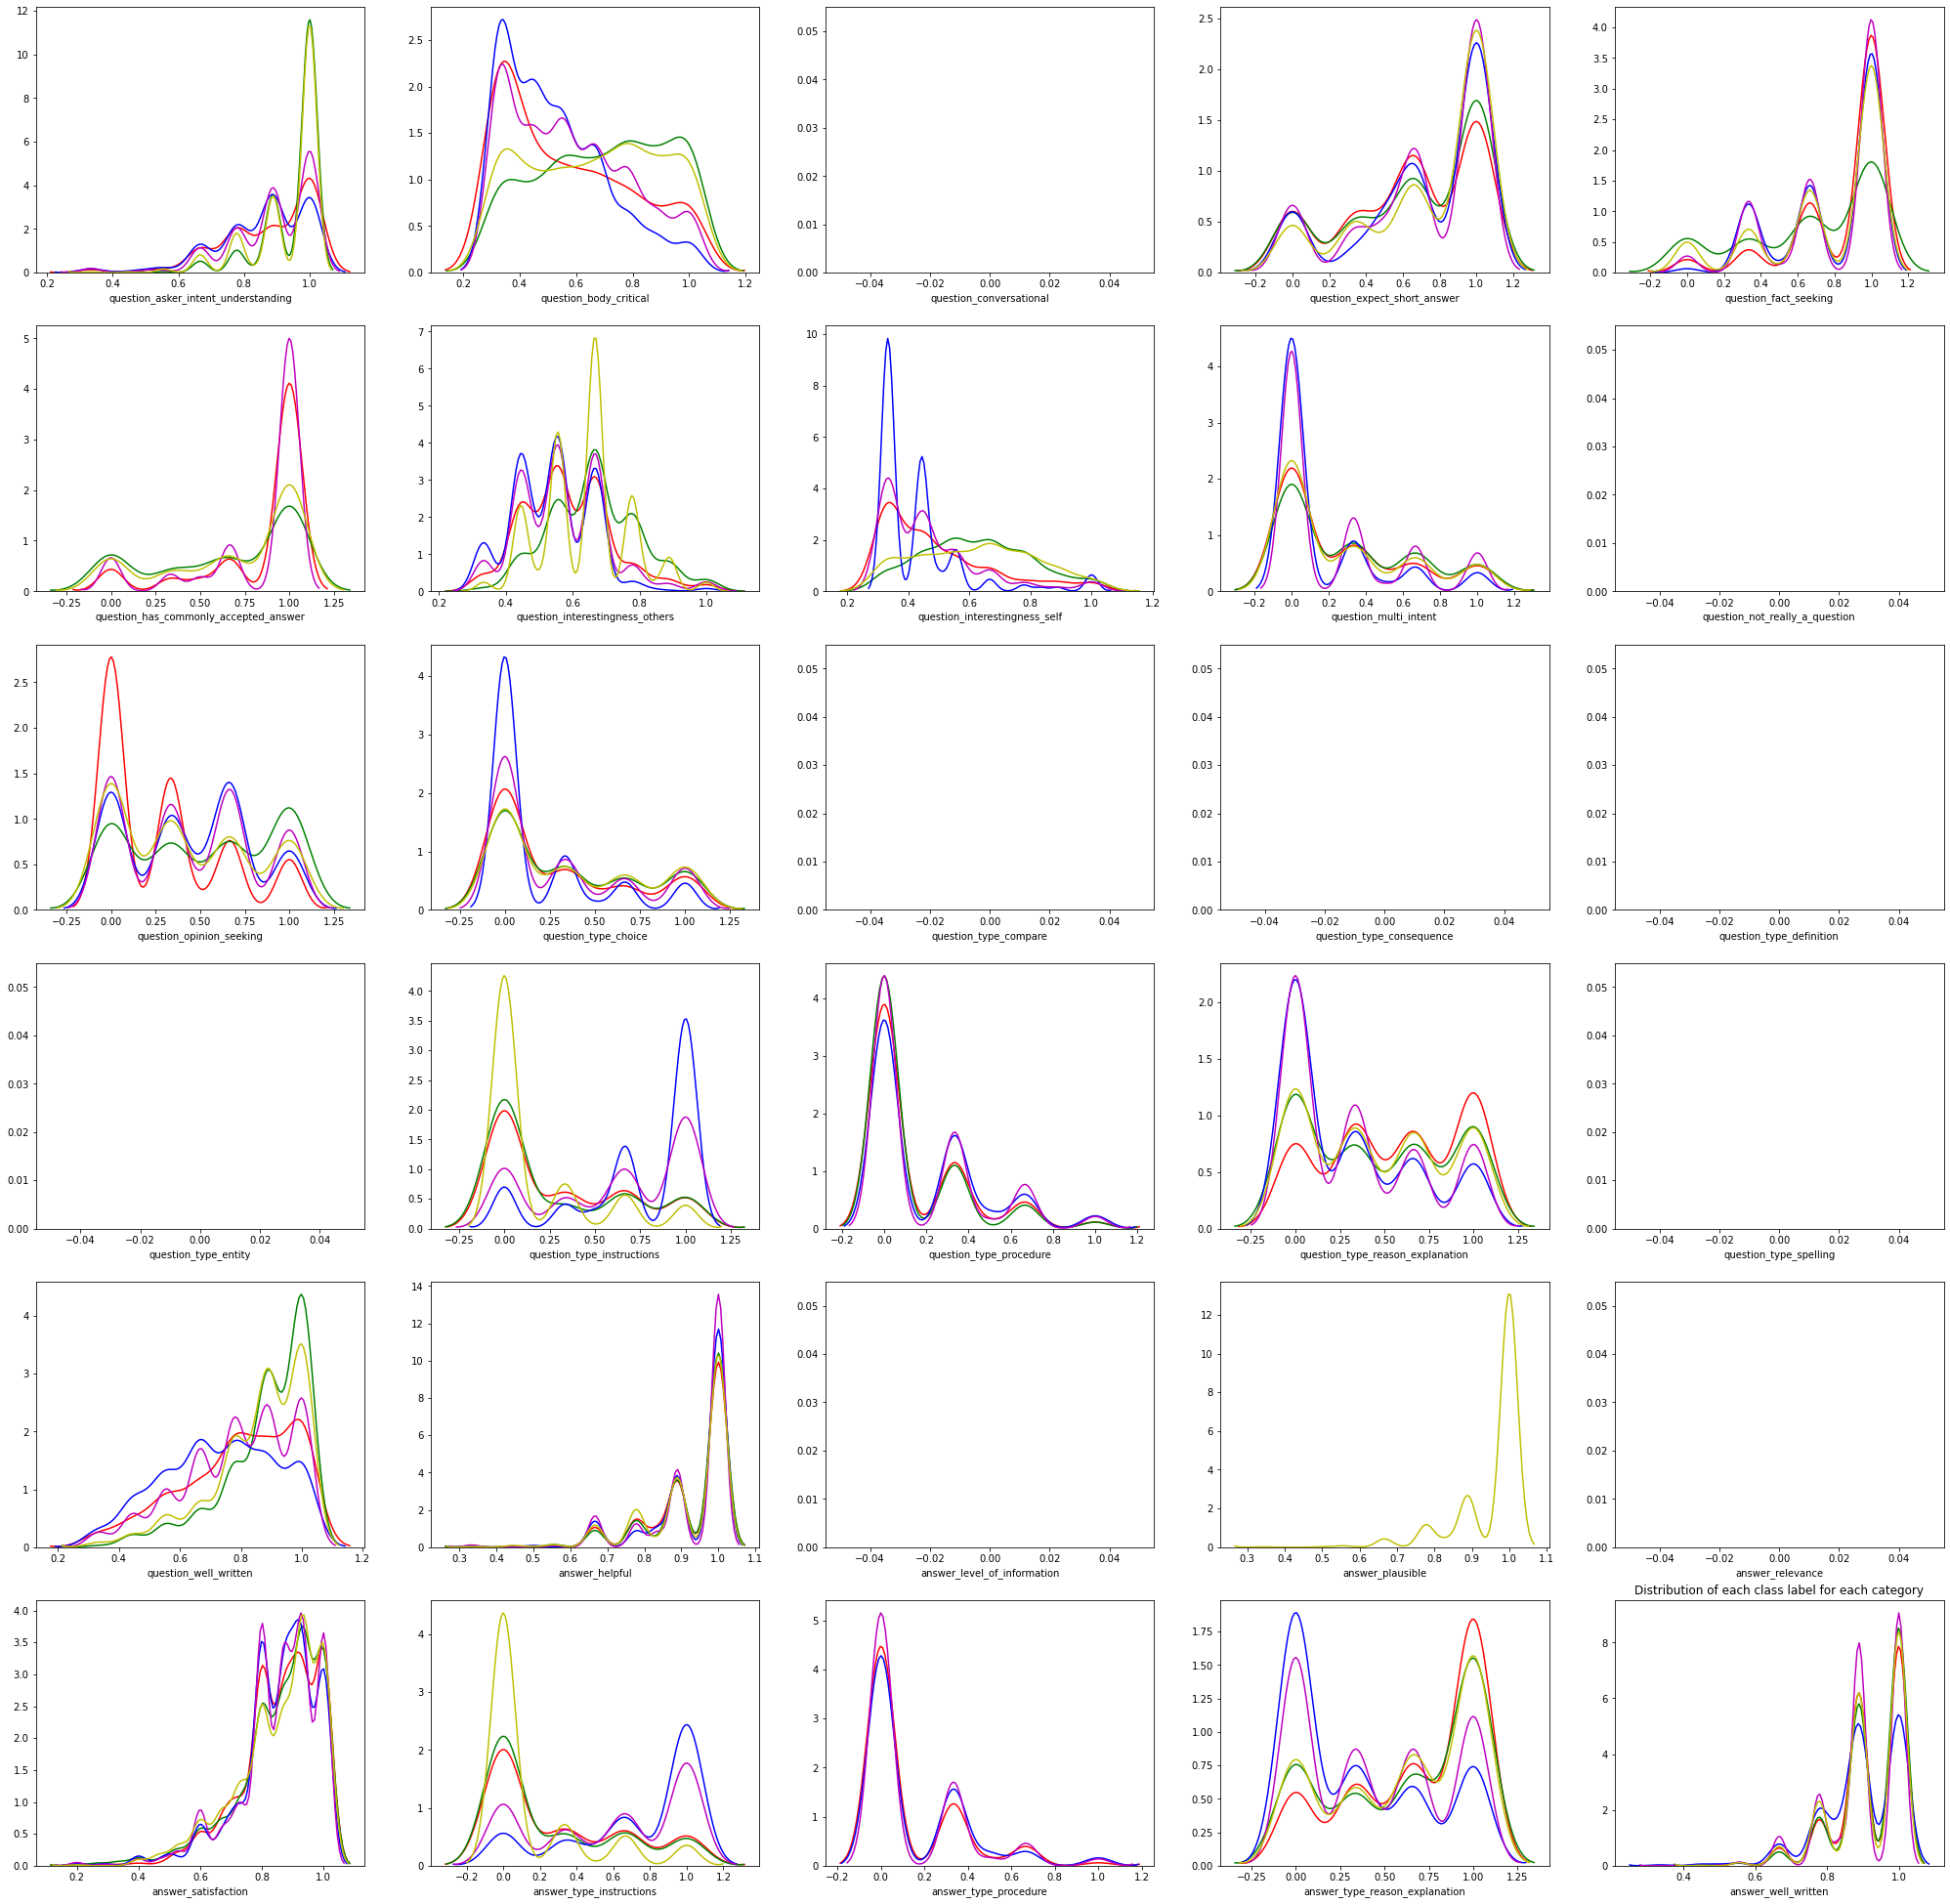

In [12]:
warnings.filterwarnings("ignore")
dist_plot_category(class_labels=class_labels,column_name='category')
plt.title("Distribution of each class label for each category")

In [13]:
# function to plot distribution of class-labels
def dist_plot(class_labels, filter_col, filter_value,color='green'):
    fig = plt.figure(figsize=(35,35))
    i=1
    j=1
    for col in class_labels:
        fig.add_subplot(6,5,i)
        sns.distplot(train[train[filter_col]==filter_value][col],color=color)
        i+=1
        

Text(0.5, 1.0, "Distribution of each class label for category 'LIFE_ARTS'")

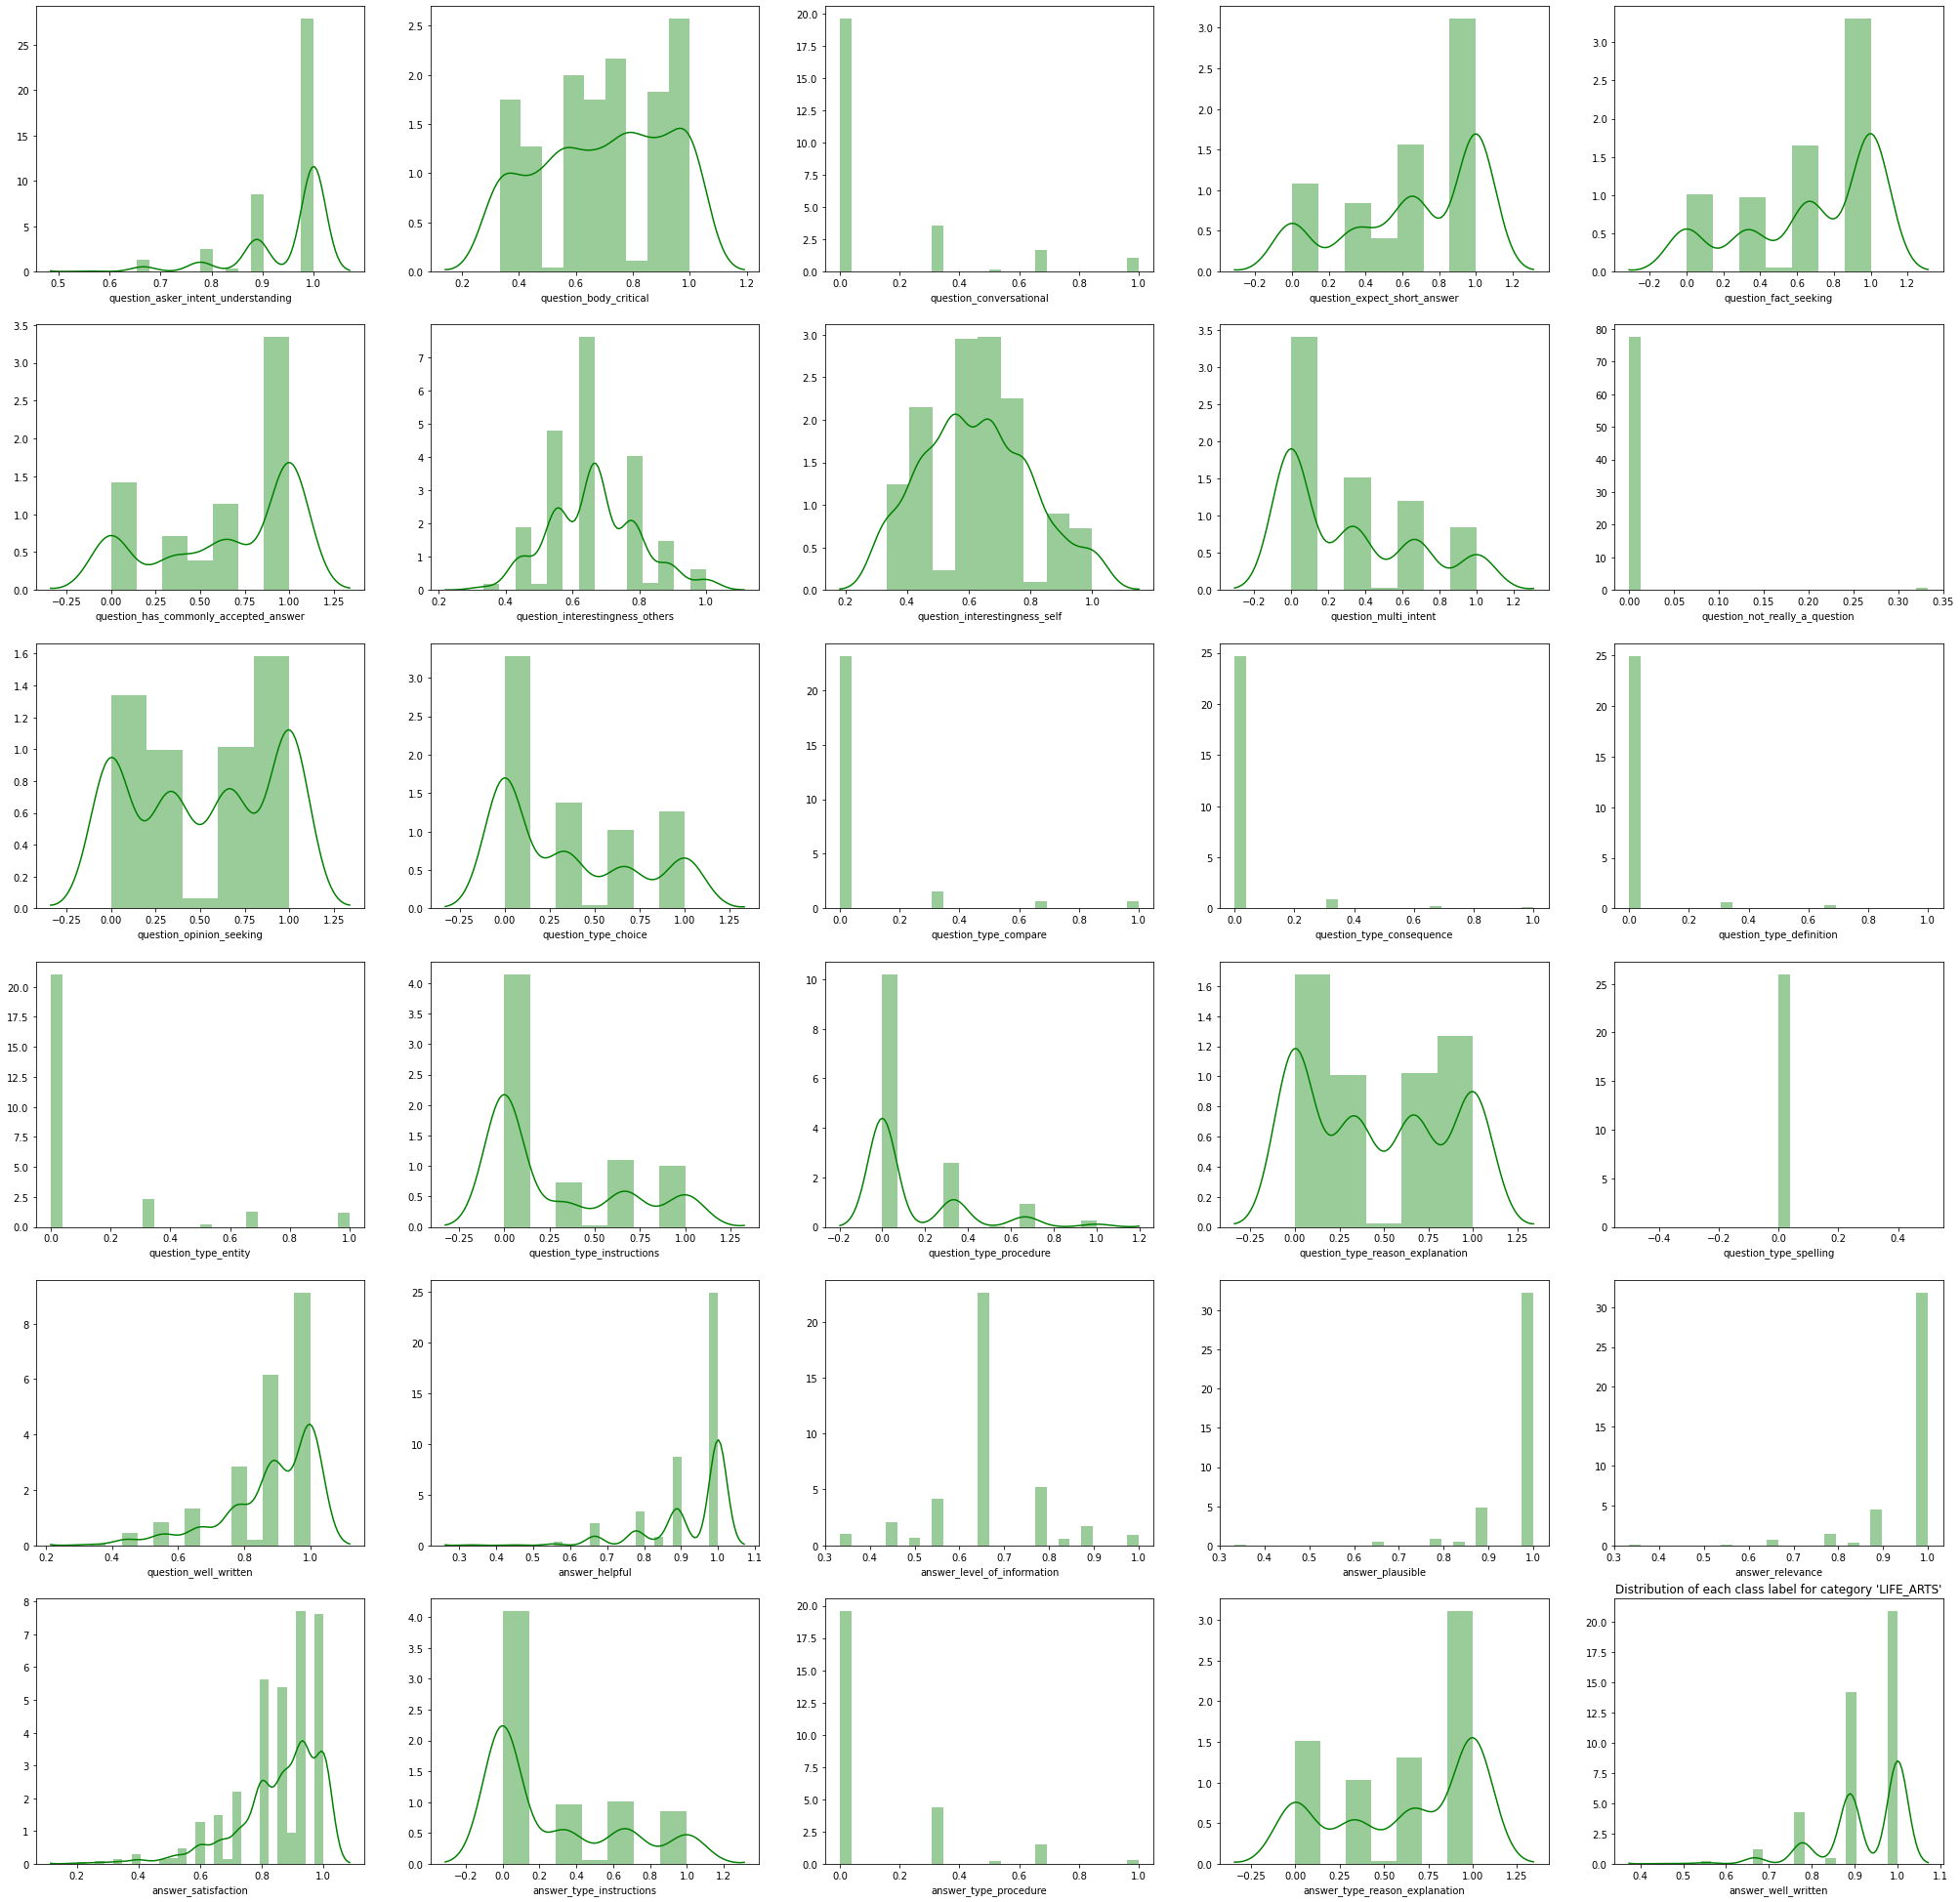

In [14]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='category',filter_value='LIFE_ARTS')
plt.title("Distribution of each class label for category 'LIFE_ARTS'")

Text(0.5, 1.0, "Distribution of each class label for category 'CULTURE'")

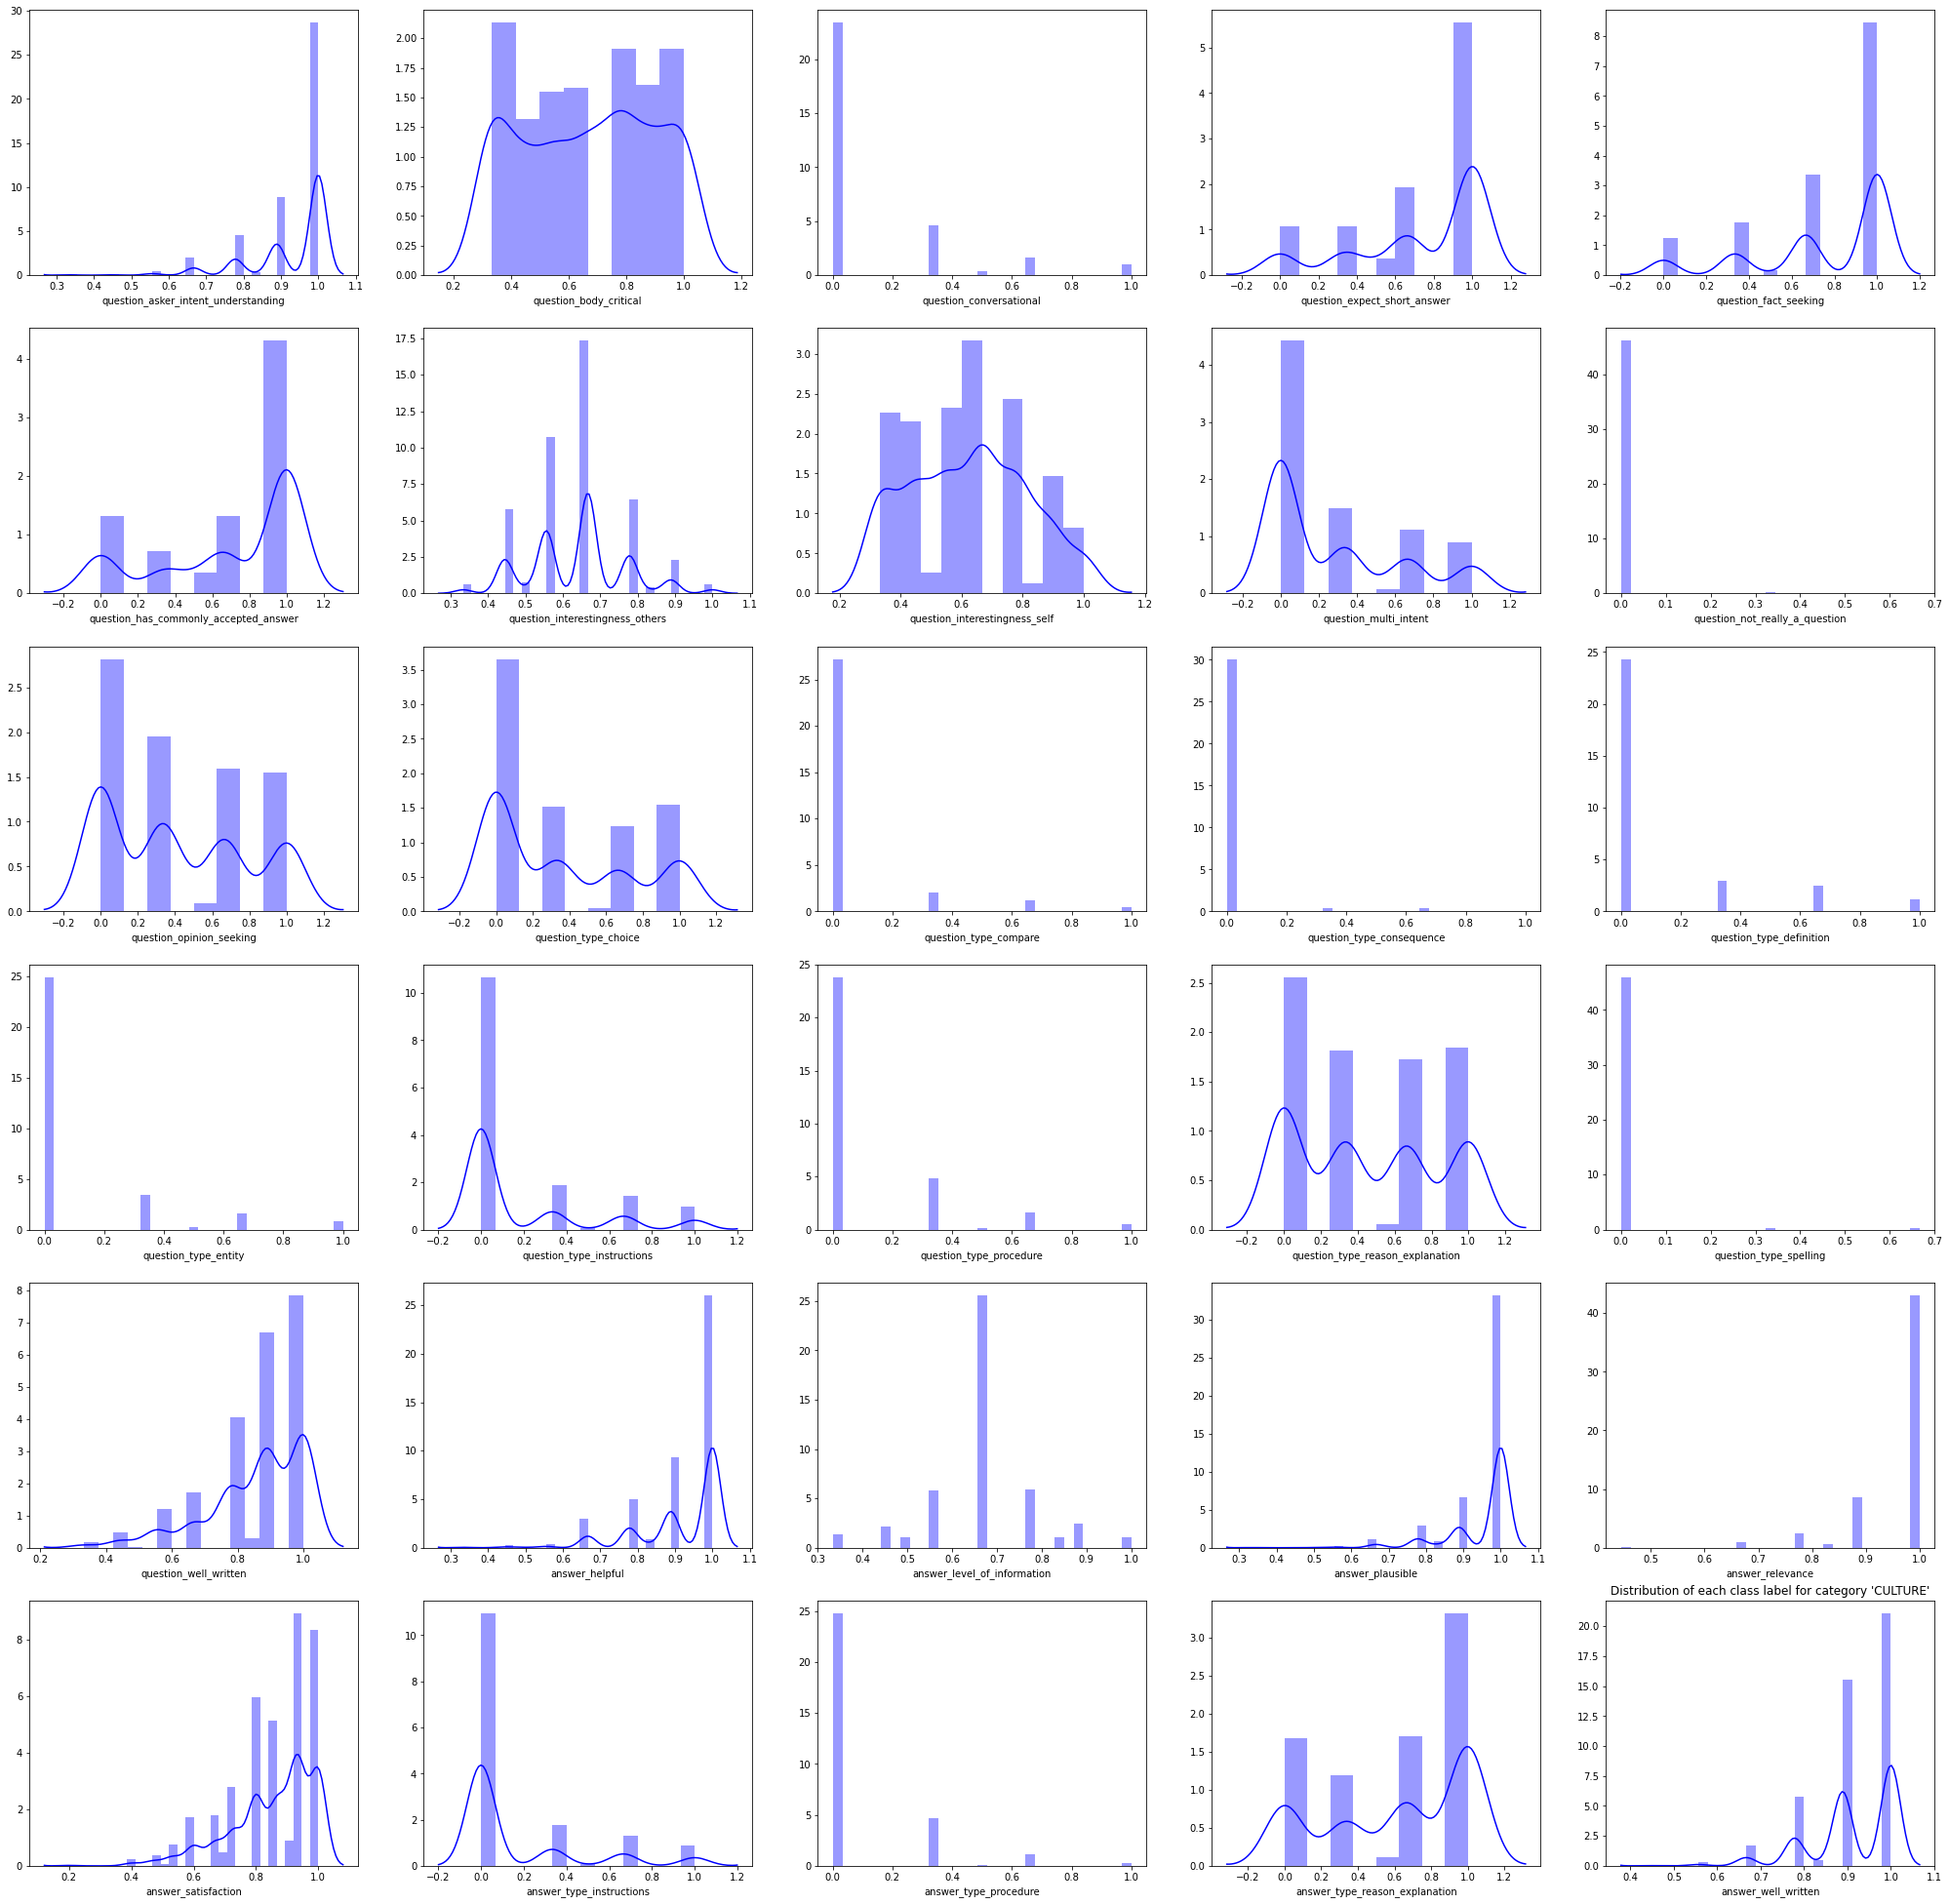

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='category',filter_value='CULTURE',color='blue')
plt.title("Distribution of each class label for category 'CULTURE'")

Text(0.5, 1.0, "Distribution of each class label for category 'SCIENCE'")

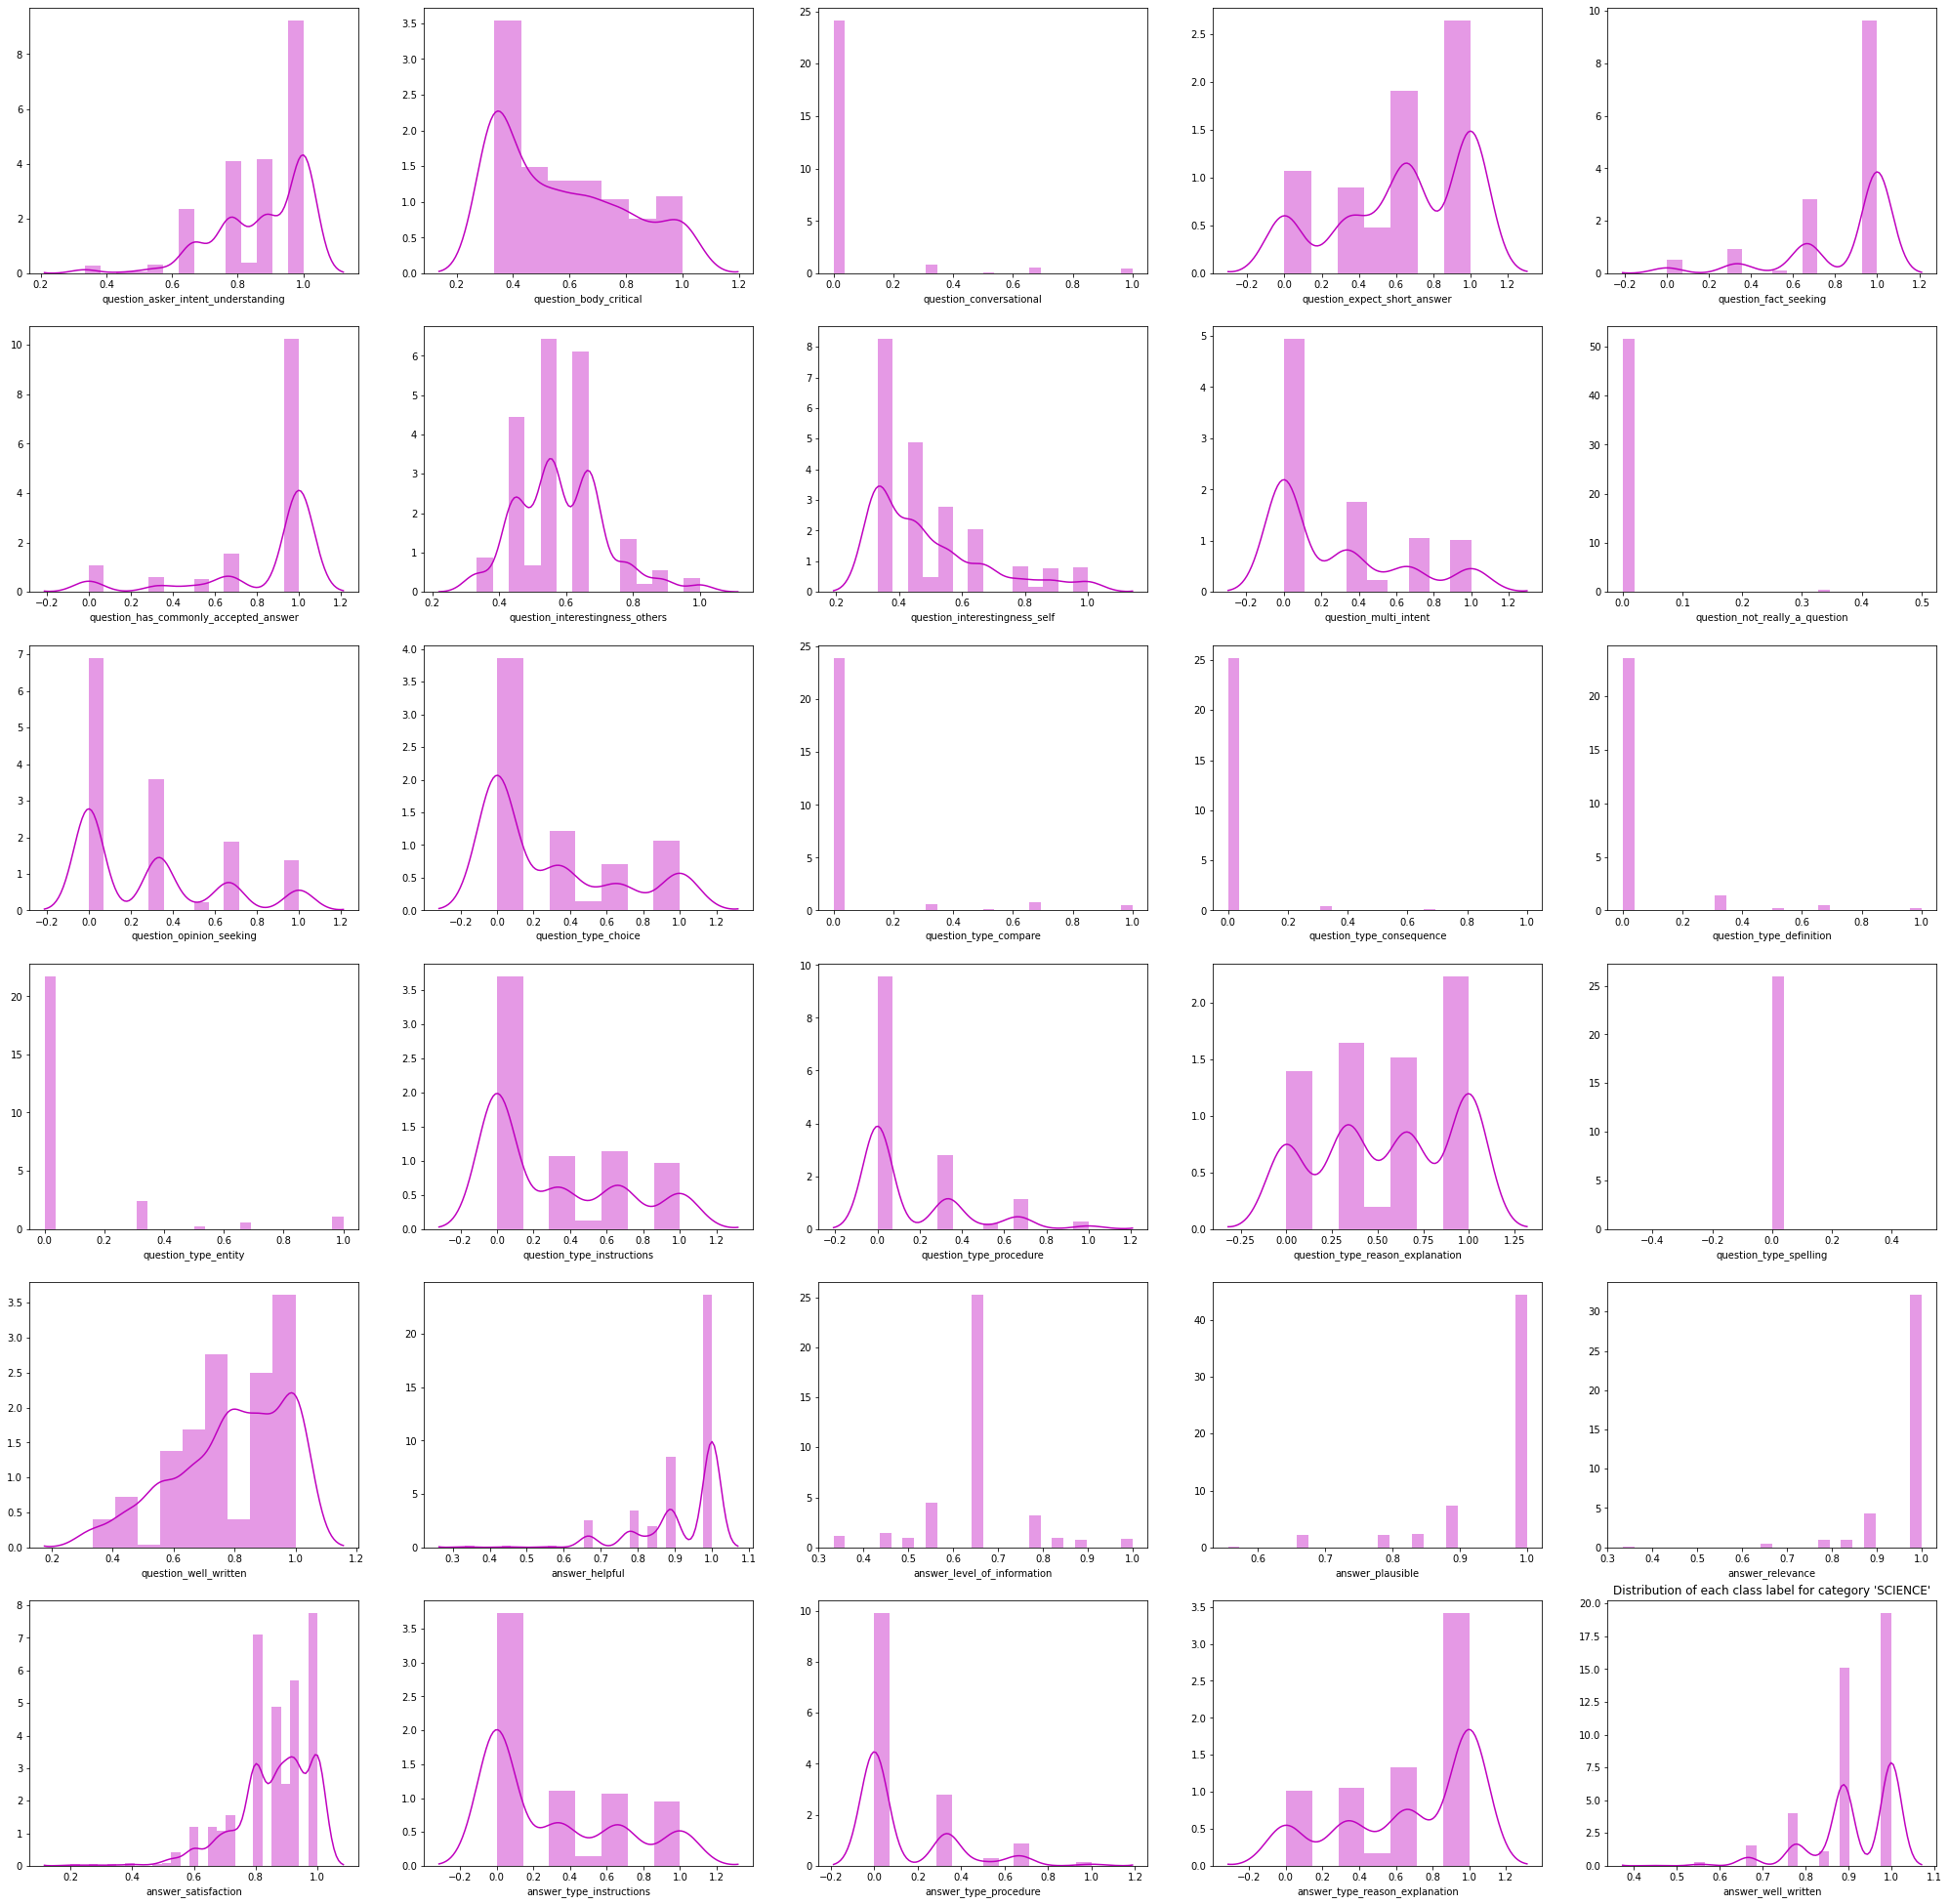

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='category',filter_value='SCIENCE',color='m')
plt.title("Distribution of each class label for category 'SCIENCE'")

Text(0.5, 1.0, "Distribution of each class label for category 'STACKOVERFLOW'")

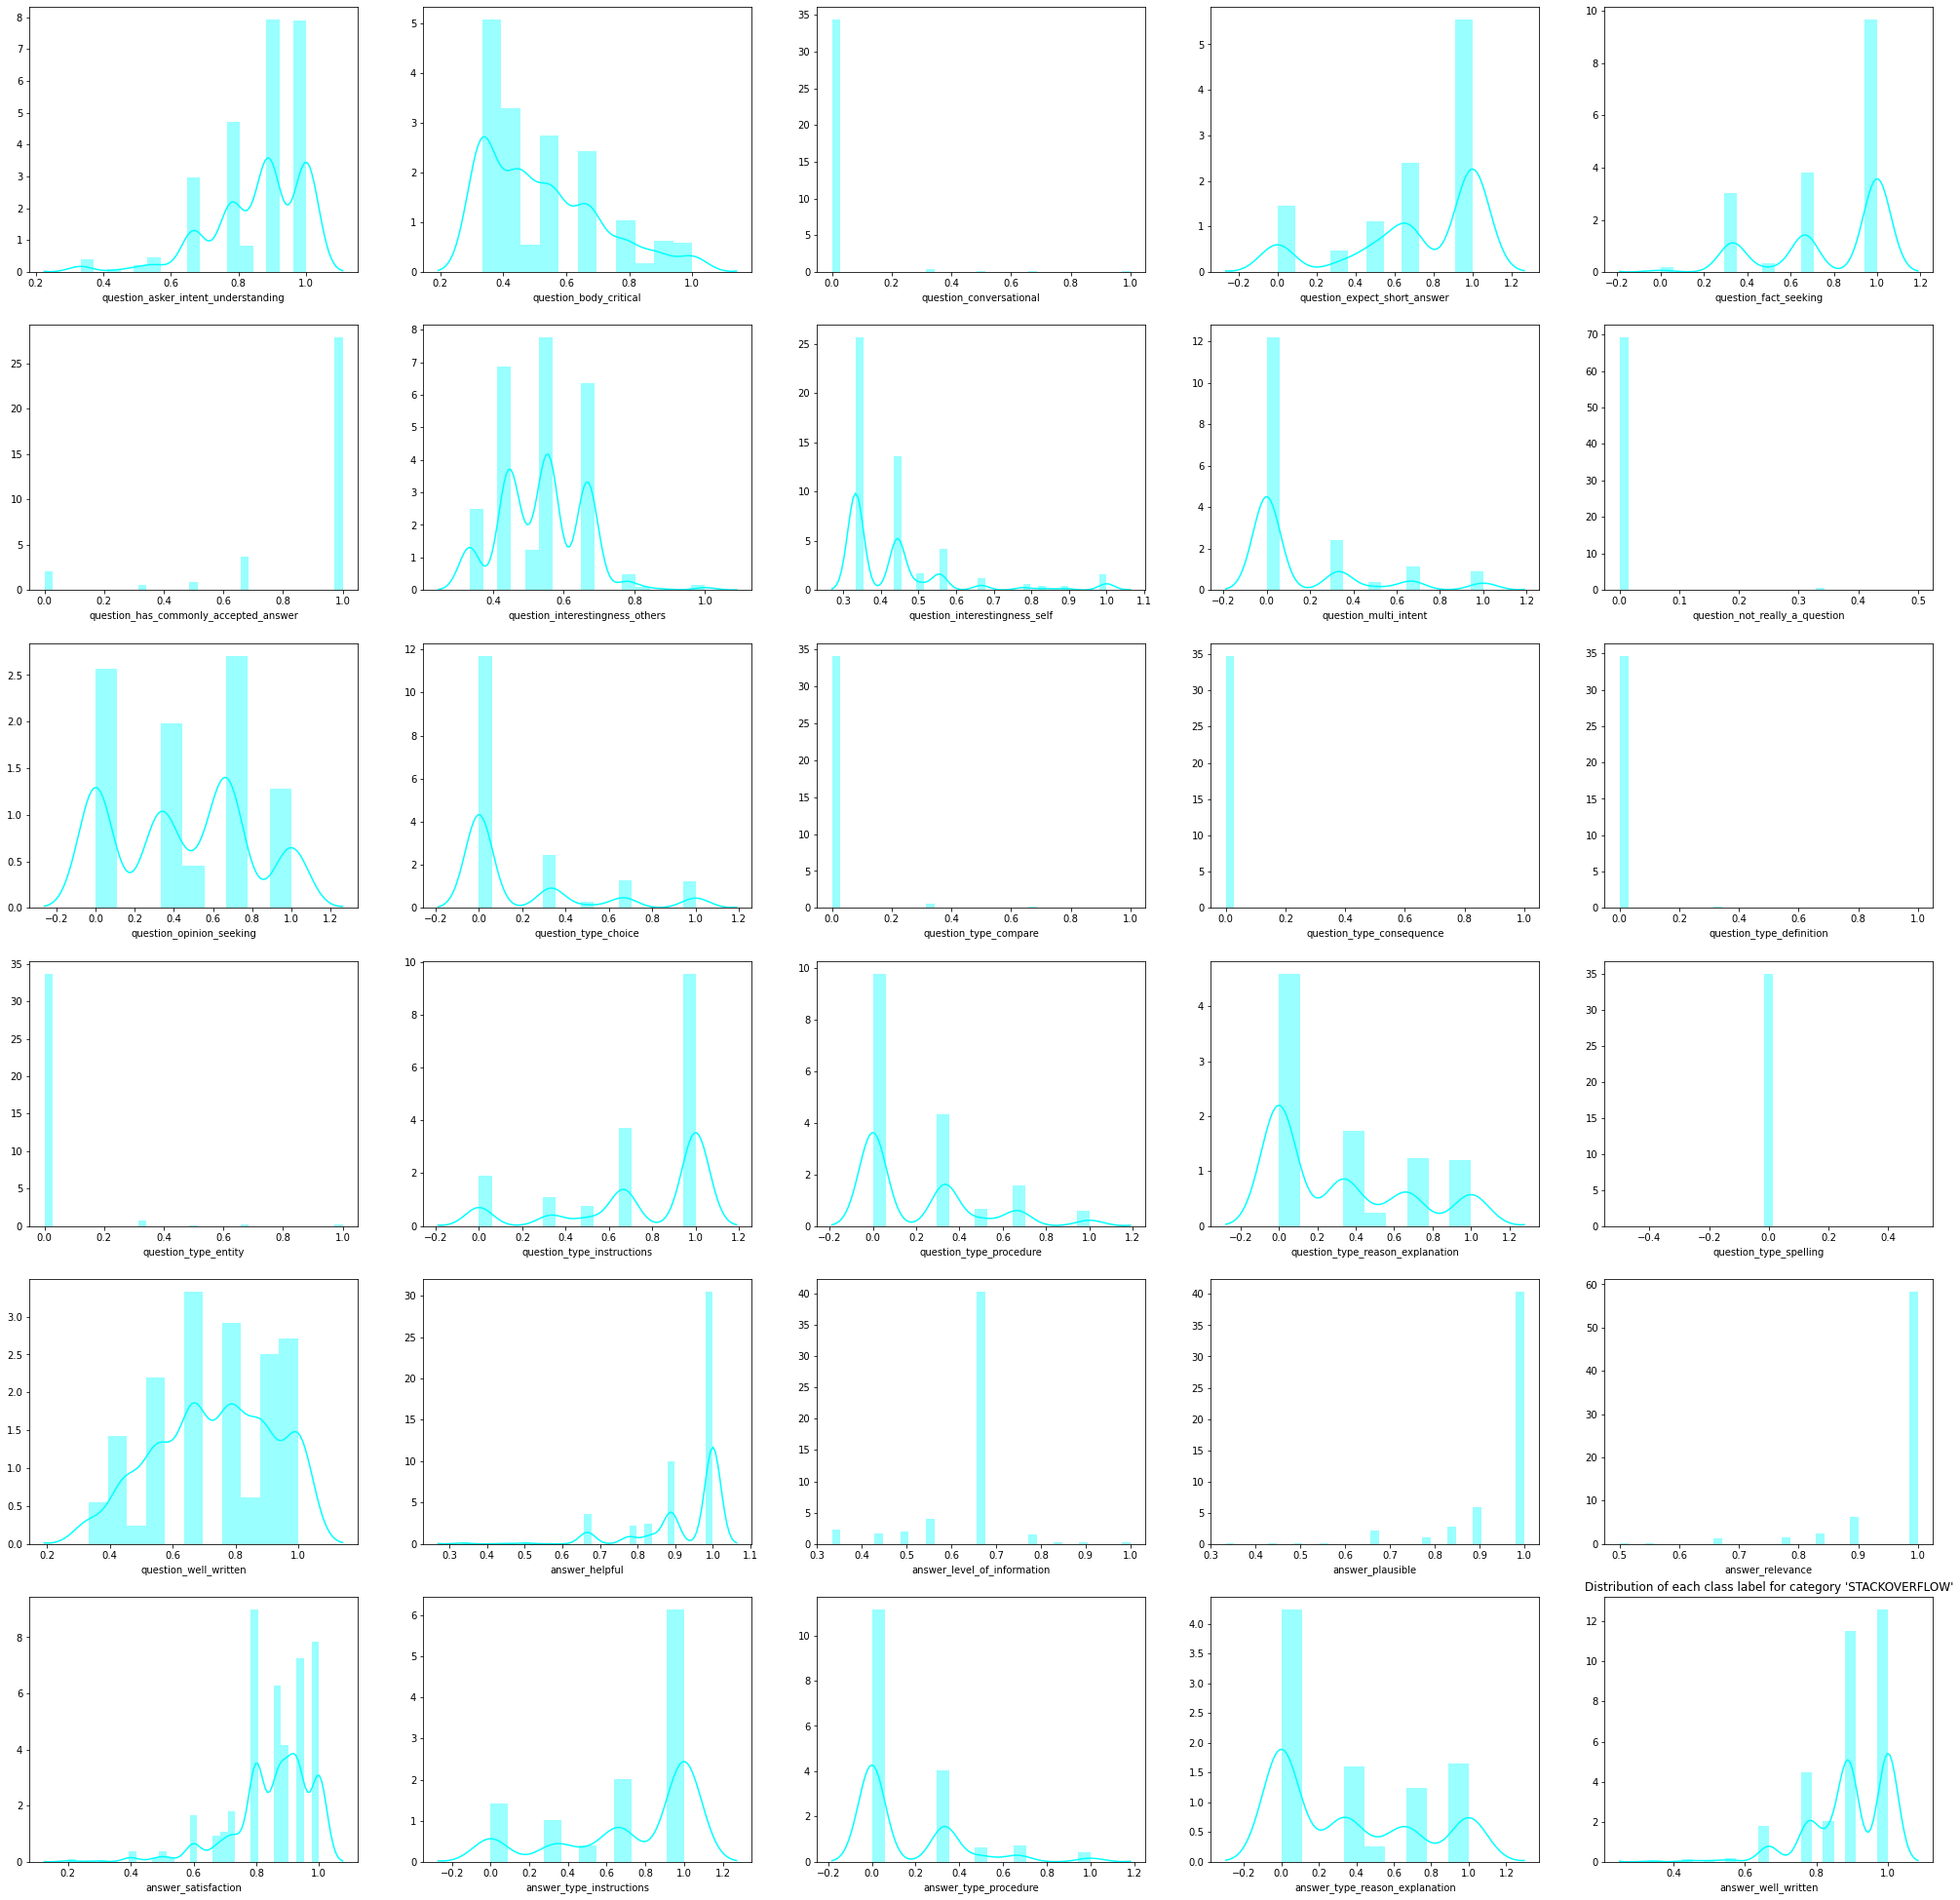

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='category',filter_value='STACKOVERFLOW',color='cyan')
plt.title("Distribution of each class label for category 'STACKOVERFLOW'")

Text(0.5, 1.0, "Distribution of each class label for category 'TECHNOLOGY'")

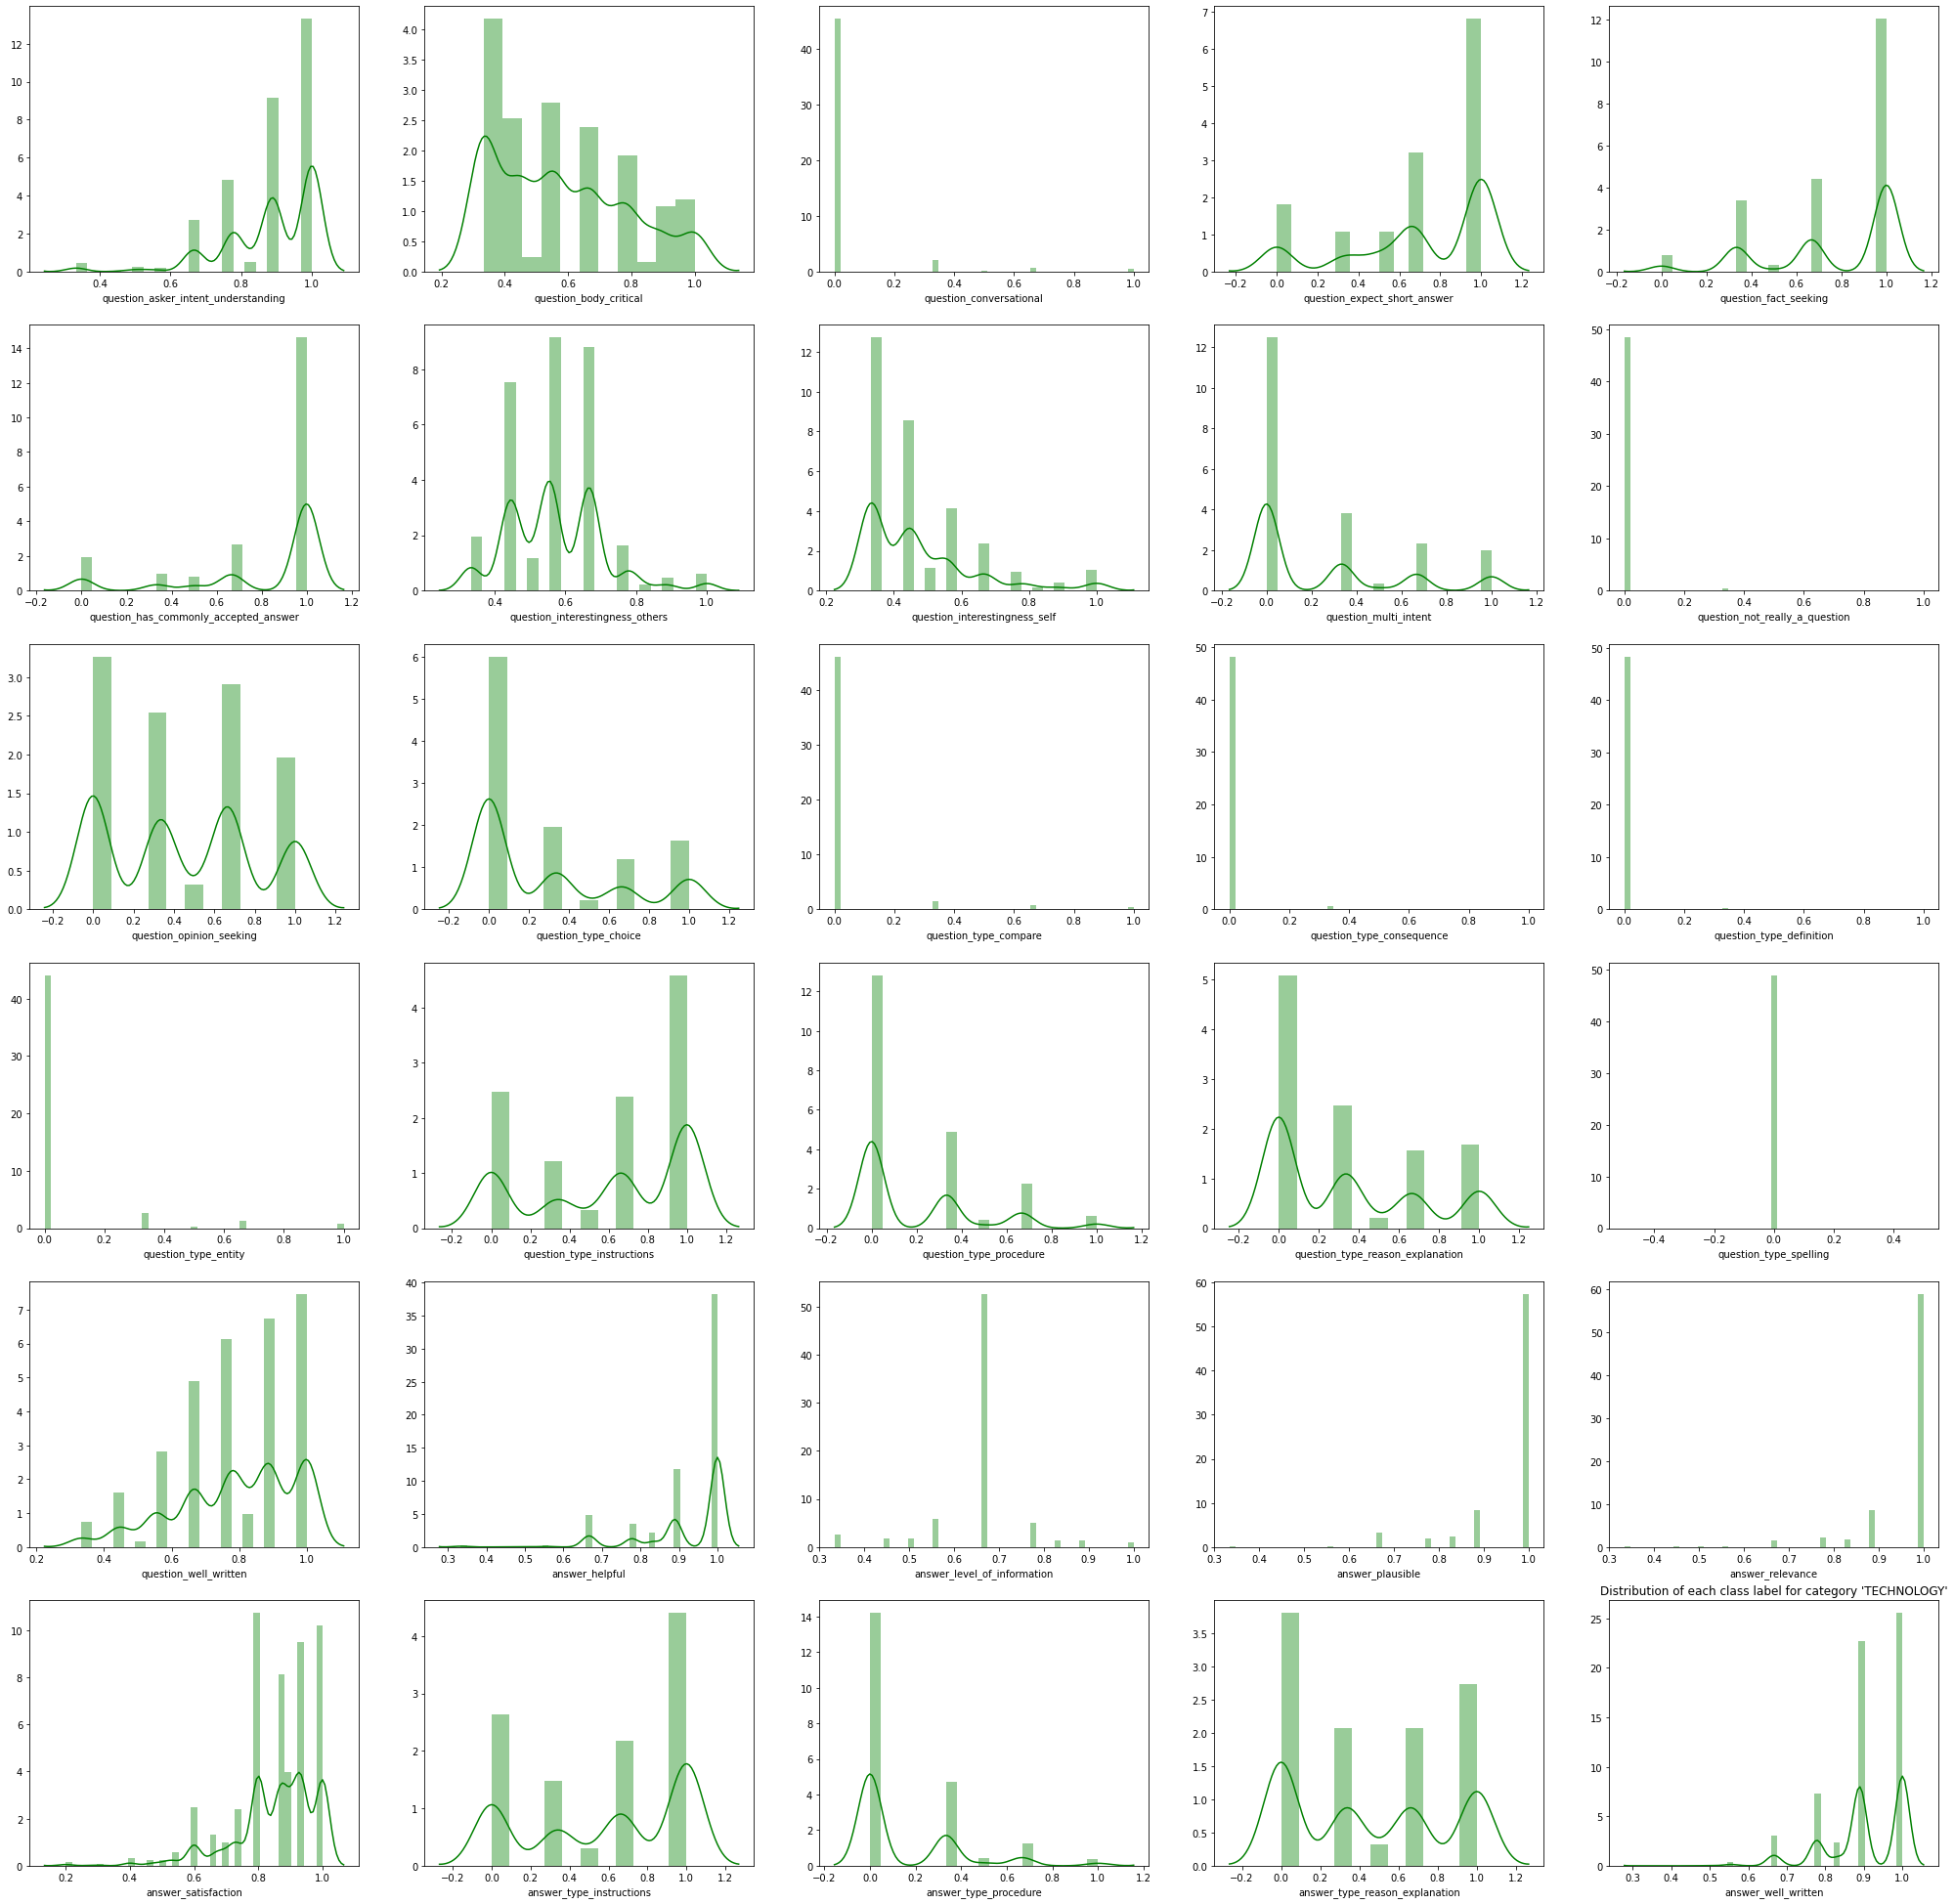

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='category',filter_value='TECHNOLOGY',color='green')
plt.title("Distribution of each class label for category 'TECHNOLOGY'")

From all the category plots, `cultural` and `life_arts` have more converstaional questions than other categories.

Class label `question_interestingness_self` have higher score for categories `life_arts` and `cultural` for most questions.

Categories `stackoverflow` and `technology` have less reason explanation type answers, whereas `science` have more questions compared to others for reason explanation type answers


In [ ]:
set(train.host)

{'askubuntu',
 'mathoverflow',
 'serverfault',
 'stackexchange',
 'stackoverflow',
 'superuser'}

Text(0.5, 1.0, "Distribution of each class label for host 'askubuntu'")

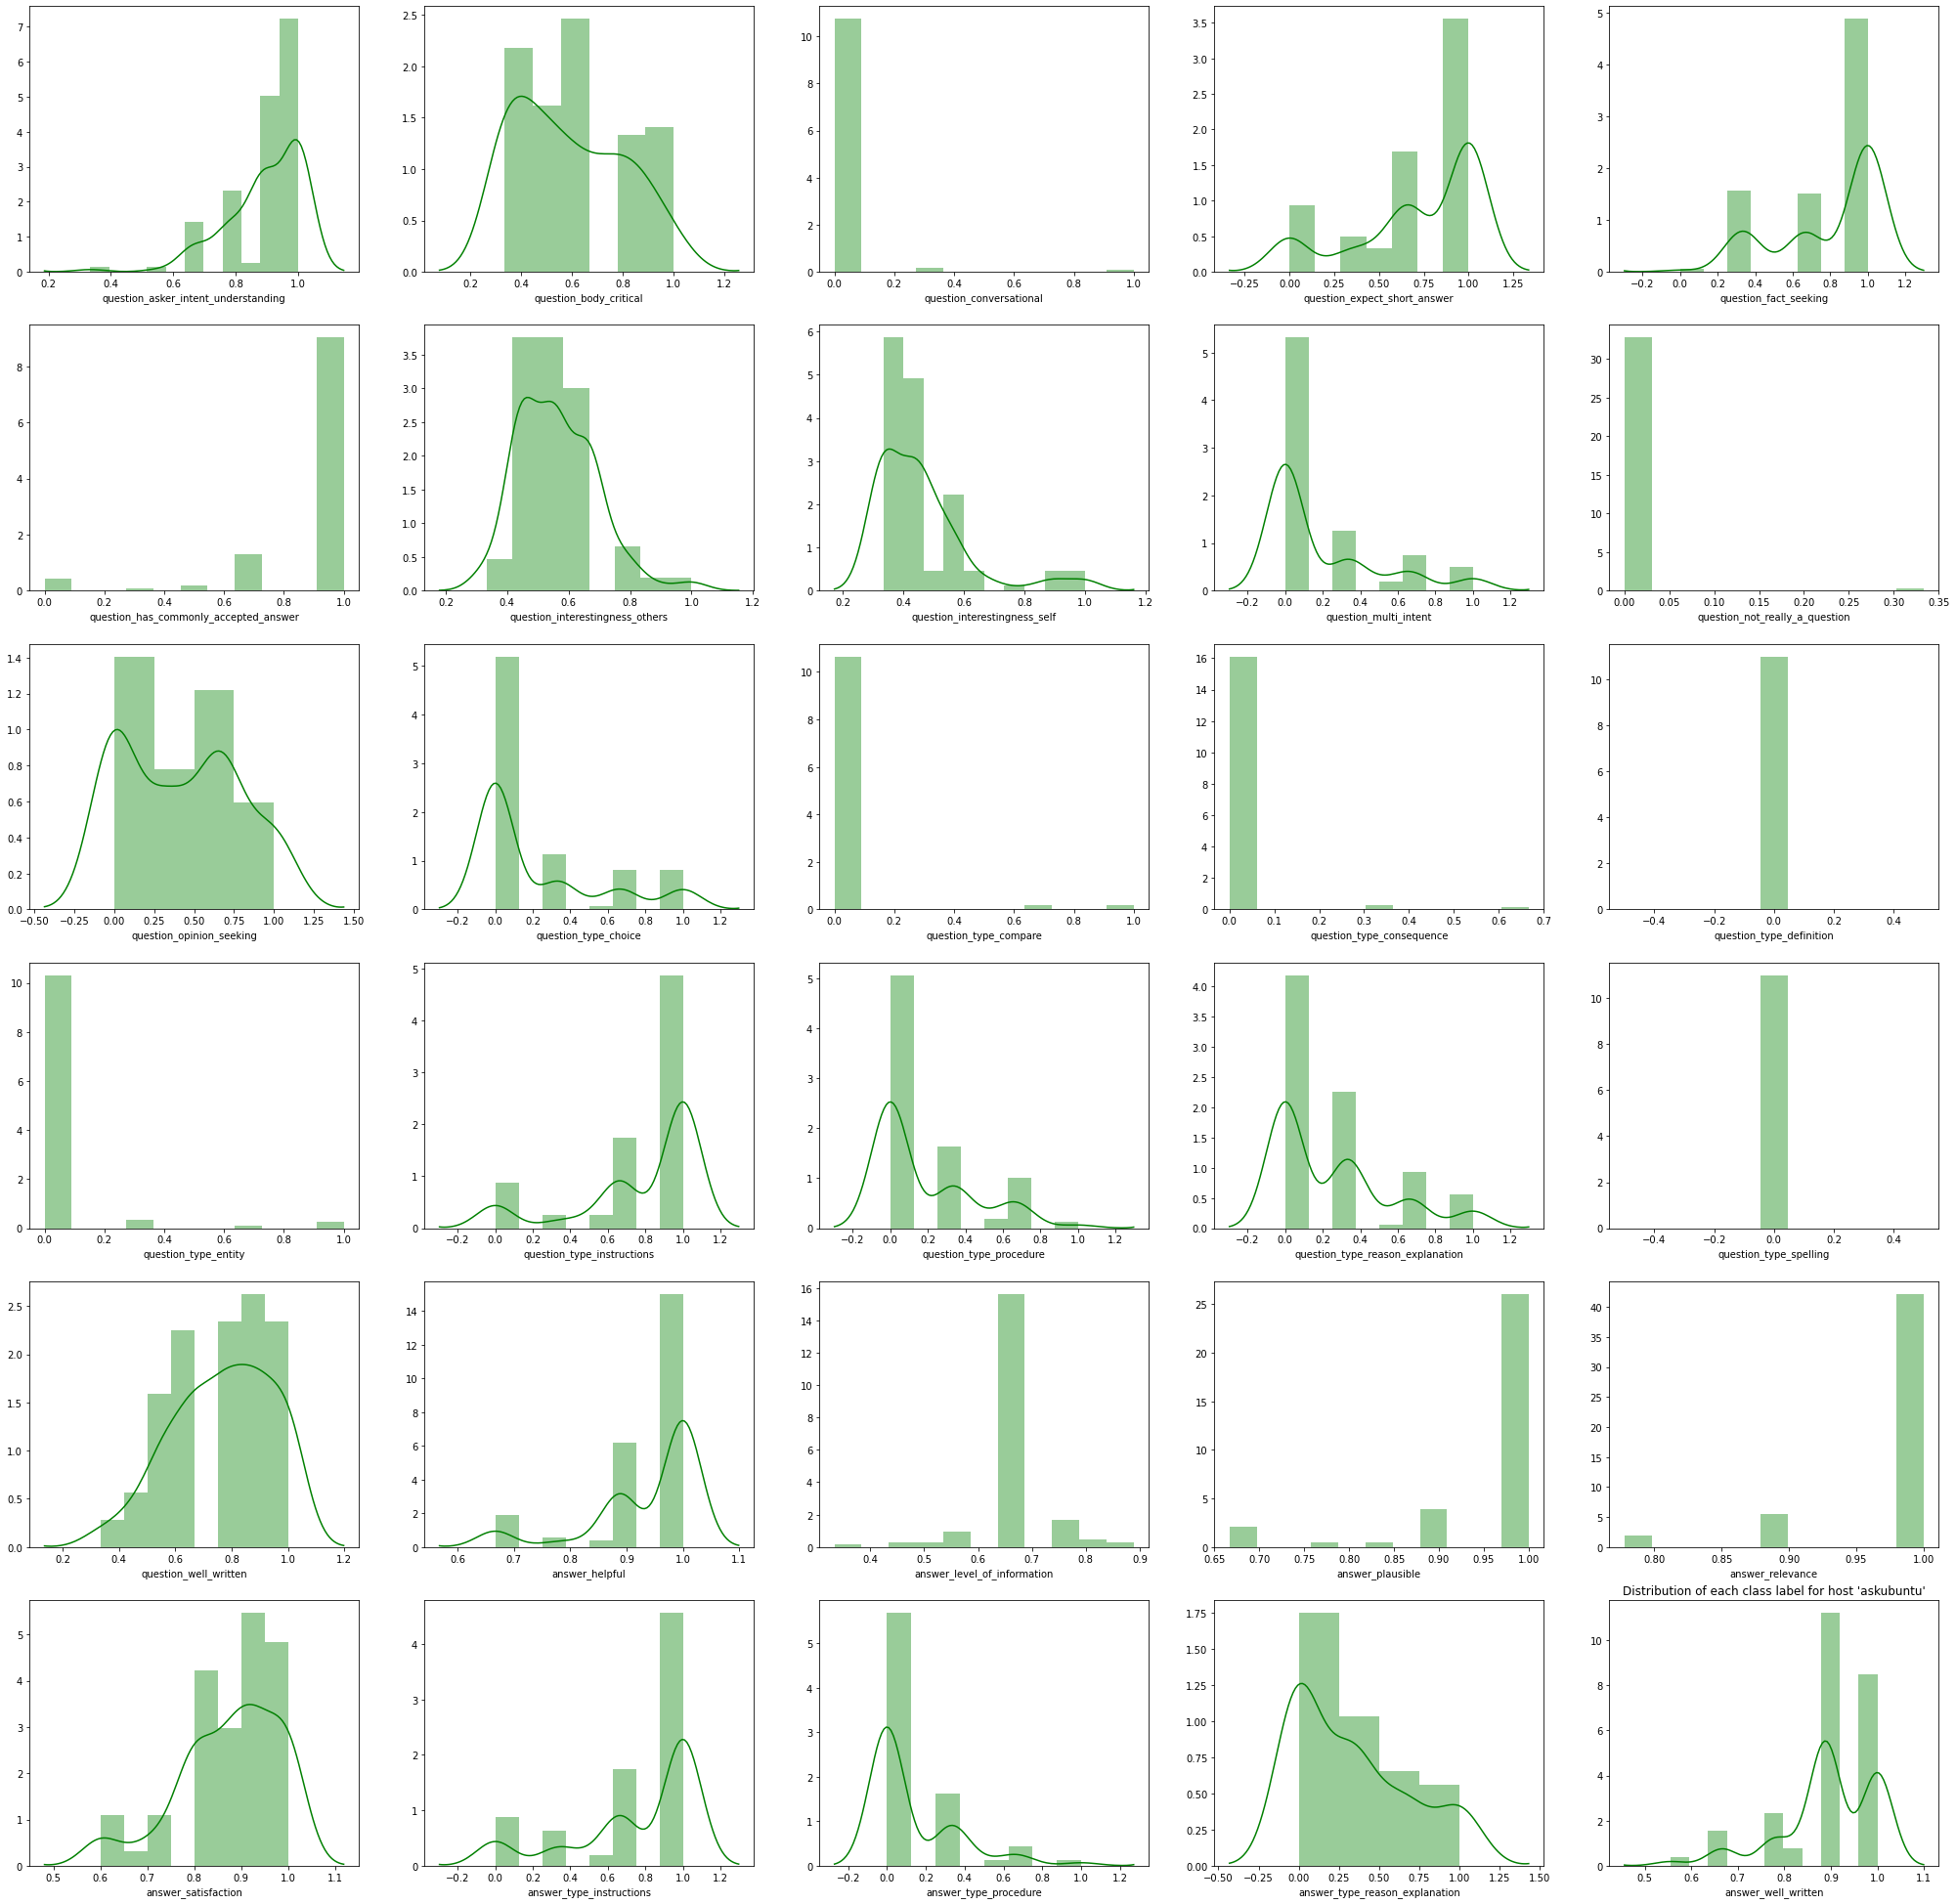

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='askubuntu',color='green')
plt.title("Distribution of each class label for host 'askubuntu'")

Text(0.5, 1.0, "Distribution of each class label for host 'mathoverflow'")

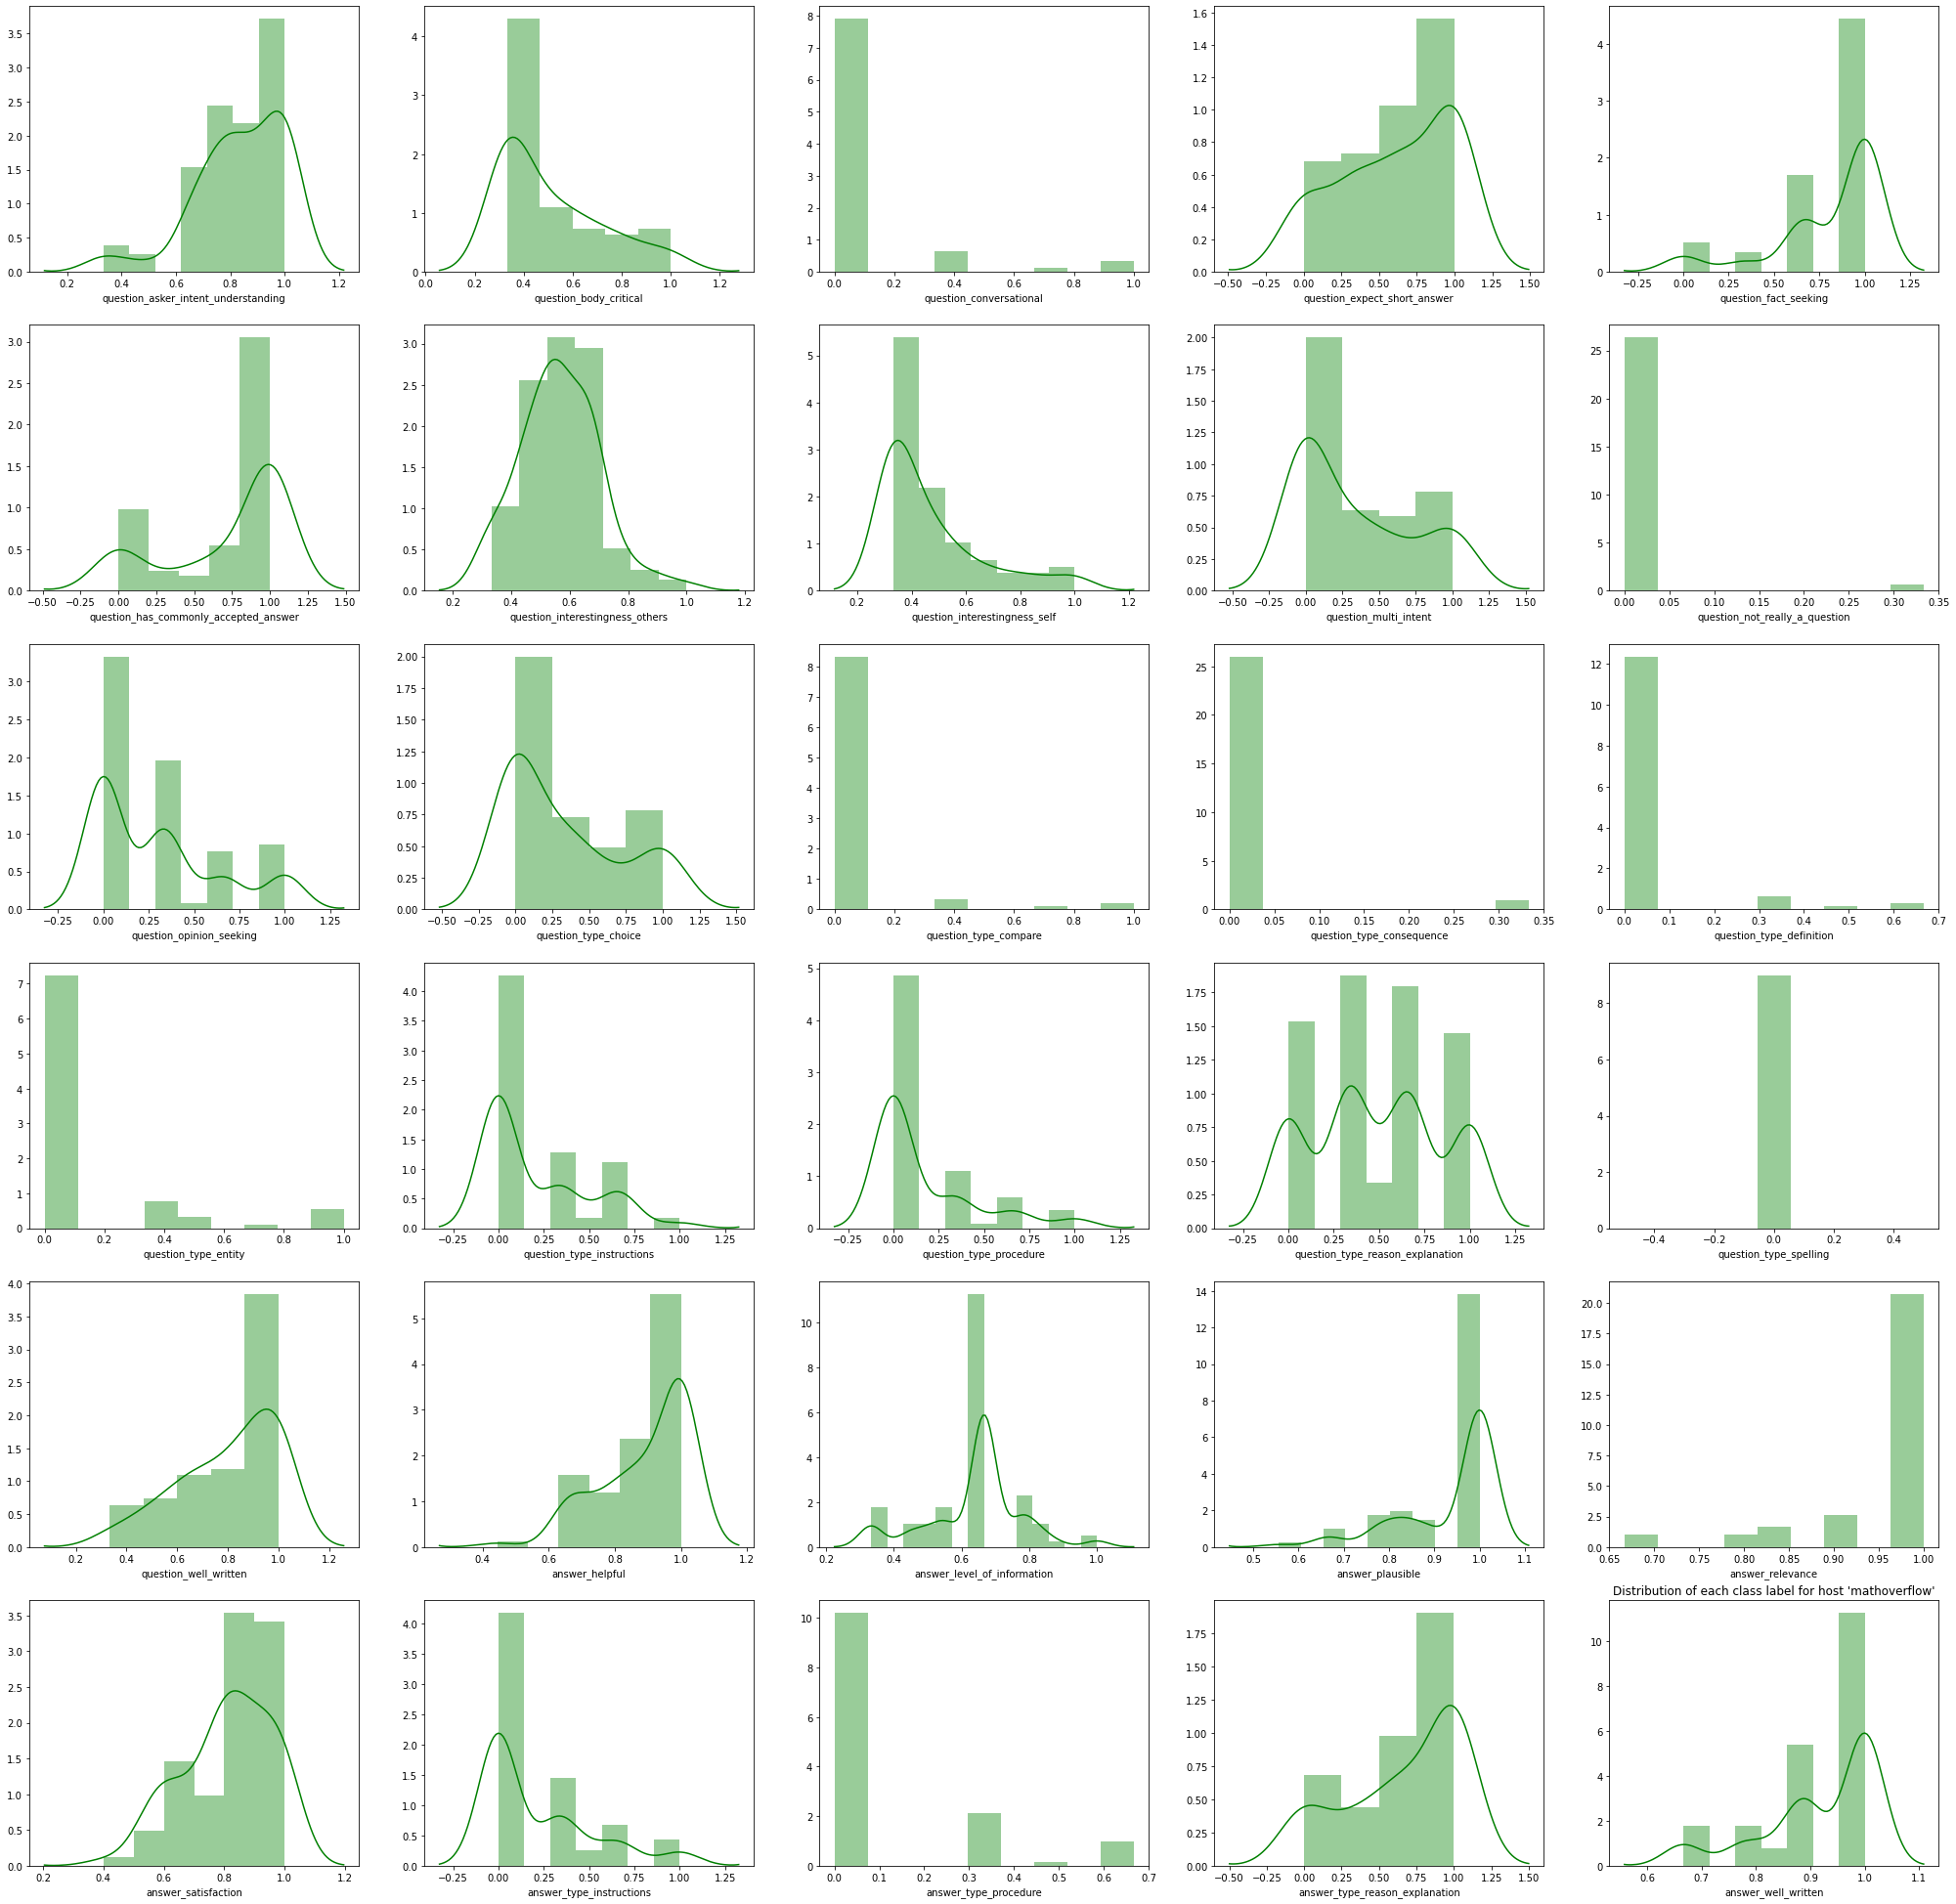

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='mathoverflow',color='green')
plt.title("Distribution of each class label for host 'mathoverflow'")

Text(0.5, 1.0, "Distribution of each class label for host 'serverfault'")

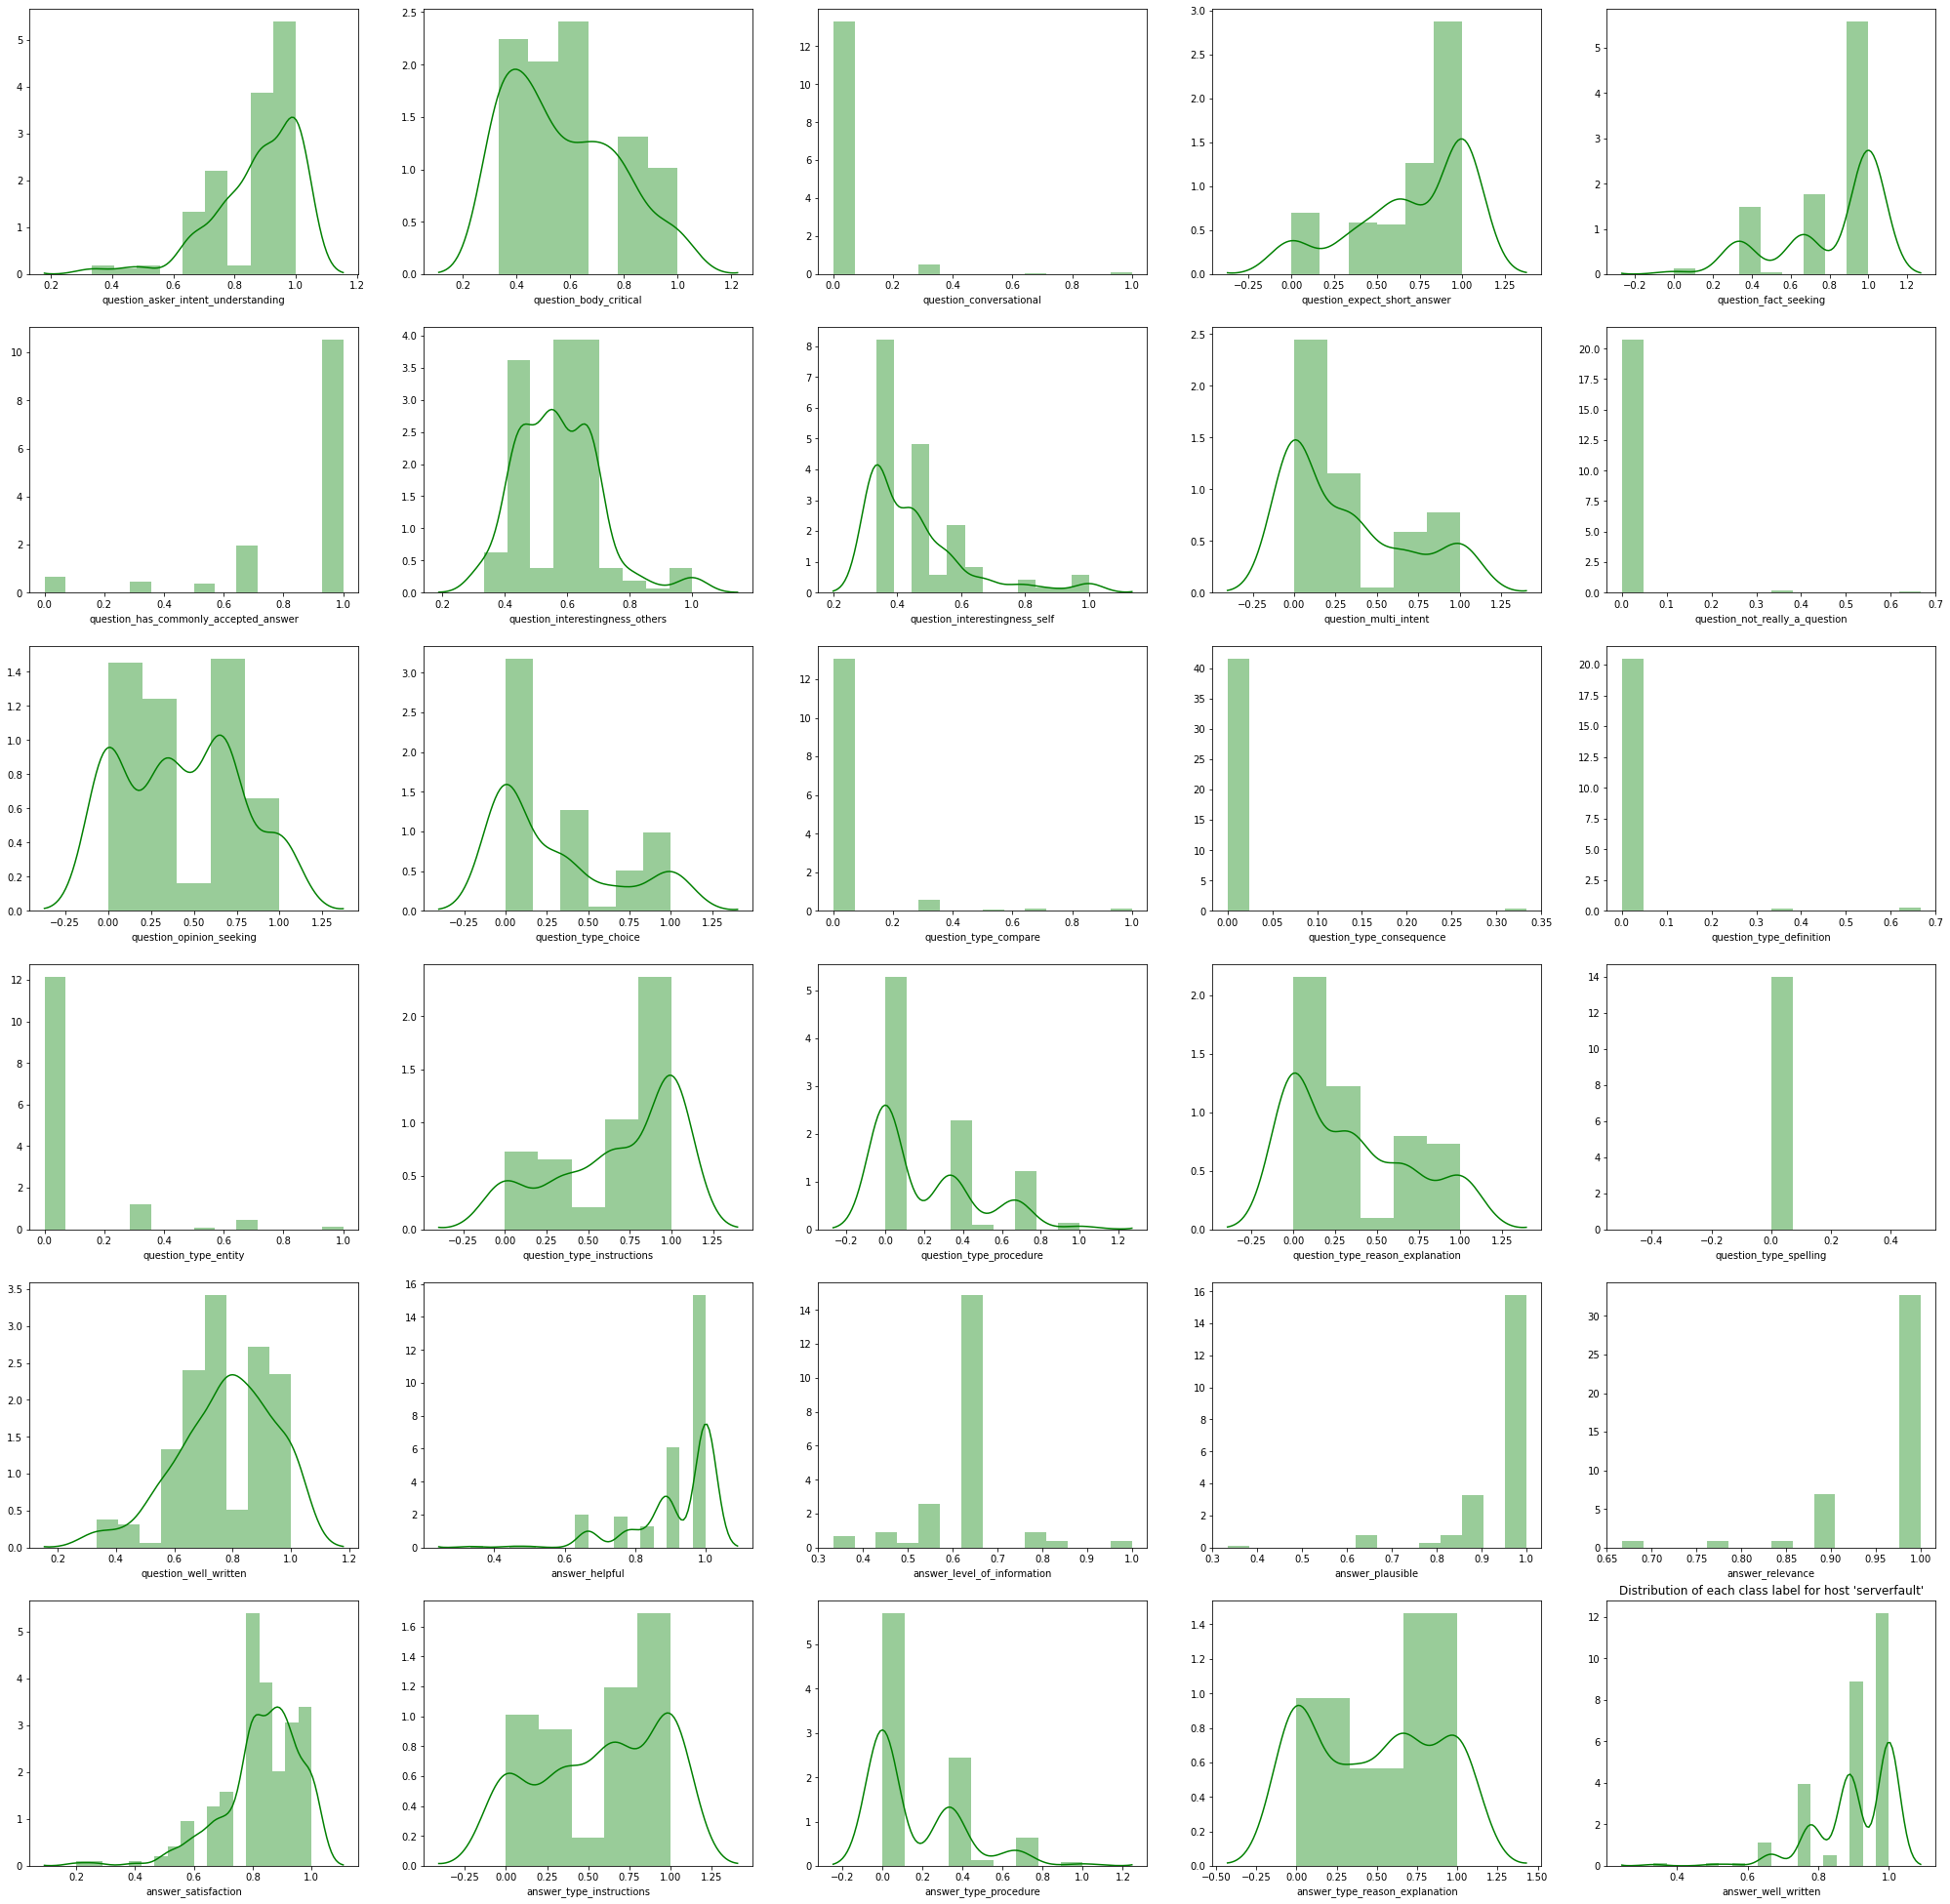

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='serverfault',color='green')
plt.title("Distribution of each class label for host 'serverfault'")

Text(0.5, 1.0, "Distribution of each class label for host 'stackexchange'")

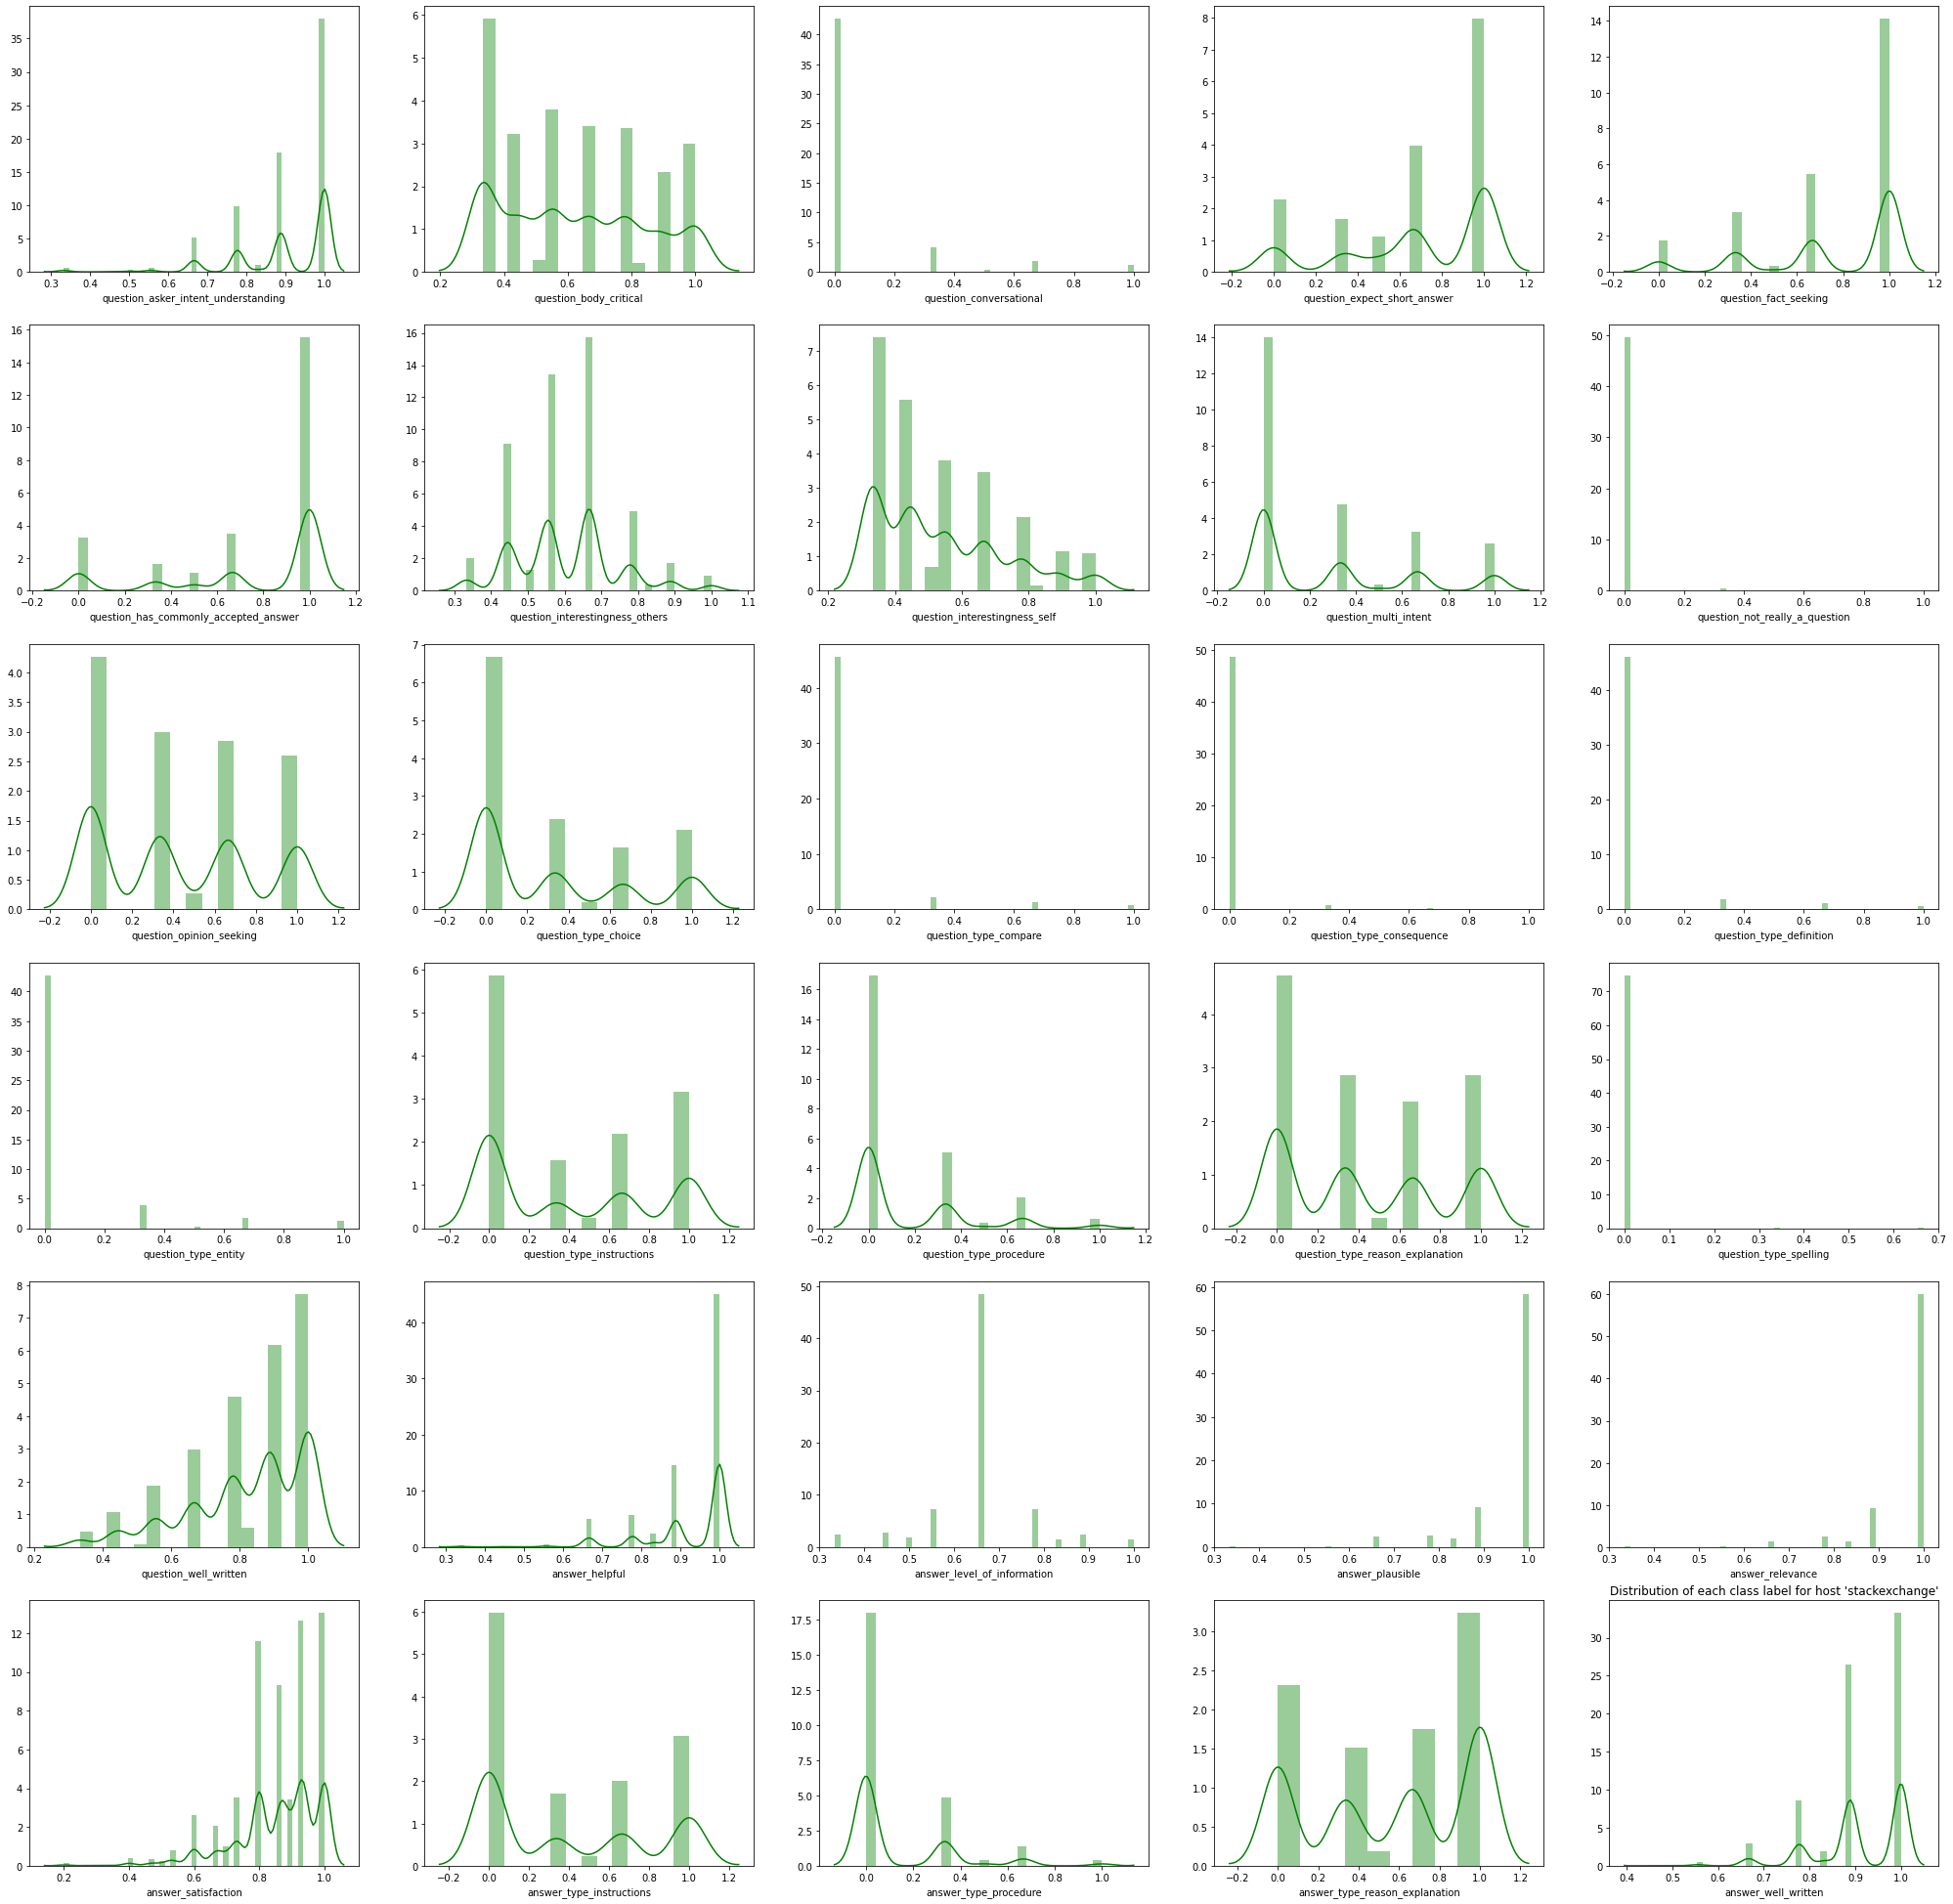

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='stackexchange',color='green')
plt.title("Distribution of each class label for host 'stackexchange'")

Text(0.5, 1.0, "Distribution of each class label for host 'stackoverflow'")

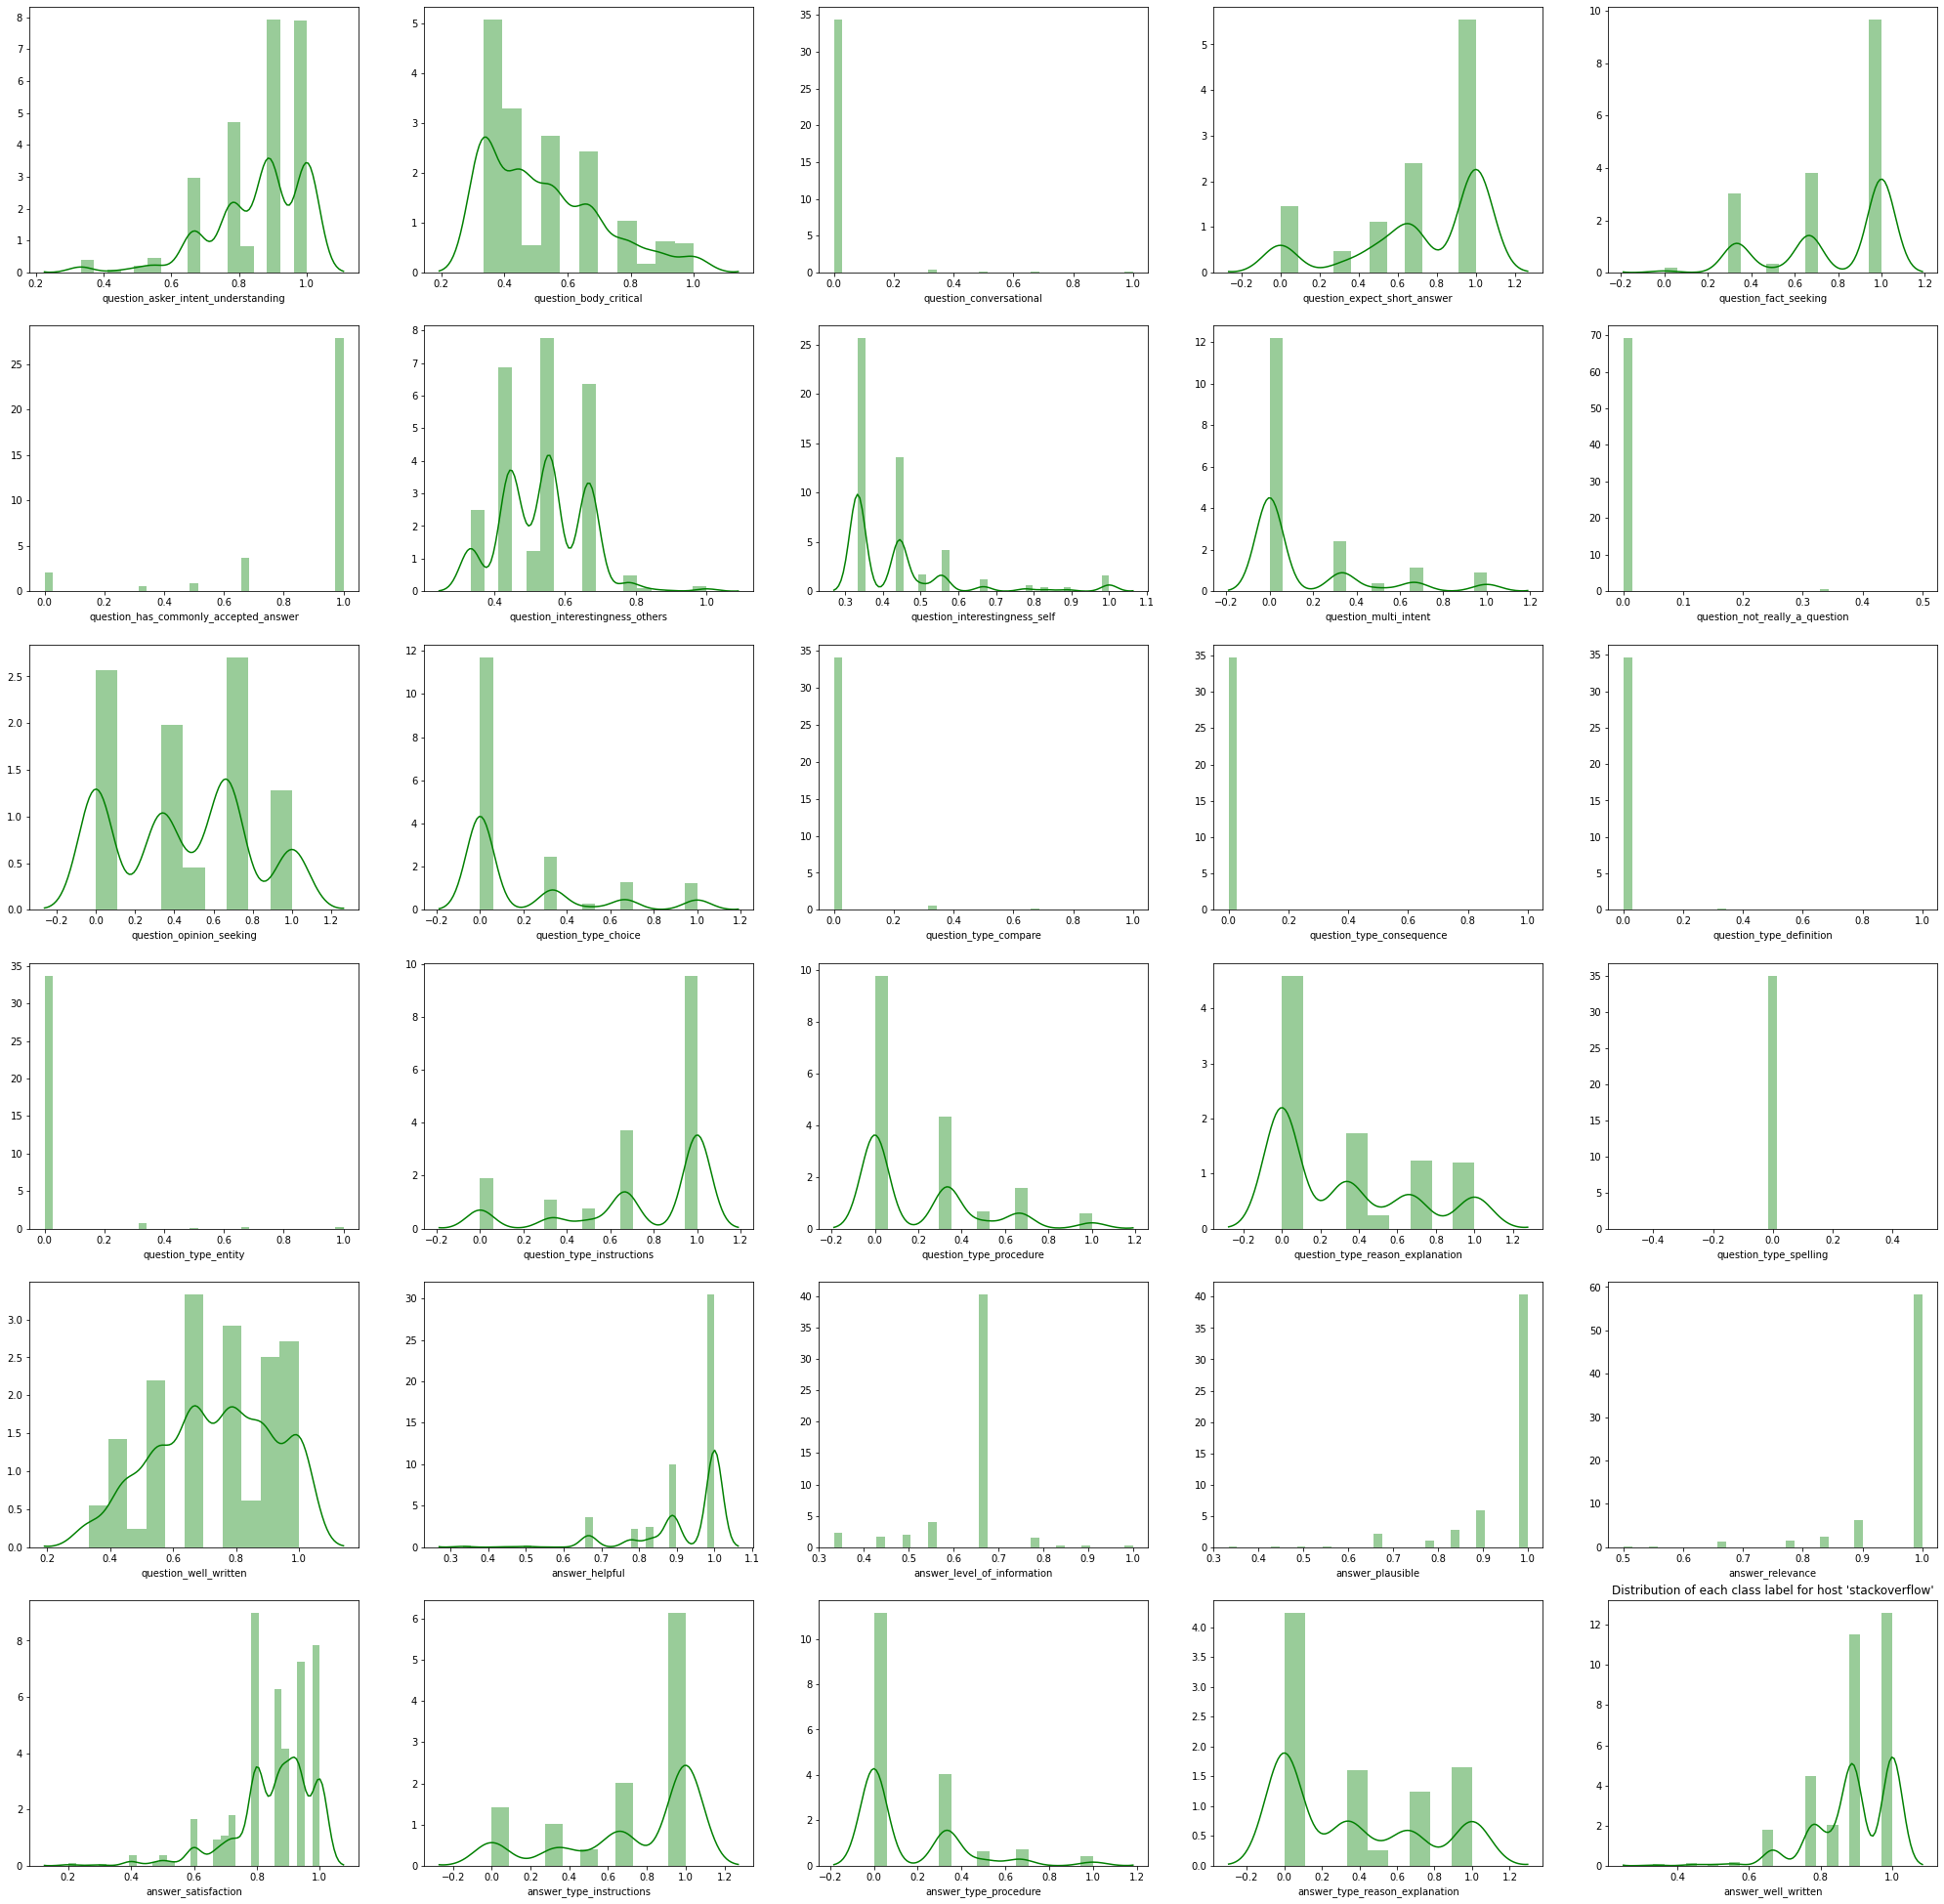

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='stackoverflow',color='green')
plt.title("Distribution of each class label for host 'stackoverflow'")

For host `stackoverflow`, most of the questions have `question_conversational` score 0 i.e most questions are not conversational.

`question_well_written` score are well distributed between 0.4 to 1.

Text(0.5, 1.0, "Distribution of each class label for host 'superuser'")

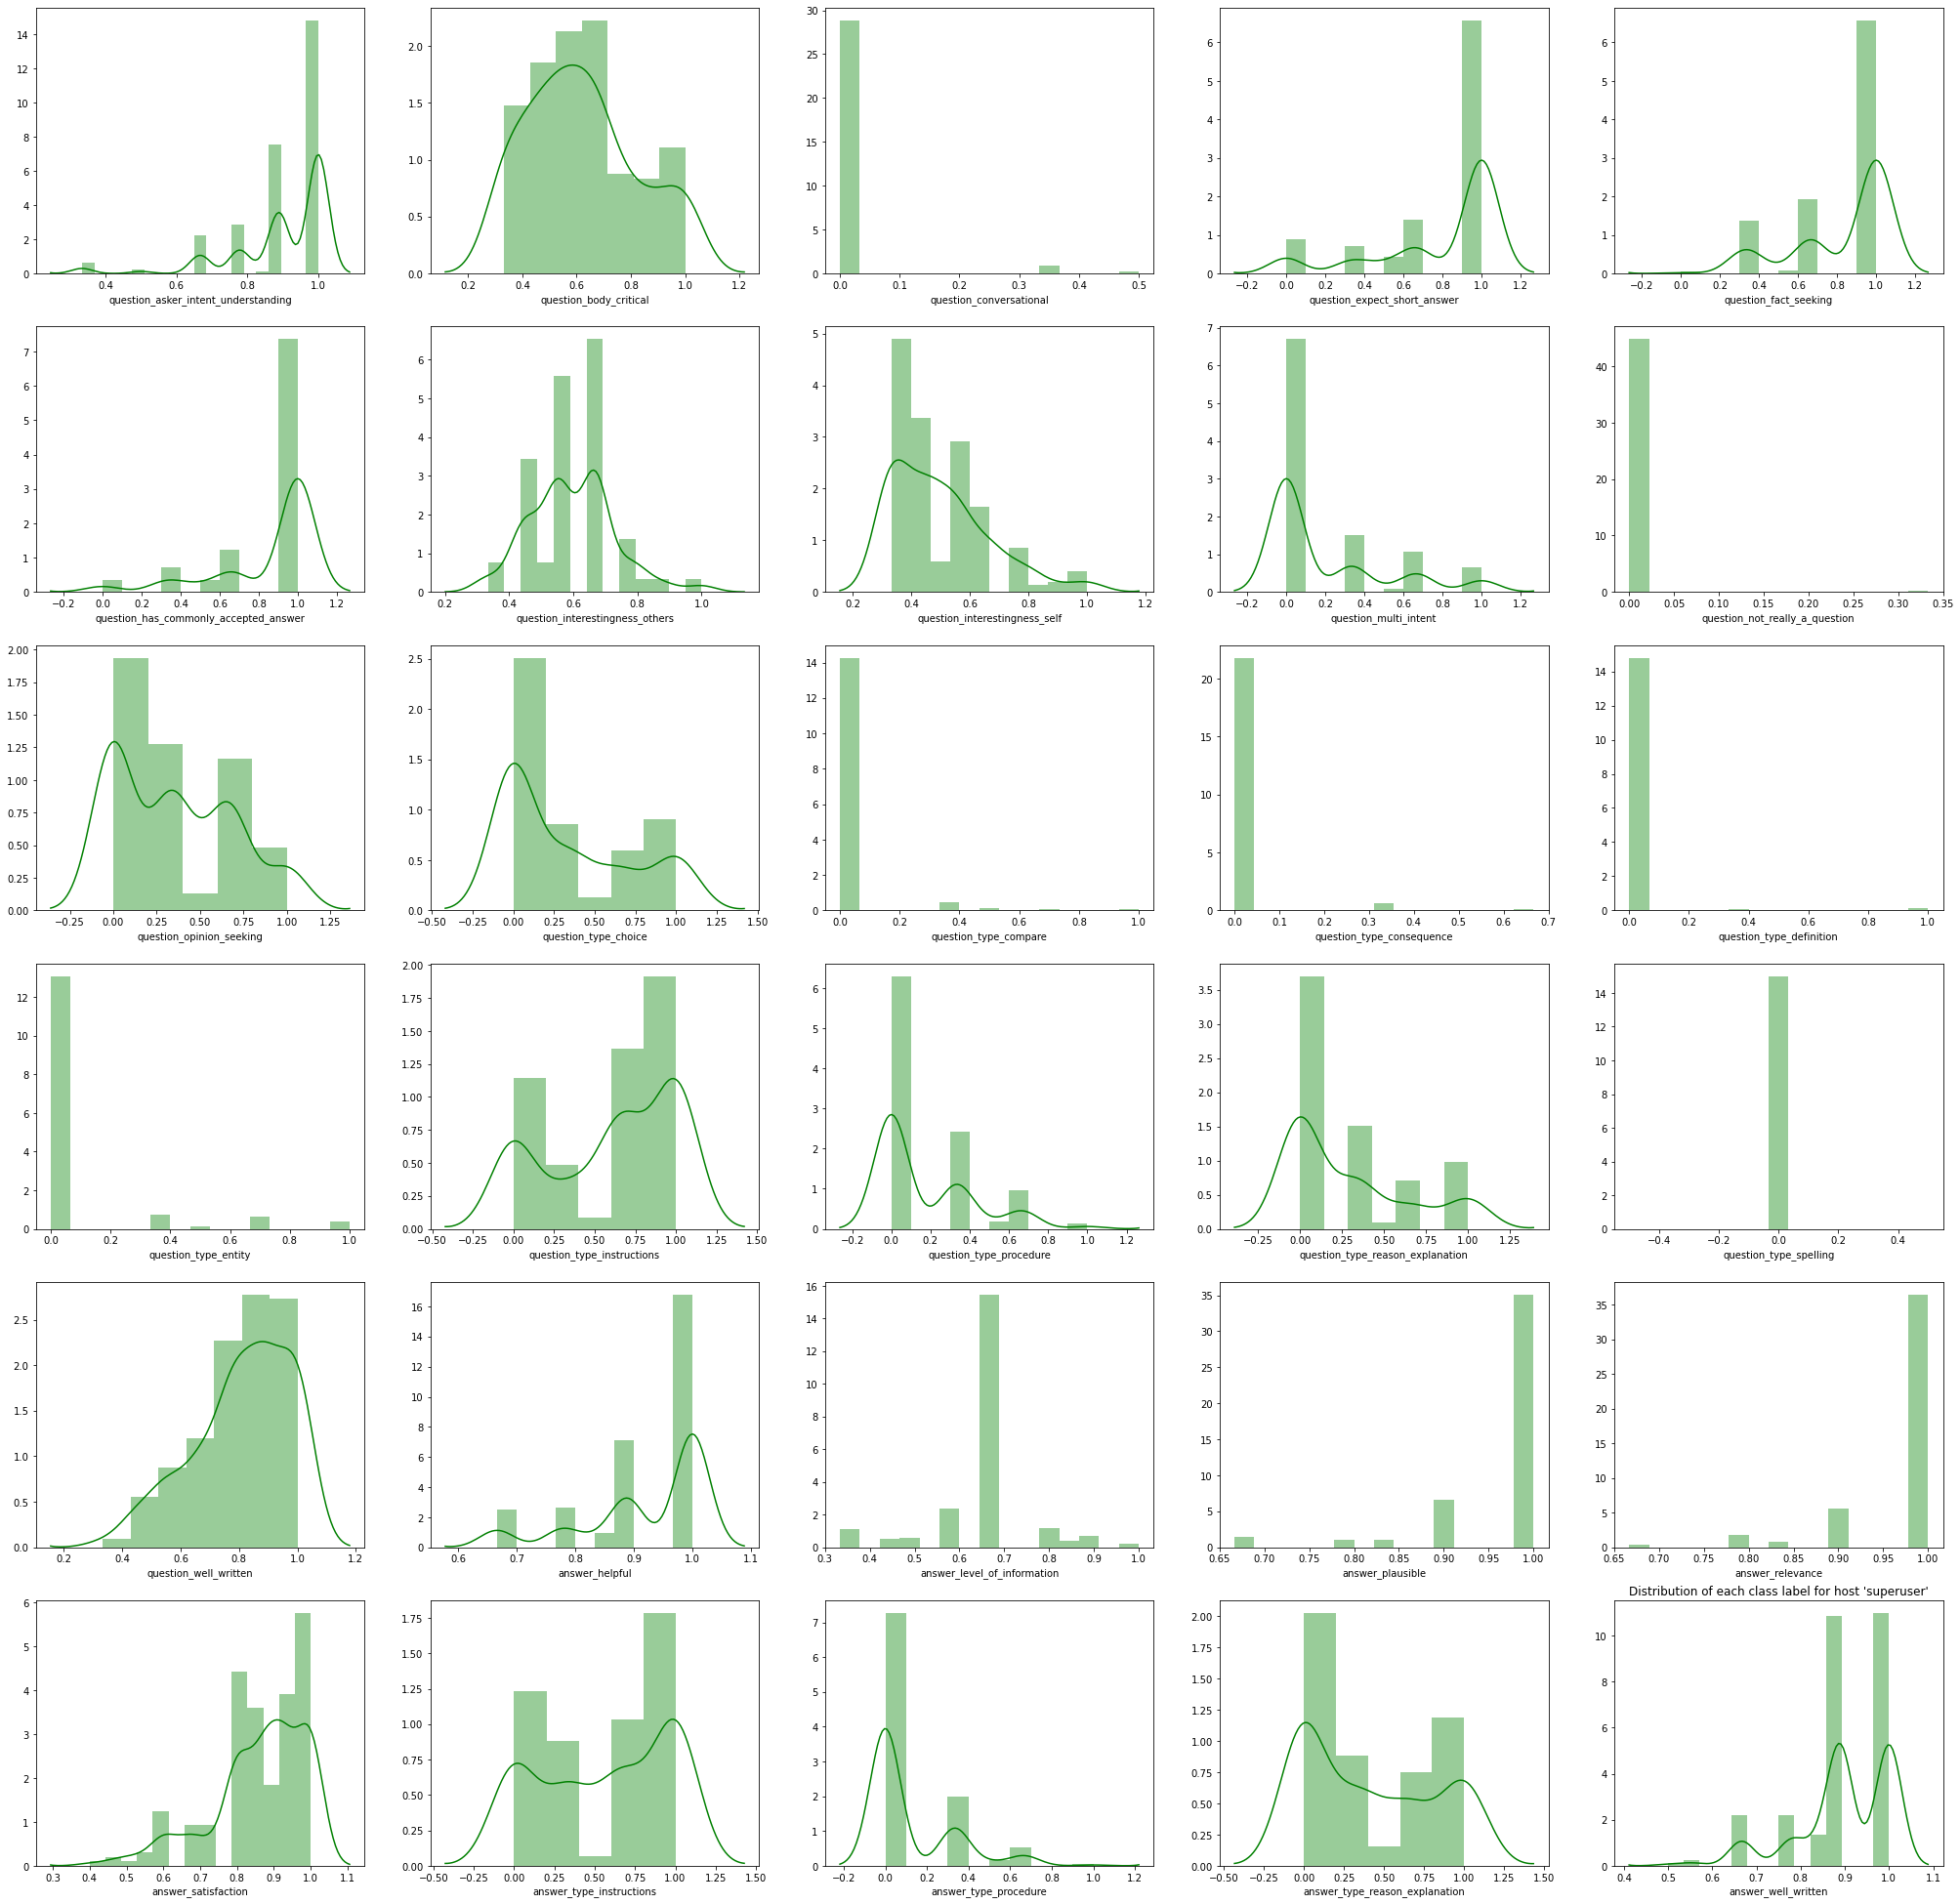

In [ ]:
warnings.filterwarnings("ignore")
dist_plot(class_labels,filter_col='host',filter_value='superuser',color='green')
plt.title("Distribution of each class label for host 'superuser'")

For all the hosts above, very few questions have `question_type_reason_explanation` close to 1.



### Preprocessing

In [14]:
train.head(2)

qa_id                                     question_title  \
0      0  What am I losing when using extension tubes in...   
1      1  What is the distinction between a city and a s...   

                                       question_body question_user_name  \
0  After playing around with macro photography on...               ysap   
1  I am trying to understand what kinds of places...      russellpierce   

                           question_user_page  \
0  https://photo.stackexchange.com/users/1024   
1    https://rpg.stackexchange.com/users/8774   

                                              answer answer_user_name  \
0  I just got extension tubes, so here's the skin...           rfusca   
1  It might be helpful to look into the definitio...     Erik Schmidt   

                             answer_user_page  \
0  https://photo.stackexchange.com/users/1917   
1    https://rpg.stackexchange.com/users/1871   

                                                 url   category  ...  \
0  http://photo.stackexchange.com/questions/9169/...  LIFE_ARTS  ...   
1  http://rpg.stackexchange.com/questions/47820/w...    CULTURE  ...   

  answer_plausible  answer_relevance  answer_satisfaction  \
0         1.000000          1.000000             0.800000   
1         0.888889          0.888889             0.666667   

   answer_type_instructions  answer_type_procedure  \
0                       1.0                    0.0   
1                       0.0                    0.0   

   answer_type_reason_explanation  answer_well_written  q_title_length  \
0                        0.000000             1.000000              13   
1                        0.666667             0.888889              16   

   q_body_length  answer_length  
0            139            149  
1            144             72  

[2 rows x 44 columns]

In [15]:
# https://stackoverflow.com/a/47091490/4084039
import re

def preprocess_text(phrase):
    # specific
    phrase = str(phrase)
    phrase = phrase.lower()
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrade = re.sub(r"wont", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"cant", "can not", phrase)
    phrase = re.sub(r"cannot", "can not", phrase)
    phrase = re.sub(r"doesn't", "does not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\"', ' ')
    phrase = phrase.replace('\\n', ' ')
    phrase = phrase.replace('\\', ' ')
    
    #phrase = re.sub(r'http\S+', '', phrase)  # for removal all http link
    phrase = re.sub(r'[^A-Za-z0-9]', ' ',phrase) # remove everything except alphaets and numbers
    
    sent = ''
    for val in phrase.split():          # removing multiple spaces between words
        sent = sent + ' ' + val
    sent = sent.strip()
    
    return sent
    


In [16]:
# preprocessing question title, question body and answers
train['question_title'] = train['question_title'].apply(lambda x: preprocess_text(x))
train['question_body'] = train['question_body'].apply(lambda x: preprocess_text(x))
train['answer'] = train['answer'].apply(lambda x: preprocess_text(x))

print(len(train['question_title']))
print(train['question_title'][0])
print("="*50)

print(train['question_body'][0])
print("="*50)

print(train['answer'][0])
print("="*50)

6079
what am i losing when using extension tubes instead of a macro lens
after playing around with macro photography on the cheap read reversed lens rev lens mounted on a straight lens passive extension tubes i would like to get further with this the problems with the techniques i used is that focus is manual and aperture control is problematic at best this limited my setup to still subjects read dead insects now as spring is approaching i want to be able to shoot live insects i believe that for this autofocus and settable aperture will be of great help so one obvious but expensive option is a macro lens say ef 100mm macro however i am not really interested in yet another prime lens an alternative is the electrical extension tubes except for maximum focusing distance what am i losing when using tubes coupled with a fine lens say ef70 200 2 8 instead of a macro lens
i just got extension tubes so here is the skinny what am i losing when using tubes a very considerable amount of light inc

In [17]:
# preprocessing 'category' and 'host' to lower-case and stripping leading and tailing spaces 

train['category'] = train['category'].apply(lambda x: x.lower())
train['category'] = train['category'].apply(lambda x: x.strip())

train['host'] = train['host'].apply(lambda x: x.lower())
train['host'] = train['host'].apply(lambda x: x.strip())

### Feature Engineering

I have already created 3 features in the EDA section - 
1. `q_title_length` - Length of question title
2. `q_body_length` - Length of question body
3. `answer_length` - Length of answer

#### Features - Sentiment scores of the question_title, question_body and answer

In [18]:
# sentiments from question_title

#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for title in train.question_title:
    ss = sid.polarity_scores(title)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])

train['q_title_neg'] = neg
train['q_title_neu'] = neu
train['q_title_pos'] = pos
train['q_title_comp'] = comp

print(train.shape)

(6079, 48)


In [19]:
# sentiments from question_body
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for body in train.question_body:
    ss = sid.polarity_scores(body)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])
        
train['q_body_neg'] = neg
train['q_body_neu'] = neu
train['q_body_pos'] = pos
train['q_body_comp'] = comp

print(train.shape)

(6079, 52)


In [20]:
# sentiments from answer
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for body in train.answer:
    ss = sid.polarity_scores(body)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])
        
train['q_answer_neg'] = neg
train['q_answer_neu'] = neu
train['q_answer_pos'] = pos
train['q_answer_comp'] = comp

print(train.shape)

(6079, 56)


#### EDA on new features 

In [21]:
# function to get the percentile values by passing dataframe and column
def percentile(data,column,min_lim=1,max_lim=101,diff=3):
    for i in np.arange(min_lim,max_lim,diff):
        print(f"{i} percentile = ",np.percentile(data[column], i))

In [22]:
percentile(train, column='q_title_neg')

1 percentile =  0.0
4 percentile =  0.0
7 percentile =  0.0
10 percentile =  0.0
13 percentile =  0.0
16 percentile =  0.0
19 percentile =  0.0
22 percentile =  0.0
25 percentile =  0.0
28 percentile =  0.0
31 percentile =  0.0
34 percentile =  0.0
37 percentile =  0.0
40 percentile =  0.0
43 percentile =  0.0
46 percentile =  0.0
49 percentile =  0.0
52 percentile =  0.0
55 percentile =  0.0
58 percentile =  0.0
61 percentile =  0.0
64 percentile =  0.0
67 percentile =  0.0
70 percentile =  0.0
73 percentile =  0.0
76 percentile =  0.0
79 percentile =  0.0
82 percentile =  0.0
85 percentile =  0.1283000000000002
88 percentile =  0.189
91 percentile =  0.238
94 percentile =  0.278
97 percentile =  0.355
100 percentile =  0.76


In [23]:
percentile(train, 'q_title_neg',85,100,1)

85 percentile =  0.1283000000000002
86 percentile =  0.149
87 percentile =  0.172
88 percentile =  0.189
89 percentile =  0.20742000000000005
90 percentile =  0.22
91 percentile =  0.238
92 percentile =  0.252
93 percentile =  0.268
94 percentile =  0.278
95 percentile =  0.302
96 percentile =  0.326
97 percentile =  0.355
98 percentile =  0.40187999999999924
99 percentile =  0.470880000000001


##### 82% of question title have negative score = 0 i.e. they are not negative.

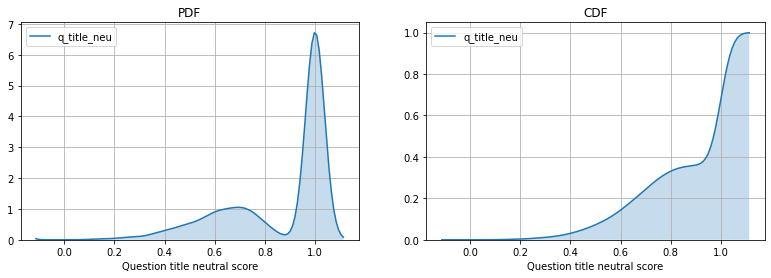

In [ ]:
# kde plot of q_title_neu
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_title_neu'], shade=True, ax=ax1)
plt.xlabel('Question title neutral score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_title_neu'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Question title neutral score')
plt.grid()
plt.title('CDF')

plt.show()


##### Maximum number of questions have neutral score 1. 

In [ ]:
# percentiles of q_title_neu (neutral rating of question title)
percentile(train, 'q_title_neu',1,100,2)

1 percentile =  0.281
3 percentile =  0.4
5 percentile =  0.463
7 percentile =  0.492
9 percentile =  0.536
11 percentile =  0.563
13 percentile =  0.58856
15 percentile =  0.606
17 percentile =  0.625
19 percentile =  0.649
21 percentile =  0.668
23 percentile =  0.69
25 percentile =  0.706
27 percentile =  0.725
29 percentile =  0.741
31 percentile =  0.762
33 percentile =  0.792
35 percentile =  0.8288999999999992
37 percentile =  1.0
39 percentile =  1.0
41 percentile =  1.0
43 percentile =  1.0
45 percentile =  1.0
47 percentile =  1.0
49 percentile =  1.0
51 percentile =  1.0
53 percentile =  1.0
55 percentile =  1.0
57 percentile =  1.0
59 percentile =  1.0
61 percentile =  1.0
63 percentile =  1.0
65 percentile =  1.0
67 percentile =  1.0
69 percentile =  1.0
71 percentile =  1.0
73 percentile =  1.0
75 percentile =  1.0
77 percentile =  1.0
79 percentile =  1.0
81 percentile =  1.0
83 percentile =  1.0
85 percentile =  1.0
87 percentile =  1.0
89 percentile =  1.0
91 percentil

##### All question titles have neutral score greater than 0 i.e. all questions are somewhat neutral.
##### 65% of question titles have neutral score 1.

In [ ]:
percentile(train, 'q_title_pos',1,100,2)

1 percentile =  0.0
3 percentile =  0.0
5 percentile =  0.0
7 percentile =  0.0
9 percentile =  0.0
11 percentile =  0.0
13 percentile =  0.0
15 percentile =  0.0
17 percentile =  0.0
19 percentile =  0.0
21 percentile =  0.0
23 percentile =  0.0
25 percentile =  0.0
27 percentile =  0.0
29 percentile =  0.0
31 percentile =  0.0
33 percentile =  0.0
35 percentile =  0.0
37 percentile =  0.0
39 percentile =  0.0
41 percentile =  0.0
43 percentile =  0.0
45 percentile =  0.0
47 percentile =  0.0
49 percentile =  0.0
51 percentile =  0.0
53 percentile =  0.0
55 percentile =  0.0
57 percentile =  0.0
59 percentile =  0.0
61 percentile =  0.0
63 percentile =  0.0
65 percentile =  0.0
67 percentile =  0.0
69 percentile =  0.0
71 percentile =  0.0
73 percentile =  0.0
75 percentile =  0.0
77 percentile =  0.1530600000000004
79 percentile =  0.20661999999999986
81 percentile =  0.236
83 percentile =  0.26273999999999975
85 percentile =  0.286
87 percentile =  0.30999999999999994
89 percentile 

In [ ]:
percentile(train, 'q_title_pos',99,100.1,0.1)

99.0 percentile =  0.615
99.1 percentile =  0.6164899999999989
99.19999999999999 percentile =  0.63
99.29999999999998 percentile =  0.634
99.39999999999998 percentile =  0.641
99.49999999999997 percentile =  0.645
99.59999999999997 percentile =  0.674
99.69999999999996 percentile =  0.722
99.79999999999995 percentile =  0.749531999999992
99.89999999999995 percentile =  0.8135679999998611
99.99999999999994 percentile =  0.9999999999994943


##### 75% questions have positive score 0 i.e. they are not positive.
##### Maximum positive score a question has 0.99

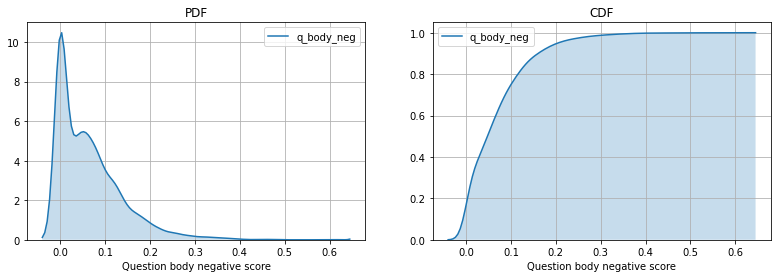

In [ ]:
# kde plot of q_body_neg
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_body_neg'], shade=True, ax=ax1)
plt.xlabel('Question body negative score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_body_neg'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Question body negative score')
plt.grid()
plt.title('CDF')

plt.show()


In [ ]:
percentile(train, 'q_body_neg')

1 percentile =  0.0
4 percentile =  0.0
7 percentile =  0.0
10 percentile =  0.0
13 percentile =  0.0
16 percentile =  0.0
19 percentile =  0.0
22 percentile =  0.0
25 percentile =  0.0
28 percentile =  0.0
31 percentile =  0.0
34 percentile =  0.015
37 percentile =  0.023
40 percentile =  0.029
43 percentile =  0.03553999999999996
46 percentile =  0.04
49 percentile =  0.046
52 percentile =  0.051
55 percentile =  0.057
58 percentile =  0.061
61 percentile =  0.067
64 percentile =  0.073
67 percentile =  0.079
70 percentile =  0.086
73 percentile =  0.09293999999999959
76 percentile =  0.102
79 percentile =  0.11100000000000002
82 percentile =  0.121
85 percentile =  0.131
88 percentile =  0.147
91 percentile =  0.167
94 percentile =  0.193
97 percentile =  0.2363199999999997
100 percentile =  0.605


##### Maximum negative score of a question body is 0.605. Around 31% of questions have negative score 0 i.e. they are not negative.

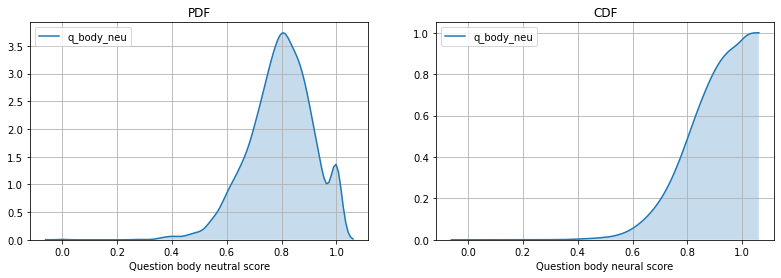

In [ ]:
# kde plot of q_body_neu
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_body_neu'], shade=True, ax=ax1)
plt.xlabel('Question body neutral score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_body_neu'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Question body neural score')
plt.grid()
plt.title('CDF')

plt.show()


##### Most of the questions body have neutral score greater than 0.8
##### About 50% of the questions have neutral score less than 0.8

In [ ]:
percentile(train, 'q_body_neu')

1 percentile =  0.482
4 percentile =  0.583
7 percentile =  0.617
10 percentile =  0.646
13 percentile =  0.667
16 percentile =  0.685
19 percentile =  0.701
22 percentile =  0.714
25 percentile =  0.728
28 percentile =  0.739
31 percentile =  0.749
34 percentile =  0.759
37 percentile =  0.768
40 percentile =  0.776
43 percentile =  0.785
46 percentile =  0.793
49 percentile =  0.8
52 percentile =  0.808
55 percentile =  0.816
58 percentile =  0.8240000000000001
61 percentile =  0.832
64 percentile =  0.841
67 percentile =  0.85
70 percentile =  0.8579999999999999
73 percentile =  0.868
76 percentile =  0.8779999999999999
79 percentile =  0.887
82 percentile =  0.899
85 percentile =  0.911
88 percentile =  0.9260000000000002
91 percentile =  0.946
94 percentile =  1.0
97 percentile =  1.0
100 percentile =  1.0


##### All question body have neutral score greater than 0.4
#####  51% of the questions body have neutral score greater than 0.8

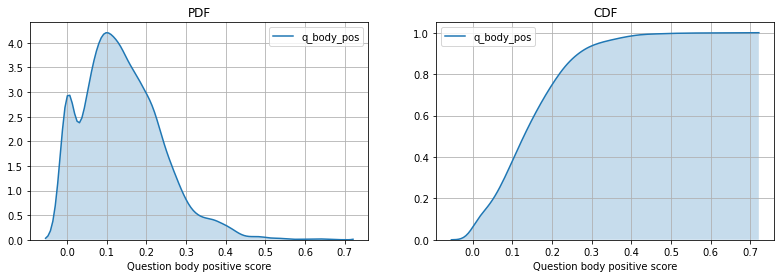

In [ ]:
# kde plot of q_body_pos
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_body_pos'], shade=True, ax=ax1)
plt.xlabel('Question body positive score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_body_pos'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Question body positive score')
plt.grid()
plt.title('CDF')

plt.show()


##### Around 40% of the questions body have score less than 0.1

In [ ]:
percentile(train, 'q_body_pos')

1 percentile =  0.0
4 percentile =  0.0
7 percentile =  0.0
10 percentile =  0.0
13 percentile =  0.026000000000000002
16 percentile =  0.041
19 percentile =  0.052
22 percentile =  0.06
25 percentile =  0.069
28 percentile =  0.077
31 percentile =  0.084
34 percentile =  0.09
37 percentile =  0.097
40 percentile =  0.104
43 percentile =  0.11053999999999997
46 percentile =  0.119
49 percentile =  0.126
52 percentile =  0.132
55 percentile =  0.14
58 percentile =  0.148
61 percentile =  0.157
64 percentile =  0.166
67 percentile =  0.174
70 percentile =  0.183
73 percentile =  0.192
76 percentile =  0.203
79 percentile =  0.213
82 percentile =  0.223
85 percentile =  0.236
88 percentile =  0.253
91 percentile =  0.272
94 percentile =  0.2993199999999997
97 percentile =  0.362
100 percentile =  0.667


##### Maximum positive score of a question body is 0.667.
##### 95% of the questions body have a positive score less than 0.3 i.e. most of the questions body are not much positive.

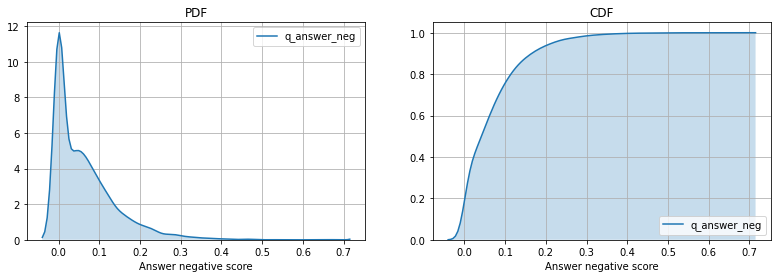

In [ ]:
# kde plot of q_answer_neg
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_answer_neg'], shade=True, ax=ax1)
plt.xlabel('Answer negative score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_answer_neg'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer negative score')
plt.grid()
plt.title('CDF')

plt.show()


##### Most of the answers have negative score 0

In [ ]:
percentile(train,'q_answer_neg')

1 percentile =  0.0
4 percentile =  0.0
7 percentile =  0.0
10 percentile =  0.0
13 percentile =  0.0
16 percentile =  0.0
19 percentile =  0.0
22 percentile =  0.0
25 percentile =  0.0
28 percentile =  0.0
31 percentile =  0.0
34 percentile =  0.0
37 percentile =  0.011
40 percentile =  0.022
43 percentile =  0.028
46 percentile =  0.034
49 percentile =  0.04
52 percentile =  0.045
55 percentile =  0.051
58 percentile =  0.057
61 percentile =  0.063
64 percentile =  0.07
67 percentile =  0.076
70 percentile =  0.084
73 percentile =  0.091
76 percentile =  0.1
79 percentile =  0.10900000000000001
82 percentile =  0.12
85 percentile =  0.133
88 percentile =  0.15
91 percentile =  0.172
94 percentile =  0.201
97 percentile =  0.247
100 percentile =  0.675


##### 35% of the answers have negative score 0. 
##### 75% of the answers have negative score less than 0.1, that means maximum answers have very less negative score.
##### Maximum negative score of an answer is 0.675.

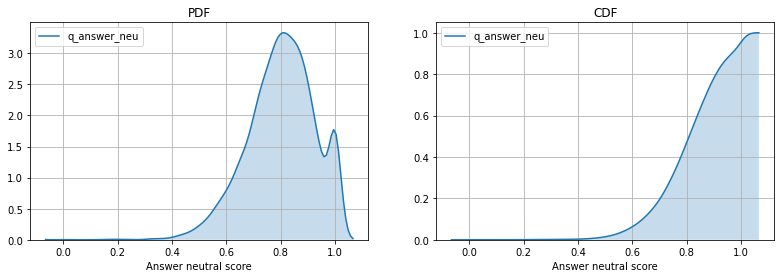

In [ ]:
# kde plot of q_answer_neu
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_answer_neu'], shade=True, ax=ax1)
plt.xlabel('Answer neutral score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_answer_neu'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer neutral score')
plt.grid()
plt.title('CDF')

plt.show()


##### Around 50% of the answers have neutral score greater than 0.8

In [ ]:
percentile(train,'q_answer_neu')

1 percentile =  0.48078
4 percentile =  0.56812
7 percentile =  0.61
10 percentile =  0.641
13 percentile =  0.663
16 percentile =  0.685
19 percentile =  0.701
22 percentile =  0.714
25 percentile =  0.7264999999999999
28 percentile =  0.738
31 percentile =  0.75
34 percentile =  0.761
37 percentile =  0.769
40 percentile =  0.7810000000000001
43 percentile =  0.788
46 percentile =  0.797
49 percentile =  0.806
52 percentile =  0.816
55 percentile =  0.824
58 percentile =  0.8320000000000001
61 percentile =  0.843
64 percentile =  0.852
67 percentile =  0.861
70 percentile =  0.8705999999999994
73 percentile =  0.88
76 percentile =  0.89
79 percentile =  0.902
82 percentile =  0.914
85 percentile =  0.929
88 percentile =  0.947
91 percentile =  0.979
94 percentile =  1.0
97 percentile =  1.0
100 percentile =  1.0


Most answers are highly neutral

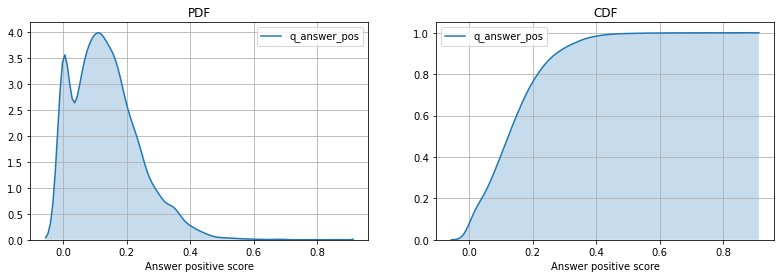

In [ ]:
# kde plot of q_answer_pos
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(train['q_answer_pos'], shade=True, ax=ax1)
plt.xlabel('Answer positive score')
plt.grid()
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(train['q_answer_pos'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Answer positive score')
plt.grid()
plt.title('CDF')

plt.show()


##### Around 78% of the answers have positive score upto 0.2, so most answers are not so positive

In [ ]:
# percentiles of answer positive score
percentile(train,'q_answer_pos')

1 percentile =  0.0
4 percentile =  0.0
7 percentile =  0.0
10 percentile =  0.0
13 percentile =  0.0
16 percentile =  0.024
19 percentile =  0.038
22 percentile =  0.05
25 percentile =  0.058
28 percentile =  0.067
31 percentile =  0.075
34 percentile =  0.083
37 percentile =  0.091
40 percentile =  0.09820000000000029
43 percentile =  0.106
46 percentile =  0.114
49 percentile =  0.12
52 percentile =  0.128
55 percentile =  0.136
58 percentile =  0.144
61 percentile =  0.152
64 percentile =  0.16
67 percentile =  0.168
70 percentile =  0.177
73 percentile =  0.186
76 percentile =  0.198
79 percentile =  0.21000000000000002
82 percentile =  0.224
85 percentile =  0.23730000000000018
88 percentile =  0.2566400000000003
91 percentile =  0.282
94 percentile =  0.315
97 percentile =  0.359
100 percentile =  0.857


##### Maximum positive score of an answer is 0.857.
##### Around 91% of the answer have a positive score upto 0.29 i.e. most of the answers are not much positive.

### Splitting train data into train, cross-validation set

In [ ]:
train.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [24]:
# input columns to be used for training model
input_columns = ['question_title', 'question_body','answer','category', 'host','q_title_length', 'q_body_length',
                 'answer_length', 'q_title_neg', 'q_title_neu', 'q_title_pos','q_title_comp', 'q_body_neg', 'q_body_neu', 
                 'q_body_pos', 'q_body_comp','q_answer_neg', 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']


In [25]:
X = train[input_columns].copy()
Y = train[class_labels].copy()

print(X.shape,Y.shape)


(6079, 20) (6079, 30)


In [26]:
from sklearn.model_selection import train_test_split
x_train,x_cv,y_train,y_cv = train_test_split(X,Y, test_size=0.1)
print("Shape after split")
print("Train shape = ", x_train.shape, y_train.shape)
print("Test shape = ", x_cv.shape, y_cv.shape)

Shape after split
Train shape =  (5471, 20) (5471, 30)
Test shape =  (608, 20) (608, 30)


### Encoding categorical data

In [27]:
# one-hot encoding 'category' feature
category_ohe = CountVectorizer(binary=True)
category_ohe.fit(x_train['category'])
category_encoded_train = category_ohe.transform(x_train['category']).todense()
category_encoded_cv = category_ohe.transform(x_cv['category']).todense()

print("Shape of train after encoding = ",category_encoded_train.shape)
print("Shape of cv after encoding = ",category_encoded_cv.shape)

Shape of train after encoding =  (5471, 5)
Shape of cv after encoding =  (608, 5)


In [28]:
# one-hot encoding 'host'
host_ohe = CountVectorizer(binary=True)
host_ohe.fit(x_train['host'])
host_encoded_train = host_ohe.transform(x_train['host']).todense()
host_encoded_cv = host_ohe.transform(x_cv['host']).todense()

print("Shape of train after encoding = ",host_encoded_train.shape)
print("Shape of cv after encoding = ",host_encoded_cv.shape)

Shape of train after encoding =  (5471, 6)
Shape of cv after encoding =  (608, 6)


### Encoding Text data

#### Using Pretrained Models: Avg W2V

In [22]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================

words = []
for i in train['question_title']:
    words.extend(i.split(' '))

for i in train['question_body']:
    words.extend(i.split(' '))
    
for i in train['answer']:
    words.extend(i.split(' '))

print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))

# saving variables into a pickle file
with open('glove_vectors_sw', 'wb') as f:
    pickle.dump(words_courpus, f)

Loading Glove Model


1917495it [03:53, 8215.19it/s]


Done. 1917495  words loaded!
all the words in the coupus 1783757
the unique words in the coupus 49911
The number of words that are present in both glove vectors and our coupus 39093 ( 78.325 %)
word 2 vec length 39093


In [29]:
# reading glove_vectors pickle file
with open('glove_vectors_sw', 'rb') as f:
    glove_vector = pickle.load(f)
    glove_words =  set(glove_vector.keys())

In [30]:
# average Word2Vec on question title train data
# computing average word2vec for each question title
avg_w2v_vectors_title_train = []; # the avg-w2v for each question title is stored in this list
for sentence in tqdm(x_train['question_title']): # for each question title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question title
    for word in sentence.split(): # for each word in a question title
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title_train.append(vector)

print(len(avg_w2v_vectors_title_train))
print(len(avg_w2v_vectors_title_train[0]))
print(avg_w2v_vectors_title_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 5471/5471 [00:00<00:00, 13813.78it/s]


5471
300
[ 1.98462462e-01  8.14003846e-02 -1.50275092e-01 -1.59673077e-01
  1.11128077e-01  7.09776923e-02 -2.95138462e+00  4.98700769e-01
  2.96960077e-02 -1.20386538e-01  1.83580231e-01 -2.68491923e-02
 -4.06860000e-02  8.74574769e-02 -7.81922154e-02 -1.09478077e-01
  9.64222692e-02 -1.19182162e-01 -1.03502308e-03  9.07695385e-02
 -4.78613077e-02  5.64816123e-02 -9.70376923e-02  4.58453077e-02
  2.86106569e-02  1.25045385e-01 -1.75700231e-02 -1.90535738e-01
 -2.55406201e-01 -1.09864769e-01 -1.99190923e-01 -1.39447769e-01
  3.33213846e-02 -7.64775385e-02 -2.34074215e-01 -2.13723308e-02
 -2.22762231e-01  1.52807692e-02 -7.78130769e-02  1.23965615e-01
 -2.01120462e-01  5.58269231e-02 -3.59135385e-01 -6.73280769e-03
  1.33779615e-02 -1.28308077e-01  9.81553077e-02 -1.68672615e-01
 -1.27336462e-01  9.72557692e-02 -9.37533846e-02  4.26637692e-02
 -1.00146746e-01  2.31686154e-02 -5.51210000e-02  1.02740538e-01
  1.29323092e-01  2.66634000e-02 -1.78077154e-01 -2.07412308e-02
 -3.29094385e-02

In [31]:
# average Word2Vec on question title cross-validation data
# computing average word2vec for each question title
avg_w2v_vectors_title_cv = []; # the avg-w2v for each question title is stored in this list
for sentence in tqdm(x_cv['question_title']): # for each question title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question title
    for word in sentence.split(): # for each word in a question title
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title_cv.append(vector)

print(len(avg_w2v_vectors_title_cv))
print(len(avg_w2v_vectors_title_cv[0]))
print(avg_w2v_vectors_title_cv[0])

100%|██████████████████████████████████████████████████████████████████████████████| 608/608 [00:00<00:00, 9972.89it/s]


608
300
[-7.28325000e-02  7.06920000e-02 -1.28206667e-02  6.66300000e-03
  2.03074000e-01  4.91783333e-02 -4.02988333e+00  4.26378167e-01
 -2.41682183e-01 -4.66619667e-01  1.10900000e-01 -1.40775167e-01
 -5.93666667e-03  2.73008333e-02  1.79833333e-03 -1.85782667e-01
 -1.45500000e-04 -8.20973333e-02  1.24115167e-01 -7.38910000e-02
  1.60966233e-01 -1.73685000e-01  5.99697343e-02  1.09720167e-01
 -6.86773333e-02  1.67780000e-02 -2.22356333e-01  8.83752500e-02
  1.40644333e-01 -5.72503333e-02 -2.69810667e-01 -1.33050000e-02
  2.87257833e-01  8.52473167e-02 -8.39041667e-02 -5.52370000e-02
  1.65460000e-02 -2.78463333e-02  2.68045167e-01  1.55740333e-02
  2.25366667e-02  1.45841000e-01 -3.28736500e-01 -2.18340350e-01
 -6.29626667e-03 -3.01336667e-02 -5.16483333e-03  5.69116333e-02
 -1.30560000e-01 -6.37668333e-02 -1.25712700e-01  1.56039500e-01
 -6.53080000e-02 -1.06144833e-01  2.63209833e-01 -1.51341167e-01
  6.52850000e-02 -6.15256667e-02  2.08398333e-01 -3.06710000e-02
  2.38551667e-01 

In [32]:
# average Word2Vec on question body train data
# computing average word2vec for each question body
avg_w2v_vectors_body_train = []; # the avg-w2v for each question body is stored in this list
for sentence in tqdm(x_train['question_body']): # for each question body
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question body
    for word in sentence.split(): # for each word in a question body
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_body_train.append(vector)

print(len(avg_w2v_vectors_body_train))
print(len(avg_w2v_vectors_body_train[0]))
print(avg_w2v_vectors_body_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 5471/5471 [00:03<00:00, 1470.61it/s]


5471
300
[ 2.74661050e-02 -1.62719471e-02 -6.33687168e-02 -1.54265693e-01
  1.63827724e-01  2.30686437e-02 -2.94562078e+00  3.30995613e-01
  3.33850924e-03 -4.50248824e-01  1.55031517e-01 -2.10509648e-02
  1.25105791e-01 -7.86934454e-04 -3.89943824e-02 -1.12107279e-01
 -8.67332655e-02 -9.26810311e-02  6.83600412e-02  4.94673378e-02
  1.86594829e-01 -4.94320008e-02  1.00186383e-01  6.57185309e-02
  2.55301830e-02 -1.25633477e-01 -6.95908118e-02 -1.25636628e-01
 -3.23530353e-03 -2.25308739e-03 -2.00714087e-01 -6.57948681e-02
  1.45305082e-01 -4.02599966e-02 -1.19814244e-02 -2.64385849e-02
 -6.95410269e-02 -6.84487857e-02  6.65842903e-02  1.34028624e-02
  5.53959160e-03  1.04148167e-01 -1.78685883e-01 -1.09354181e-01
  5.27738756e-02 -7.53282647e-02  6.00841109e-02 -1.51892936e-01
 -8.43285050e-02 -6.25857571e-02 -3.92893210e-02  5.76365714e-02
 -5.90741756e-02  5.19054370e-03  7.64719824e-02 -7.73271807e-02
  1.17382104e-01 -5.51904941e-02  2.19976580e-02 -7.19553630e-03
  4.89311160e-02

In [33]:
# average Word2Vec on question body test data
# computing average word2vec for each question body
avg_w2v_vectors_body_cv = []; # the avg-w2v for each question body is stored in this list
for sentence in tqdm(x_cv['question_body']): # for each question body
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question body
    for word in sentence.split(): # for each word in a question body
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_body_cv.append(vector)

print(len(avg_w2v_vectors_body_cv))
print(len(avg_w2v_vectors_body_cv[0]))
print(avg_w2v_vectors_body_cv[0])

100%|██████████████████████████████████████████████████████████████████████████████| 608/608 [00:00<00:00, 1341.40it/s]


608
300
[-5.70685908e-02 -2.20560014e-02 -1.12419739e-01 -1.64511085e-01
  1.02138219e-01 -1.86109055e-02 -3.62510362e+00  4.32537125e-01
  2.91040646e-02 -3.53102410e-01  7.59029175e-02 -2.43044411e-02
 -4.40702955e-02 -5.46651103e-02 -5.45260131e-02 -1.16008075e-01
 -1.12321576e-01 -6.18759849e-02  5.90899430e-02  6.72497460e-02
  1.49935765e-01 -7.34809474e-02  4.99528582e-02  5.36725454e-02
 -3.78092315e-02 -1.11653307e-01 -8.48914003e-02 -9.78580392e-02
  1.93455476e-02 -6.80278151e-02 -2.32853768e-01  1.70584588e-02
  8.21577076e-02 -2.84264254e-02 -6.10638708e-02  1.60192990e-03
 -7.22143849e-03 -7.32290715e-02  1.00419406e-01 -3.78764167e-02
 -2.80621498e-02  1.29537652e-01 -1.09076017e-01 -1.61019137e-01
 -4.84432770e-02 -1.71901045e-02 -1.35349405e-02 -1.44126781e-01
 -4.99100416e-02 -3.09865223e-02  2.88779652e-02  6.34502620e-02
 -2.14605234e-02 -6.01920997e-02  1.00365055e-02 -1.45209037e-01
  1.20258487e-01 -7.50779828e-02 -2.91503107e-02  1.78210148e-02
 -2.29697251e-04 

In [34]:
# average Word2Vec on answer train data
# computing average word2vec for each answer
avg_w2v_vectors_answer_train = []; # the avg-w2v for each answer is stored in this list
for sentence in tqdm(x_train['answer']): # for each answer
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the answer
    for word in sentence.split(): # for each word in a answer
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_answer_train.append(vector)

print(len(avg_w2v_vectors_answer_train))
print(len(avg_w2v_vectors_answer_train[0]))
print(avg_w2v_vectors_answer_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 5471/5471 [00:03<00:00, 1473.77it/s]


5471
300
[ 7.49189596e-02 -4.79141081e-03 -1.08388913e-01 -1.45073151e-01
  2.84367727e-01  1.07275202e-02 -2.47887784e+00  5.07841505e-01
  1.93171323e-02 -2.95665475e-01 -8.59084455e-02  3.20682495e-02
 -3.31418687e-02  6.84965051e-03 -8.09449253e-02 -9.69583909e-02
 -4.68778949e-02 -9.38174697e-02  9.21173818e-02 -7.43103030e-03
  1.75324047e-01  1.48718049e-01  8.98807475e-02  7.10999263e-02
  3.37121556e-02 -1.48148141e-01 -5.99620041e-02 -1.48395505e-01
 -1.62981525e-01  4.45473535e-02 -7.36199818e-02 -3.68202758e-02
  2.20429479e-01 -1.72069678e-01  4.49881626e-02  4.53185091e-02
 -1.93136424e-01 -9.11803172e-02 -4.14421899e-02  8.23269747e-02
 -1.10970164e-01  7.90937960e-02 -2.11734941e-01 -1.35219278e-01
  1.02737718e-01 -1.14661815e-01 -9.06302333e-02 -1.37460889e-02
 -6.81392626e-02 -1.17681778e-01 -2.86271709e-02  1.75047246e-01
 -1.22068507e-01 -1.49648687e-02 -2.66206061e-04 -6.95209717e-02
 -3.23332020e-02  5.72307818e-02 -8.94735374e-02 -8.39396010e-02
  1.03403525e-02

In [35]:
# average Word2Vec on answer train data
# computing average word2vec for each answer
avg_w2v_vectors_answer_cv = []; # the avg-w2v for each answer is stored in this list
for sentence in tqdm(x_cv['answer']): # for each answer
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the answer
    for word in sentence.split(): # for each word in a answer
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_answer_cv.append(vector)

print(len(avg_w2v_vectors_answer_cv))
print(len(avg_w2v_vectors_answer_cv[0]))
print(avg_w2v_vectors_answer_cv[0])

100%|██████████████████████████████████████████████████████████████████████████████| 608/608 [00:00<00:00, 1851.88it/s]


608
300
[-2.53845000e-02  7.52096481e-04 -9.06352225e-02 -1.46908280e-01
  8.08001247e-02 -4.36482473e-03 -3.55327953e+00  4.41172465e-01
  3.83197149e-02 -3.72879694e-01  7.22928018e-02 -4.63693611e-02
 -5.98556893e-02 -3.16580566e-02 -3.28833039e-02 -1.21189168e-01
 -1.06775996e-01 -8.21708616e-02  4.79856612e-02  4.28986660e-02
  9.91111259e-02 -8.68443025e-02  5.68371412e-02  4.25293538e-02
 -1.17325832e-02 -6.27702544e-02 -9.00125639e-02 -9.30593295e-02
 -3.86904718e-02 -6.52857478e-02 -1.69503517e-01 -7.94289609e-03
  8.42951417e-02 -8.12814498e-02 -7.34999918e-02  2.45460186e-03
 -7.88882264e-03 -5.51102403e-02  6.67722053e-02 -4.80523331e-02
 -2.08572365e-02  8.97848430e-02 -1.23252832e-01 -1.66019407e-01
 -5.89199693e-02 -8.09297518e-03 -7.20678137e-03 -1.42320743e-01
 -7.04896974e-02 -1.75835698e-02  2.46852672e-02  7.96826338e-02
 -1.98059796e-02 -5.19612413e-02  3.06374189e-03 -1.26028178e-01
  9.69738783e-02 -6.61534369e-02 -6.31437797e-02  1.71525371e-02
  2.39866769e-02 

List of final features to be used - 

Text features - 
1. avg_w2v_vectors_title (Question title)
2. avg_w2v_vectors_body (Question title)
3. avg_w2v_vectors_answer (Answer)

Categorical features - 

1. category_encoded (Category)
2. host_encoded (Host)

Numerical features

1. q_title_length (Length of question title)
2. q_body_length (Length of question body)
3. answer_length (Length of Answer)
4. q_title_neg  (Negative score of Question title)
5. q_title_neu  (Neutral score of Question title)
6. q_title_pos  (Positive score of Question title)
7. q_title_comp (Compound score of Question title)
8. q_body_neg   (Negative score of Question body)
9. q_body_neu   (Neutral score of Question body)
10. q_body_pos  (Positive score of Question body)
11. q_body_comp (Compound score of Question body)
12. q_answer_neg (Negative score of Answer)
13. q_answer_neu (Positive score of Answer)
14. q_answer_pos (Neutral score of Answer)
15. q_answer_comp (Compound score of Answer)

In [36]:
x_train.columns

Index(['question_title', 'question_body', 'answer', 'category', 'host',
       'q_title_length', 'q_body_length', 'answer_length', 'q_title_neg',
       'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
       'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
       'q_answer_neu', 'q_answer_pos', 'q_answer_comp'],
      dtype='object')

In [37]:
# concatenating encoded vectors of train data

train_vect = np.hstack([avg_w2v_vectors_title_train,avg_w2v_vectors_body_train,
                        avg_w2v_vectors_answer_train,category_encoded_train,host_encoded_train,
                        x_train[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])


cv_vect = np.hstack([avg_w2v_vectors_title_cv,avg_w2v_vectors_body_cv,
                        avg_w2v_vectors_answer_cv,category_encoded_cv,host_encoded_cv,
                        x_cv[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])

print("Shape of train encoded data: ",train_vect.shape)
print("Shape of cross-validation encoded data: ",cv_vect.shape)

Shape of train encoded data:  (5471, 926)
Shape of cross-validation encoded data:  (608, 926)


In [38]:
# concatenating encoded vectors of train data

train_vect_text = np.hstack([avg_w2v_vectors_title_train,avg_w2v_vectors_body_train,
                        avg_w2v_vectors_answer_train])

train_vect_cat_num = np.hstack([category_encoded_train,host_encoded_train,
                        x_train[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])

cv_vect_text = np.hstack([avg_w2v_vectors_title_cv,avg_w2v_vectors_body_cv,
                        avg_w2v_vectors_answer_cv])

cv_vect_cat_num = np.hstack([category_encoded_cv,host_encoded_cv,
                        x_cv[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])

print("Shape of train encoded data: ",train_vect_text.shape,train_vect_cat_num.shape)
print("Shape of cross-validation encoded data: ",cv_vect_text.shape,cv_vect_cat_num.shape)

Shape of train encoded data:  (5471, 900) (5471, 26)
Shape of cross-validation encoded data:  (608, 900) (608, 26)


In [39]:
# preparing test data

# reading test data from csv file
test = pd.read_csv("google-quest-challenge/test.csv")

#preprocessing host
test['host'] = test['host'].apply(lambda x: x.split('.')[-2])
test['host'] = test['host'].apply(lambda x: x.lower())
test['host'] = test['host'].apply(lambda x: x.strip())
#=================================================================================================
# preprocessing 'category'  to lower-case and stripping leading and tailing spaces 
test['category'] = test['category'].apply(lambda x: x.lower())
test['category'] = test['category'].apply(lambda x: x.strip())
#=================================================================================================

category_encoded_test = category_ohe.transform(test['category']).todense()
host_encoded_test = host_ohe.transform(test['host']).todense()

#=================================================================================================
# taking length of question title, question body, answer
test['q_title_length'] = test['question_title'].apply(lambda x: len(x.split(' ')))
test['q_body_length'] = test['question_body'].apply(lambda x: len(x.split(' ')))
test['answer_length'] = test['answer'].apply(lambda x: len(x.split(' ')))
#=================================================================================================
# preprocessing question title, question body and answers
test['question_title'] = test['question_title'].apply(lambda x: preprocess_text(x))
test['question_body'] = test['question_body'].apply(lambda x: preprocess_text(x))
test['answer'] = test['answer'].apply(lambda x: preprocess_text(x))
#=================================================================================================
# stemming
#test['question_title'] = test['question_title'].apply(lambda x : ' '.join([porter.stem(t) for t in x.split(' ')]))
#test['question_body'] = test['question_body'].apply(lambda x : ' '.join([porter.stem(t) for t in x.split(' ')]))
#test['answer'] = test['answer'].apply(lambda x : ' '.join([porter.stem(t) for t in x.split(' ')]))

#=================================================================================================
# sentiments from question_title
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for title in test.question_title:
    ss = sid.polarity_scores(title)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])

test['q_title_neg'] = neg
test['q_title_neu'] = neu
test['q_title_pos'] = pos
test['q_title_comp'] = comp
#=================================================================================================

# sentiments from question_body
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for body in test.question_body:
    ss = sid.polarity_scores(body)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])
        
test['q_body_neg'] = neg
test['q_body_neu'] = neu
test['q_body_pos'] = pos
test['q_body_comp'] = comp
#===================================================================================================

# sentiments from answer
sid = SentimentIntensityAnalyzer()
neg=[]
neu=[]
pos=[]
comp=[]
for body in test.answer:
    ss = sid.polarity_scores(body)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])
        
test['q_answer_neg'] = neg
test['q_answer_neu'] = neu
test['q_answer_pos'] = pos
test['q_answer_comp'] = comp

#=========================================================================================

# average Word2Vec on question title test data
# computing average word2vec for each question title
avg_w2v_vectors_title_test = []; # the avg-w2v for each question title is stored in this list
for sentence in tqdm(test['question_title']): # for each question title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question title
    for word in sentence.split(): # for each word in a question title
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title_test.append(vector)

#=========================================================================================

# average Word2Vec on question body test data
# computing average word2vec for each question body
avg_w2v_vectors_body_test = []; # the avg-w2v for each question body is stored in this list
for sentence in tqdm(test['question_body']): # for each question body
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the question body
    for word in sentence.split(): # for each word in a question body
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_body_test.append(vector)

#=========================================================================================

# average Word2Vec on answer test data
# computing average word2vec for each answer
avg_w2v_vectors_answer_test = []; # the avg-w2v for each answer is stored in this list
for sentence in tqdm(test['answer']): # for each answer
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the answer
    for word in sentence.split(): # for each word in a answer
        if word in glove_words:
            vector += glove_vector[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_answer_test.append(vector)

#=========================================================================================

test_vect = np.hstack([avg_w2v_vectors_title_test,avg_w2v_vectors_body_test,
                        avg_w2v_vectors_answer_test,category_encoded_test,host_encoded_test,
                        test[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])



print(test_vect.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 476/476 [00:00<00:00, 1304.24it/s]


(476, 926)


In [40]:

test_vect_text = np.hstack([avg_w2v_vectors_title_test,avg_w2v_vectors_body_test,
                        avg_w2v_vectors_answer_test])

test_vect_cat_num = np.hstack([category_encoded_test,host_encoded_test,
                        test[['q_title_length','q_body_length','answer_length', 'q_title_neg',
                                 'q_title_neu', 'q_title_pos', 'q_title_comp', 'q_body_neg',
                                 'q_body_neu', 'q_body_pos', 'q_body_comp', 'q_answer_neg',
                                 'q_answer_neu', 'q_answer_pos', 'q_answer_comp']]])

print(test_vect_text.shape,test_vect_cat_num.shape)

(476, 900) (476, 26)


### Model

In [41]:
# reshaping data for convolution layer
from numpy import zeros, newaxis

train_vect = train_vect[:,:,newaxis]
cv_vect = cv_vect[:,:,newaxis]
print(train_vect.shape)
print(cv_vect.shape)

(5471, 926, 1)
(608, 926, 1)


In [42]:
# reshaping data for convolution layer
test_vect = test_vect[:,:,newaxis]
test_vect.shape

(476, 926, 1)

In [43]:
# reshaping data for convolution layer
from numpy import zeros, newaxis

train_vect_text = train_vect_text[:,:,newaxis]
train_vect_cat_num = train_vect_cat_num[:,:,newaxis]
cv_vect_text = cv_vect_text[:,:,newaxis]
cv_vect_cat_num = cv_vect_cat_num[:,:,newaxis]
test_vect_text = test_vect_text[:,:,newaxis]
test_vect_cat_num = test_vect_cat_num[:,:,newaxis]

In [44]:
from scipy.stats import spearmanr
def spearman(y_true,y_pred):
    '''
    function to calculate mean spearman correlation of all 30 class-labels
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    spearman_y = []
    for i in range(30):
        score = spearmanr(y_true[:,i], y_pred[:,i] + np.random.normal(0, 1e-7, y_pred.shape[0]) , 
                                                                        nan_policy='omit').correlation
                                                                        

        spearman_y.append(score)
    mean_score = np.nanmean(spearman_y)
    return mean_score

#### CNN - Model-1

This model includes two convolutions - one for text data (questions and answers combined) and another for Categorical and numerical data

In [4]:
import random as rn
# clearing the graph of tensorflow
tensorflow.keras.backend.clear_session()


##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tensorflow.random.set_seed(32)

##python RS
rn.seed(12)

#input 1
input1 = Input(shape=(train_vect_text.shape[1],1), name = 'input_1')
conv = Conv1D(filters = 32, kernel_size = 11,strides = 3, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
              kernel_regularizer=tensorflow.keras.regularizers.l2(0.1),input_shape=(None,train_vect_text.shape[1],1))(input1)
conv = MaxPooling1D()(conv)
#conv = BatchNormalization()(conv)
conv = Conv1D(32, 11, activation='relu',kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43))(conv)
conv = MaxPooling1D()(conv)
flat_text = Flatten()(conv)
out_1 =  Dense(30,activation='sigmoid')(flat_text)
#====================================================================================================================

#input 2
input2 = Input(shape=(train_vect_cat_num.shape[1],1), name = 'input_2')
conv = Conv1D(filters = 64, kernel_size = 3,strides = 2, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
              kernel_regularizer=tensorflow.keras.regularizers.l2(0.05),
              input_shape=(None,train_vect_cat_num.shape[1],1))(input2)

conv = MaxPooling1D()(conv)
conv = Conv1D(32, 3,  activation='relu',kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43))(conv)
conv = MaxPooling1D()(conv)
#conv = BatchNormalization()(conv)
flat_rem = Flatten()(conv)
out_2 =  Dense(30,activation='sigmoid')(flat_rem)
#====================================================================================================================

final_data = concatenate([out_1,out_2])
#====================================================================================================================

output = Dense(30,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45))(final_data)

# create model with 2 inputs
model_1 = Model([input1,input2], output)

model_1.compile(loss=tensorflow.keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(0.001),
              metrics=['mae'])

print(model_1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 900, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 26, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 297, 32)      384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 12, 64)       256         input_2[0][0]                    
______________________________________________________________________________________________

In [5]:
filepath="weights_cnn1.best_copy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

history_model_1 = model_1.fit([train_vect_text,train_vect_cat_num], y_train, 
                              epochs=60,
                              verbose=2,batch_size=64,
                              callbacks = [checkpoint],
                              #validation_data=([cv_vect_text,cv_vect_cat_num], y_cv))
                              validation_split = 0.1)

Epoch 1/60
77/77 - 3s - loss: 11.7760 - mae: 0.2625 - val_loss: 10.4794 - val_mae: 0.2030
Epoch 2/60
77/77 - 1s - loss: 9.4665 - mae: 0.1882 - val_loss: 8.5112 - val_mae: 0.1810
Epoch 3/60
77/77 - 1s - loss: 7.7215 - mae: 0.1755 - val_loss: 6.9696 - val_mae: 0.1733
Epoch 4/60
77/77 - 1s - loss: 6.3425 - mae: 0.1697 - val_loss: 5.7435 - val_mae: 0.1690
Epoch 5/60
77/77 - 1s - loss: 5.2420 - mae: 0.1658 - val_loss: 4.7600 - val_mae: 0.1637
Epoch 6/60
77/77 - 1s - loss: 4.3571 - mae: 0.1620 - val_loss: 3.9713 - val_mae: 0.1625
Epoch 7/60
77/77 - 2s - loss: 3.6443 - mae: 0.1601 - val_loss: 3.3294 - val_mae: 0.1582
Epoch 8/60
77/77 - 1s - loss: 3.0654 - mae: 0.1581 - val_loss: 2.8102 - val_mae: 0.1585
Epoch 9/60
77/77 - 1s - loss: 2.5948 - mae: 0.1564 - val_loss: 2.3863 - val_mae: 0.1563
Epoch 10/60
77/77 - 1s - loss: 2.2109 - mae: 0.1549 - val_loss: 2.0406 - val_mae: 0.1546
Epoch 11/60
77/77 - 1s - loss: 1.8969 - mae: 0.1537 - val_loss: 1.7572 - val_mae: 0.1545
Epoch 12/60
77/77 - 1s - los

In [6]:
# loading best weights for prediction
model_1.load_weights("weights_cnn1.best_copy.hdf5")

In [7]:
# predicting on train data and calculating spearman correlation 
y_tr_pred = model_1.predict([train_vect_text,train_vect_cat_num])
spearman(y_train,y_tr_pred)

0.3506873479811809

In [8]:
# predicting on cross-valiadtion data and calculating spearman correlation 
y_cv_pred = model_1.predict([cv_vect_text,cv_vect_cat_num])
spearman(y_cv,y_cv_pred)

0.3314424845616528

In [9]:
y_test_pred = model_1.predict([test_vect_text,test_vect_cat_num])


In [10]:
submission = pd.DataFrame()
submission['qa_id'] = test.qa_id
for i,col in enumerate(class_labels):
    submission[col] = y_test_pred[:,i]
submission.to_csv("submission_cnn1.csv",index=False)

#### CNN - Model - 2 

This model has only one convolution for all data combined - question_title, question_body, answers, categorical and numerical data.

In [11]:
# clearing the graph of tensorflow
tensorflow.keras.backend.clear_session()

##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tensorflow.random.set_seed(32)

##python RS
rn.seed(12)

input1 = Input(shape=(train_vect.shape[1],1), name = 'input_1')
conv = Conv1D(filters = 32, kernel_size = 13, strides = 1, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
              kernel_regularizer=tensorflow.keras.regularizers.l2(0.5),
              input_shape=(None,train_vect.shape[1],1))(input1)

conv = MaxPooling1D()(conv)
conv = Dropout(0.5)(conv)
conv = Conv1D(filters = 16, kernel_size = 11, activation='relu',
             kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43))(conv)
flat = Flatten()(conv)
#====================================================================================================================

output = Dense(30,activation='sigmoid')(flat)

# create model with seven inputs
model_1 = Model(input1, output)

model_1.compile(loss=tensorflow.keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['mae'])

print(model_1.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 926, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 914, 32)           448       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 457, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 457, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 447, 16)           5648      
_________________________________________________________________
flatten (Flatten)            (None, 7152)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                214590

In [12]:
filepath="weights_cnn2.best_copy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

history_model_1 = model_1.fit(train_vect, y_train, 
                              epochs=60,
                              verbose=2,batch_size=64,
                              callbacks = [checkpoint],
                              #validation_data=(cv_vect, y_cv))
                              validation_split = 0.1)

Epoch 1/60
77/77 - 2s - loss: 27.9229 - mae: 0.2268 - val_loss: 23.2424 - val_mae: 0.2164
Epoch 2/60
77/77 - 1s - loss: 19.9831 - mae: 0.1774 - val_loss: 16.9538 - val_mae: 0.1865
Epoch 3/60
77/77 - 1s - loss: 14.5912 - mae: 0.1690 - val_loss: 12.4018 - val_mae: 0.1757
Epoch 4/60
77/77 - 2s - loss: 10.6831 - mae: 0.1650 - val_loss: 9.0859 - val_mae: 0.1697
Epoch 5/60
77/77 - 2s - loss: 7.8320 - mae: 0.1620 - val_loss: 6.6662 - val_mae: 0.1672
Epoch 6/60
77/77 - 2s - loss: 5.7494 - mae: 0.1593 - val_loss: 4.8967 - val_mae: 0.1611
Epoch 7/60
77/77 - 2s - loss: 4.2295 - mae: 0.1567 - val_loss: 3.6108 - val_mae: 0.1621
Epoch 8/60
77/77 - 2s - loss: 3.1229 - mae: 0.1554 - val_loss: 2.6737 - val_mae: 0.1613
Epoch 9/60
77/77 - 2s - loss: 2.3203 - mae: 0.1544 - val_loss: 1.9940 - val_mae: 0.1577
Epoch 10/60
77/77 - 2s - loss: 1.7411 - mae: 0.1537 - val_loss: 1.5068 - val_mae: 0.1555
Epoch 11/60
77/77 - 1s - loss: 1.3269 - mae: 0.1529 - val_loss: 1.1601 - val_mae: 0.1545
Epoch 12/60
77/77 - 1s 

In [13]:
model_1.load_weights("weights_cnn2.best_copy.hdf5")

In [14]:
# predicting and calculating spearman correlation on train data
y_tr_pred = model_1.predict(train_vect)
spearman(y_train,y_tr_pred)

0.3685227147229613

In [15]:
# predicting and calculating spearman correlation on cross-validation data
y_cv_pred = model_1.predict(cv_vect)
spearman(y_cv,y_cv_pred)

0.3159103653605381

### CNN - Model-3

This model has four convolution operations - each for question_title, question_body, answers and remaining features (categorial and numerical). Each of the four convolutions outputs are fed to a separate Dense layer with 30 sigmoid activation units. Then outputs of these 4 Dense layers were combined to feed into the final Dense layer for the final output.

In [16]:
# reshaping encoded data for convolution input
avg_title_train = np.array(avg_w2v_vectors_title_train)[:,:,newaxis]
avg_title_cv = np.array(avg_w2v_vectors_title_cv)[:,:,newaxis]

avg_body_train = np.array(avg_w2v_vectors_body_train)[:,:,newaxis]
avg_body_cv = np.array(avg_w2v_vectors_body_cv)[:,:,newaxis]

avg_ans_train = np.array(avg_w2v_vectors_answer_train)[:,:,newaxis]
avg_ans_cv = np.array(avg_w2v_vectors_answer_cv)[:,:,newaxis]

print(avg_ans_train.shape,avg_ans_cv.shape)

(5471, 300, 1) (608, 300, 1)


In [18]:
# clearing the graph of tensorflow
tensorflow.keras.backend.clear_session()


##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tensorflow.random.set_seed(32)

##python RS
rn.seed(12)

#input 1
input1 = Input(shape=(avg_title_train.shape[1],1), name = 'input_1')
conv = Conv1D(filters = 32, kernel_size = 7,strides = 1, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
              kernel_regularizer=tensorflow.keras.regularizers.l2(0.1),
              input_shape=(None,avg_title_train.shape[1],1))(input1)

conv = MaxPooling1D()(conv)
conv = Conv1D(32, 7, kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43), activation='relu')(conv)
flat_title = Flatten()(conv)
out_1 =  Dense(30,activation='sigmoid')(flat_title)

#====================================================================================================================

#input 2
input2 = Input(shape=(avg_body_train.shape[1],1), name = 'input_2')
conv = Conv1D(filters = 32, kernel_size=7,strides = 1, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
              kernel_regularizer=tensorflow.keras.regularizers.l2(0.1),
              input_shape=(None,avg_body_train.shape[1],1))(input2)

conv = MaxPooling1D()(conv)
conv = Conv1D(32, 7, kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43), activation='relu')(conv)
flat_body = Flatten()(conv)
out_2 =  Dense(30,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45),)(flat_body)

#====================================================================================================================

#input 3
input3 = Input(shape=(avg_ans_train.shape[1],1), name = 'input_3')
conv = Conv1D(filters = 32, kernel_size = 7,strides = 1, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
              kernel_regularizer=tensorflow.keras.regularizers.l2(0.1),
              input_shape=(None,avg_ans_train.shape[1],1))(input3)

conv = MaxPooling1D()(conv)
conv = Conv1D(32, 7, kernel_initializer='he_normal', activation='relu')(conv)
flat_ans = Flatten()(conv)
out_3 =  Dense(30,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45),)(flat_ans)


#====================================================================================================================

#input 4
input4 = Input(shape=(train_vect_cat_num.shape[1],1), name = 'input_4')
conv = Conv1D(filters = 64, kernel_size = 3,strides = 2, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
              kernel_regularizer=tensorflow.keras.regularizers.l2(0.05),
              input_shape=(None,train_vect_cat_num.shape[1],1))(input4)

conv = MaxPooling1D()(conv)
conv = Conv1D(32, 3, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43))(conv)

flat_rem = Flatten()(conv)
out_4 =  Dense(30,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45))(flat_rem)
#====================================================================================================================

final_data = concatenate([out_1,out_2,out_3,out_4])
#====================================================================================================================

output = Dense(30,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45))(final_data)

# create model with 2 inputs
model_1 = Model([input1,input2,input3,input4], output)

model_1.compile(loss=tensorflow.keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(0.001),
              metrics=['mae'])

print(model_1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 26, 1)]      0                                            
______________________________________________________________________________________________

In [19]:
filepath="weights_conv3.best_copy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

history_model_1 = model_1.fit([avg_title_train,avg_body_train,avg_ans_train,train_vect_cat_num], y_train, 
                              epochs=70,
                              verbose=2,batch_size=128,
                              callbacks = [checkpoint],
                              validation_split = 0.1)

Epoch 1/70
39/39 - 2s - loss: 23.8929 - mae: 0.2215 - val_loss: 22.5427 - val_mae: 0.1811
Epoch 2/70
39/39 - 1s - loss: 21.4240 - mae: 0.1753 - val_loss: 20.2637 - val_mae: 0.1718
Epoch 3/70
39/39 - 1s - loss: 19.2725 - mae: 0.1688 - val_loss: 18.2414 - val_mae: 0.1682
Epoch 4/70
39/39 - 1s - loss: 17.3577 - mae: 0.1662 - val_loss: 16.4370 - val_mae: 0.1659
Epoch 5/70
39/39 - 1s - loss: 15.6461 - mae: 0.1636 - val_loss: 14.8212 - val_mae: 0.1633
Epoch 6/70
39/39 - 1s - loss: 14.1119 - mae: 0.1614 - val_loss: 13.3735 - val_mae: 0.1626
Epoch 7/70
39/39 - 1s - loss: 12.7358 - mae: 0.1600 - val_loss: 12.0716 - val_mae: 0.1603
Epoch 8/70
39/39 - 1s - loss: 11.4994 - mae: 0.1590 - val_loss: 10.9021 - val_mae: 0.1592
Epoch 9/70
39/39 - 1s - loss: 10.3879 - mae: 0.1579 - val_loss: 9.8509 - val_mae: 0.1579
Epoch 10/70
39/39 - 1s - loss: 9.3879 - mae: 0.1572 - val_loss: 8.9053 - val_mae: 0.1578
Epoch 11/70
39/39 - 1s - loss: 8.4882 - mae: 0.1563 - val_loss: 8.0538 - val_mae: 0.1574
Epoch 12/70
3

In [212]:

history_model_1 = model_1.fit([avg_title_train,avg_body_train,avg_ans_train,train_vect_cat_num], y_train, 
                              epochs=8,
                              verbose=2,batch_size=64,
                              callbacks = [checkpoint],
                              #validation_data=([cv_vect_text,cv_vect_cat_num], y_cv))
                              validation_split = 0.1)

Epoch 1/8
77/77 - 2s - loss: 0.3938 - mae: 0.1447 - val_loss: 0.3986 - val_mae: 0.1481
Epoch 2/8
77/77 - 2s - loss: 0.3935 - mae: 0.1447 - val_loss: 0.4006 - val_mae: 0.1493
Epoch 3/8
77/77 - 2s - loss: 0.3930 - mae: 0.1443 - val_loss: 0.3978 - val_mae: 0.1482
Epoch 4/8
77/77 - 2s - loss: 0.3929 - mae: 0.1442 - val_loss: 0.3990 - val_mae: 0.1479
Epoch 5/8
77/77 - 2s - loss: 0.3926 - mae: 0.1440 - val_loss: 0.3988 - val_mae: 0.1465
Epoch 6/8
77/77 - 2s - loss: 0.3920 - mae: 0.1438 - val_loss: 0.3984 - val_mae: 0.1477
Epoch 7/8
77/77 - 2s - loss: 0.3915 - mae: 0.1434 - val_loss: 0.3976 - val_mae: 0.1470
Epoch 8/8
77/77 - 2s - loss: 0.3916 - mae: 0.1435 - val_loss: 0.3975 - val_mae: 0.1472


In [20]:
# loading best weights saved while training
model_1.load_weights("weights_conv3.best_copy.hdf5")

In [21]:
# predicting and calculating spearman correlation on train data
y_tr_pred = model_1.predict([avg_title_train,avg_body_train,avg_ans_train,train_vect_cat_num])
spearman(y_train,y_tr_pred)


0.38850366312803764

In [22]:
# predicting and calculating spearman correlation on cross-validation data
y_cv_pred = model_1.predict([avg_title_cv,avg_body_cv,avg_ans_cv, cv_vect_cat_num])
spearman(y_cv,y_cv_pred)

0.3383137814849917

### CNN - Model-4

In this model, predicting Question and Answer related class-labels separately from two models and then concatenating them for final output.

In [23]:
# combining and reshaping question tiltle and question body
avg_q_tr = np.hstack([np.array(avg_w2v_vectors_title_train), np.array(avg_w2v_vectors_body_train)])[:,:,newaxis]
avg_q_tr.shape

(5471, 600, 1)

In [24]:
# combining and reshaping question tiltle and question body
avg_q_cv = np.hstack([np.array(avg_w2v_vectors_title_cv), np.array(avg_w2v_vectors_body_cv)])[:,:,newaxis]
avg_q_cv.shape

(608, 600, 1)

In [49]:
y_train.columns

Index(['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

In [29]:
# clearing the graph of tensorflow
tensorflow.keras.backend.clear_session()


##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tensorflow.random.set_seed(32)

##python RS
rn.seed(12)

############################# MODEL-1 - for Question related class-labels ##############################

input1 = Input(shape=(avg_q_tr.shape[1],1), name = 'input_1')
conv = Conv1D(filters = 32, kernel_size = 11,strides = 3, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
              kernel_regularizer=tensorflow.keras.regularizers.l2(0.1),input_shape=(None,avg_q_tr.shape[1],1))(input1)
conv = MaxPooling1D()(conv)
#conv = BatchNormalization()(conv)
conv = Conv1D(32, 11, kernel_initializer='he_normal', activation='relu')(conv)
conv = MaxPooling1D()(conv)
flat_text1 = Flatten()(conv)
out_1 =  Dense(21,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45))(flat_text1)
#====================================================================================================================

#input 2
input2 = Input(shape=(train_vect_cat_num.shape[1],1), name = 'input_2')
conv = Conv1D(filters = 64, kernel_size = 3,strides = 2, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
              kernel_regularizer=tensorflow.keras.regularizers.l2(0.05),input_shape=(None,train_vect_cat_num.shape[1],1))(input2)
conv = MaxPooling1D()(conv)
conv = Conv1D(32, 3, kernel_initializer='he_normal', activation='relu')(conv)
conv = MaxPooling1D()(conv)
#conv = BatchNormalization()(conv)
flat_rem1 = Flatten()(conv)
out_2 =  Dense(21,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45))(flat_rem1)
#====================================================================================================================

final_data1 = concatenate([out_1,out_2])

output1 = Dense(21,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45))(final_data1)
#====================================================================================================================

############################# MODEL-2 - for Answer related class-labels ##############################

#input 3
input3 = Input(shape=(avg_ans_train.shape[1],1), name = 'input_3')
conv = Conv1D(filters = 32, kernel_size = 11,strides = 3, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
              kernel_regularizer=tensorflow.keras.regularizers.l2(0.1),input_shape=(None,avg_ans_train.shape[1],1))(input3)
conv = MaxPooling1D()(conv)
#conv = BatchNormalization()(conv)
conv = Conv1D(32, 11, kernel_initializer='he_normal', activation='relu')(conv)
conv = MaxPooling1D()(conv)
flat_text2 = Flatten()(conv)
out_3 =  Dense(9,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45))(flat_text2)
#====================================================================================================================

#input 4
input4 = Input(shape=(train_vect_cat_num.shape[1],1), name = 'input_4')
conv = Conv1D(filters = 64, kernel_size = 3,strides = 2, activation='relu',
              kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
              kernel_regularizer=tensorflow.keras.regularizers.l2(0.05),input_shape=(None,train_vect_cat_num.shape[1],1))(input4)
conv = MaxPooling1D()(conv)
conv = Conv1D(32, 3, kernel_initializer='he_normal', activation='relu')(conv)
conv = MaxPooling1D()(conv)
#conv = BatchNormalization()(conv)
flat_rem2 = Flatten()(conv)
out_4 =  Dense(9,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45))(flat_rem2)
#====================================================================================================================

final_data2 = concatenate([out_3,out_4])
#====================================================================================================================

output2 = Dense(9,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45))(final_data2)

#====================================================================================================================

output = concatenate([output1,output2])

# create model with 2 inputs
model_1 = Model([input1,input2,input3,input4], output)

model_1.compile(loss=tensorflow.keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(0.001),
              metrics=['mae'])

print(model_1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 26, 1)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 26, 1)]      0                                            
______________________________________________________________________________________________

In [30]:
filepath="weights_conv4.best_copy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

history_model_1 = model_1.fit([avg_q_tr,train_vect_cat_num,avg_ans_train,train_vect_cat_num], y_train, 
                              epochs=60,
                              verbose=2,batch_size=64,
                              callbacks = [checkpoint],
                              validation_split = 0.1)

Epoch 1/60
77/77 - 1s - loss: 23.0356 - mae: 0.2720 - val_loss: 20.5295 - val_mae: 0.2217
Epoch 2/60
77/77 - 1s - loss: 18.5123 - mae: 0.2030 - val_loss: 16.6052 - val_mae: 0.1914
Epoch 3/60
77/77 - 1s - loss: 15.0285 - mae: 0.1854 - val_loss: 13.5284 - val_mae: 0.1824
Epoch 4/60
77/77 - 1s - loss: 12.2769 - mae: 0.1789 - val_loss: 11.0821 - val_mae: 0.1772
Epoch 5/60
77/77 - 1s - loss: 10.0808 - mae: 0.1747 - val_loss: 9.1234 - val_mae: 0.1742
Epoch 6/60
77/77 - 1s - loss: 8.3175 - mae: 0.1722 - val_loss: 7.5457 - val_mae: 0.1717
Epoch 7/60
77/77 - 1s - loss: 6.8945 - mae: 0.1703 - val_loss: 6.2701 - val_mae: 0.1708
Epoch 8/60
77/77 - 1s - loss: 5.7409 - mae: 0.1684 - val_loss: 5.2325 - val_mae: 0.1684
Epoch 9/60
77/77 - 1s - loss: 4.8007 - mae: 0.1658 - val_loss: 4.3849 - val_mae: 0.1645
Epoch 10/60
77/77 - 1s - loss: 4.0320 - mae: 0.1625 - val_loss: 3.6917 - val_mae: 0.1616
Epoch 11/60
77/77 - 1s - loss: 3.4033 - mae: 0.1601 - val_loss: 3.1249 - val_mae: 0.1609
Epoch 12/60
77/77 - 1

In [31]:
model_1.load_weights("weights_conv4.best_copy.hdf5")

In [32]:
# predicting and calculating spearman correlation on train data
y_tr_pred = model_1.predict([avg_q_tr,train_vect_cat_num,avg_ans_train,train_vect_cat_num])
spearman(y_train,y_tr_pred)


0.322766369988009

In [33]:

# predicting and calculating spearman correlation on cross-validation data
y_cv_pred = model_1.predict([avg_q_cv,cv_vect_cat_num,avg_ans_cv,cv_vect_cat_num])
spearman(y_cv,y_cv_pred)

0.31768088716513626

Among all the 4 CNN models, the best performing is CNN Model-3 and CNN Model-1.

Spearman's correlation for the two models are below

CNN-Model-1:

On train data - 0.3506

On cross-validation data - 0.3314

=================================

CNN-Model-3

On train data - 0.3885

On cross-validation data - 0.3383